In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [94]:
data = pd.read_csv('../../01_exploratory_data_analysis/rainfall/dataset_rainfall.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.sample(15)

ISO3_code  Year  pt_gdp_agriculture  oil_rent  democracy_polity  \
999        BLR  1996           15.098598  0.962364         -7.000000   
1663       COD  2020           20.883419  0.358851         -3.406780   
1044       BOL  1977           20.177761  1.700144         -7.000000   
7641       SYR  1966           43.059986  1.516922         -8.000000   
5447       MNG  2014           13.341221  3.635849         10.000000   
8212       TUR  1961           51.738525  0.015669          9.000000   
7865       THA  1998           10.259227  0.147066          9.000000   
6446       PHL  1989           19.865110  0.056637          8.000000   
3324       GTM  2017            9.696286  0.119195          8.000000   
2381       ERI  1970           27.351717  0.000000         -6.692308   
2669       FIN  2002            2.673134  0.000000         10.000000   
6643       PRY  1994           18.163773  0.000000          7.000000   
5225       MEX  1984            6.422011  9.844442         -3.000000   
2260       ECU  1977           18.703072  4.326617         -5.000000   
180        ALB  2012           18.766802  2.866351          9.000000   

               gdp                       country  ethnic_fractionation_index  \
999   1.975722e+10                       Belarus                       0.350   
1663  4.525971e+10  Democratic Republic of Congo                       0.816   
1044  1.174097e+10                       Bolivia                       0.602   
7641  3.145031e+09                         Syria                       0.201   
5447  1.134979e+10                      Mongolia                       0.472   
8212  6.974205e+10                        Turkey                       0.133   
7865  2.027392e+11                      Thailand                       0.363   
6446  1.039060e+11                   Philippines                       0.828   
3324  6.581781e+10                     Guatemala                       0.604   
2381  1.154926e+09                       Eritrea                       0.675   
2669  2.046075e+11                       Finland                       0.133   
6643  1.905783e+10                      Paraguay                       0.149   
5225  6.033386e+11                        Mexico                       0.562   
2260  2.792680e+10                       Ecuador                       0.659   
180   1.083688e+10                       Albania                       0.137   

      yearly_avg_rainfall  rainfall_var_t  rainfall_var_t_1  yearly_avg_temp  \
999            489.526786       -0.035380         -0.017713        55.222470   
1663          1298.853422        0.001960          0.005304       245.096799   
1044          1073.901168        0.137313         -0.049759       213.196092   
7641           233.391026       -0.178534          0.152423       189.979701   
5447           192.231699       -0.207184          0.042215        10.466390   
8212           474.979675       -0.038197         -0.038197       108.168191   
7865          1192.977941        0.050441         -0.204076       274.702941   
6446          2313.563218        0.013885          0.323304       259.162835   
3324          1784.431624        0.033232          0.011185       239.946581   
2381           172.852083        0.137107         -0.094244       263.497917   
2669           425.082692       -0.131272         -0.106442        15.180449   
6643           974.920804        0.122591         -0.310822       244.922577   
5225           711.989673        0.065793          0.265320       203.493396   
2260          1558.966667       -0.191675         -0.235502       211.363542   
180            873.315476        0.273707         -0.393570       119.005952   

      temp_var_t  temp_var_t_1  
999    -0.200511      0.040192  
1663    0.004473      0.002109  
1044    0.017899     -0.011155  
7641    0.065926      0.028667  
5447    0.446327     -1.871212  
8212   -0.040767     -0.040767  
7865    0.024194      0.019906  
6446   -0.016860     -0.00

In [95]:
import sys
sys.path.insert(0, '.')
sys.path.insert(1, '../../01_exploratory_data_analysis/rainfall')

from utils import diff

### Add features

- GDP variation (`gdp_g`)
- Rainfall difference from all-time average (`rainfall_diff_from_mean_norm`)
- Number of years in a row we are below average (`n_below_rainfall`)
- (Categorical variable) whether oil rent average over years is above 20% (`oil_prod`)
- (Categorical variable) whether % GDP due to agriculture average over years is above 40% (`agricultural`)

In [96]:
agriculture_cutoff = 30
oil_cutoff = 20

gdp_g = pd.DataFrame()
for country in data['ISO3_code'].unique():
    gdp = data[data['ISO3_code']==country].gdp
    gdp_diff = diff(gdp)
    gdp_diff = np.concatenate(([gdp_diff[0]], gdp_diff))
    gdp_diff[np.where(gdp_diff > 1)] = 0

    years = data[data['ISO3_code']==country].Year
    mean_rainfall = data[data['ISO3_code']==country].yearly_avg_rainfall.mean()
    avg_rainfall = data[data['ISO3_code']==country].yearly_avg_rainfall

    n_below = []
    prev = 0
    for i, yr in enumerate(years):
        if avg_rainfall.to_list()[i] < mean_rainfall:
            prev += 1
        else:
            prev = 0
        n_below.append(prev)

    mean_oil = data[data['ISO3_code']==country].oil_rent.mean()
    mean_agr = data[data['ISO3_code']==country].pt_gdp_agriculture.mean()

    to_add = pd.DataFrame({'ISO3_code': [country]*len(gdp_diff),
                           'Year': years,
                           'gdp_g': gdp_diff,
                           'rainfall_diff_from_mean_norm': (avg_rainfall - mean_rainfall)/mean_rainfall,
                           'n_below_rainfall': n_below,
                           'oil_prod': [mean_oil >= oil_cutoff] * len(gdp_diff),
                           'agricultural': [mean_agr >= agriculture_cutoff] * len(gdp_diff),
                           'low_oil_high_agr': [(mean_oil < oil_cutoff) & (mean_agr >= agriculture_cutoff)] * len(gdp_diff)
                          })
    gdp_g = pd.concat([gdp_g, to_add])

data = data.merge(gdp_g, on=['ISO3_code', 'Year'])

data.sample(15)

ISO3_code  Year  pt_gdp_agriculture   oil_rent  democracy_polity  \
5221       MDG  2002           34.142513   0.000000          7.000000   
5467       MNG  1992           25.557106   0.000000          9.000000   
7395       SOM  1994           65.863610   0.000000          0.000000   
2562       EST  2015            2.806421   0.577870          9.000000   
6521       PHL  2022            9.551768   0.000000          3.530864   
5608       MWI  2005           27.376678   0.068518          6.000000   
5684       MYS  2017            8.598277   2.079113          5.000000   
1136       BRA  1997            4.685047   0.425302          8.000000   
565        AZE  2002           13.954639  23.253720         -7.000000   
2663       FIN  1988            5.196261   0.000000         10.000000   
457        AUS  2022            2.673228   0.015371         10.000000   
1312       CAF  1981           38.333870   0.000000         -7.000000   
7814       TGO  1965           47.126440   0.000000         -6.000000   
4868       LSO  1972           43.005466   0.000000         -5.000000   
7010       SAU  1993            5.998614  29.687607        -10.000000   

               gdp                   country  ethnic_fractionation_index  \
5221  7.137571e+09                Madagascar                       0.099   
5467  3.170772e+09                  Mongolia                       0.331   
7395  1.478763e+09                   Somalia                       0.148   
2562  2.331185e+10                   Estonia                       0.520   
6521  4.077304e+11               Philippines                       0.831   
5608  5.267854e+09                    Malawi                       0.791   
5684  3.330613e+11                  Malaysia                       0.603   
1136  1.127442e+12                    Brazil                       0.564   
565   1.433471e+10                Azerbaijan                       0.177   
2663  1.474642e+11                   Finland                       0.127   
457   1.587133e+12                 Australia                       0.276   
1312  1.326619e+09  Central African Republic                       0.775   
7814  1.212481e+09                      Togo                       0.884   
4868  3.331142e+08                   Lesotho                       0.267   
7010  3.079014e+11              Saudi Arabia                       0.211   

      yearly_avg_rainfall  rainfall_var_t  rainfall_var_t_1  yearly_avg_temp  \
5221          1374.196895        0.046979          0.088888       225.552696   
5467           197.318715       -0.111419         -0.121724        -0.123619   
7395           264.106996        0.235101          0.113918       273.320988   
2562           475.294643       -0.097006          0.025395        72.342262   
6521          2679.672414        0.089738          0.099700       265.938697   
5608           770.808559       -0.237598          0.157330       234.790541   
5684          2781.615152        0.161780          0.076943       264.243182   
1136          1478.898597       -0.023331          0.024488       252.430728   
565            452.310417        0.269554          0.015529       125.631250   
2663           501.622756        0.059169         -0.005903        11.517628   
457            448.366733        0.064486          0.019629       219.008208   
1312          1128.905000        0.003090         -0.006880       250.865833   
7814           998.280702        0.046839         -0.284215       270.131579   
4868           687.818182        0.061560          0.029577       115.030303   
7010           118.896872        0.268336          0.057436       250.006109   

      temp_var_t  temp_var_t_1     gdp_g  rainfall_diff_from_mean_norm  \
5221    0.002162      0.001893 -0.124080                      0.069823   
5467   -0.956897     -1.647380 -0.092565                     -0.036105   
7395    0.002281     -0.003968 -0.178470                      0.063173   
2562    0.077725      0.039499  0.018382  

In [97]:
subset = data[['ISO3_code',
               'Year',
               'yearly_avg_rainfall',
               'pt_gdp_agriculture',
               'gdp',
               'gdp_g',
               'oil_rent',
               'rainfall_diff_from_mean_norm',
               'n_below_rainfall',
               'rainfall_var_t',
               'yearly_avg_temp',
               'oil_prod',
               'agricultural',
               'low_oil_high_agr'
              ]].copy()

subset.dropna(inplace=True)
subset[subset['ISO3_code']=='UGA']

ISO3_code  Year  yearly_avg_rainfall  pt_gdp_agriculture           gdp  \
8388       UGA  1960           957.014403           49.874860  4.983496e+09   
8389       UGA  1961          1275.412551           49.922844  4.983496e+09   
8390       UGA  1962          1113.368313           49.180824  4.983496e+09   
8391       UGA  1963          1138.208848           47.512920  4.983496e+09   
8392       UGA  1964          1031.688272           47.243397  4.983496e+09   
...        ...   ...                  ...                 ...           ...   
8447       UGA  2019          1298.510288           22.945509  3.960005e+10   
8448       UGA  2020          1215.872428           23.929033  4.076877e+10   
8449       UGA  2021          1122.934156           23.841805  4.221059e+10   
8450       UGA  2022          1142.887860           24.011723  4.414722e+10   
8451       UGA  2023          1054.117284           24.089575  4.650334e+10   

         gdp_g  oil_rent  rainfall_diff_from_mean_norm  n_below_rainfall  \
8388  0.000000       0.0                     -0.067322                 1   
8389  0.000000       0.0                      0.242980                 0   
8390  0.000000       0.0                      0.085056                 0   
8391  0.000000       0.0                      0.109265                 0   
8392  0.000000       0.0                      0.005453                 0   
...        ...       ...                           ...               ...   
8447  0.064387       0.0                      0.265490                 0   
8448  0.029513       0.0                      0.184954                 0   
8449  0.035366       0.0                      0.094379                 0   
8450  0.045880       0.0                      0.113825                 0   
8451  0.053370       0.0                      0.027312                 0   

      rainfall_var_t  yearly_avg_temp  oil_prod  agricultural  \
8388        0.332699       226.232510     False          True   
8389        0.332699       223.682099     False          True   
8390       -0.127052       221.256173     False          True   
8391        0.022311       222.989712     False          True   
8392       -0.093586       222.003086     False          True   
...              ...              ...       ...           ...   
8447        0.221933       233.767490     False          True   
8448       -0.063641       233.997942     False          True   
8449       -0.076438       233.412551     False          True   
8450        0.017769       233.445473     False          True   
8451       -0.077672       237.665638     False          True   

      low_oil_high_agr  
8388              True  
8389              True  
8390              True  
8391              True  
8392              True  
...                ...  
8447              True  
8448              True  
8449              True  
8450              True  
8451              True  

[64 rows x 14 columns]

### Plot some of the new columns for sanity check

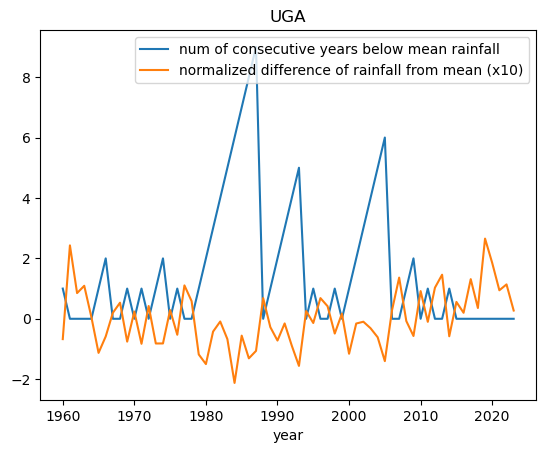

In [98]:
plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].n_below_rainfall,
         label='num of consecutive years below mean rainfall')

plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].rainfall_diff_from_mean_norm*10,
         label='normalized difference of rainfall from mean (x10)')

plt.xlabel('year')
plt.legend()
plt.title('UGA')
plt.show()

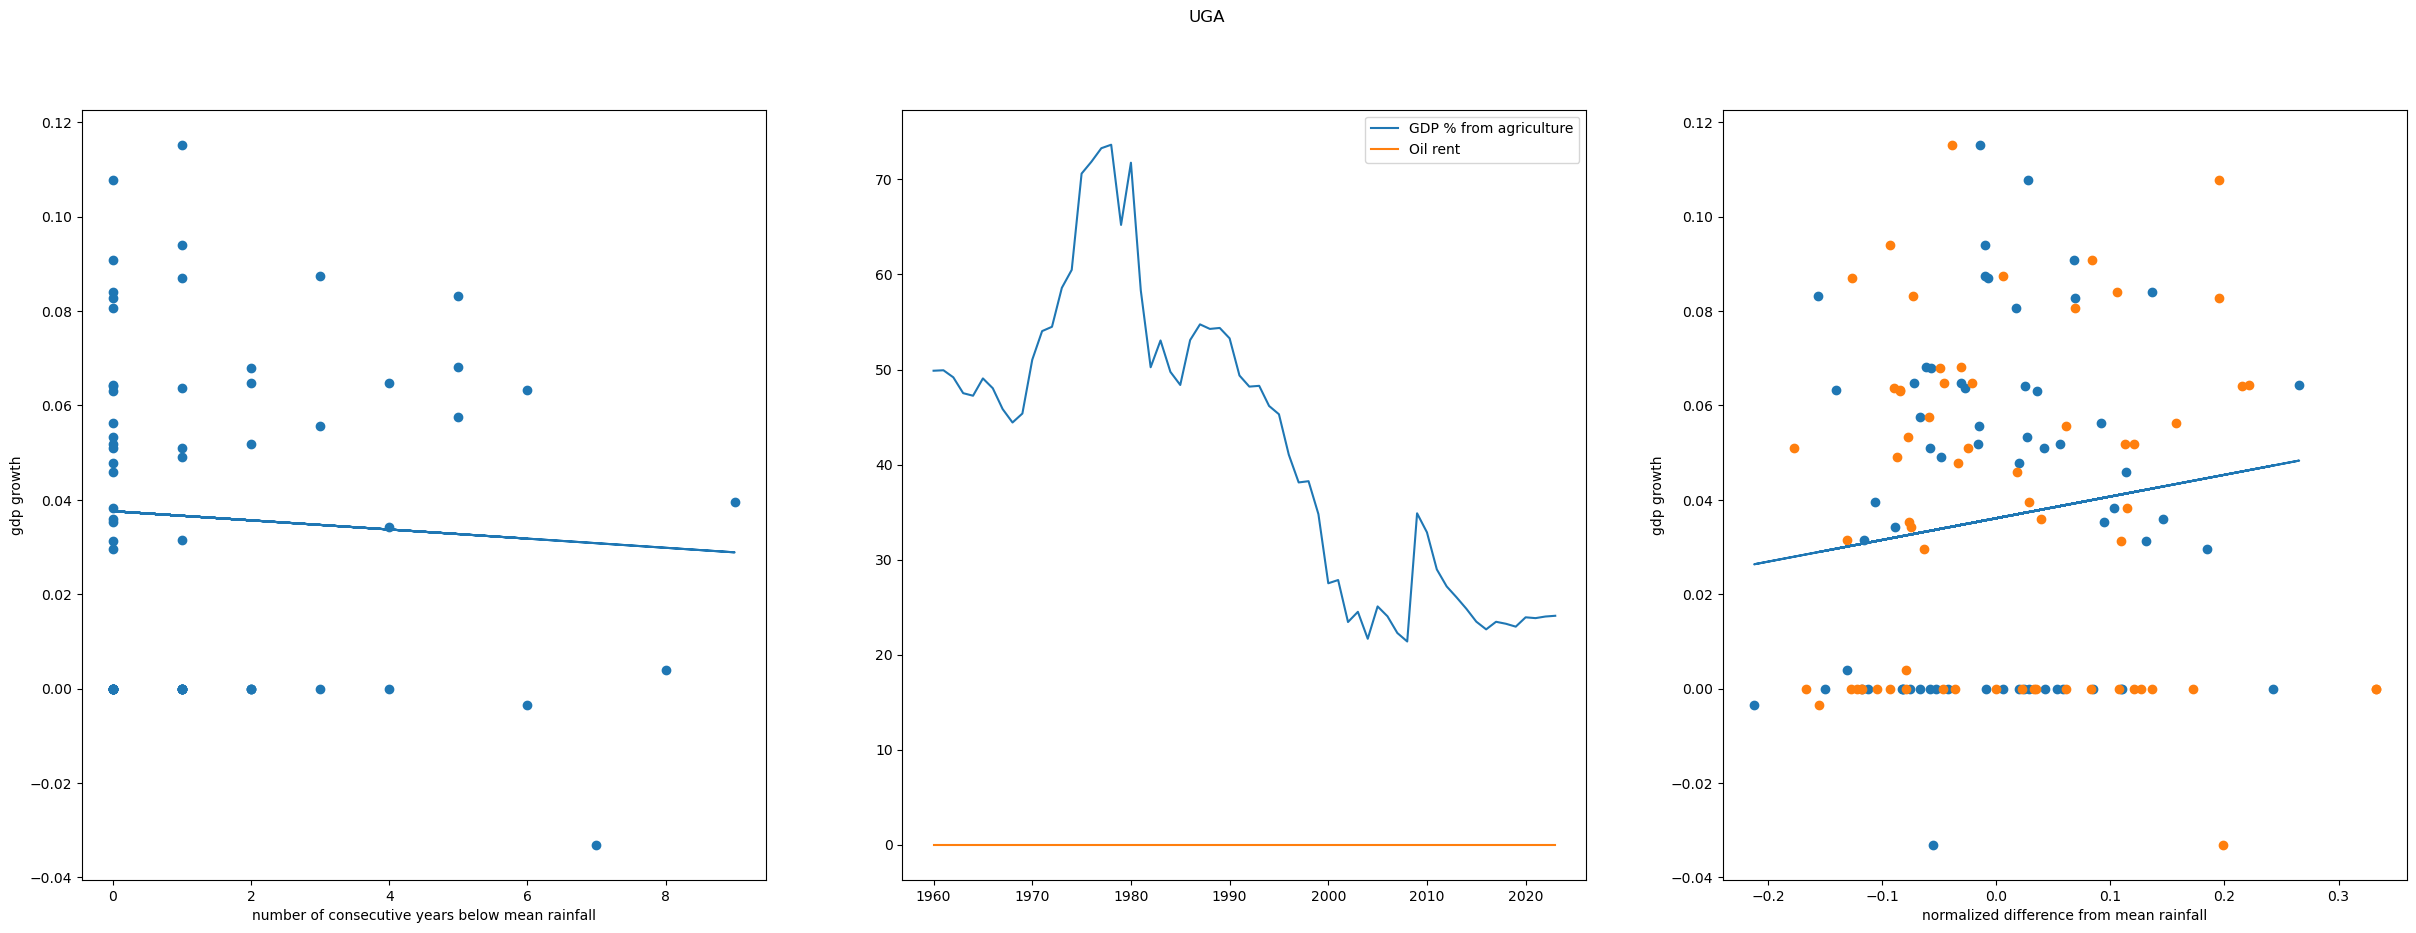

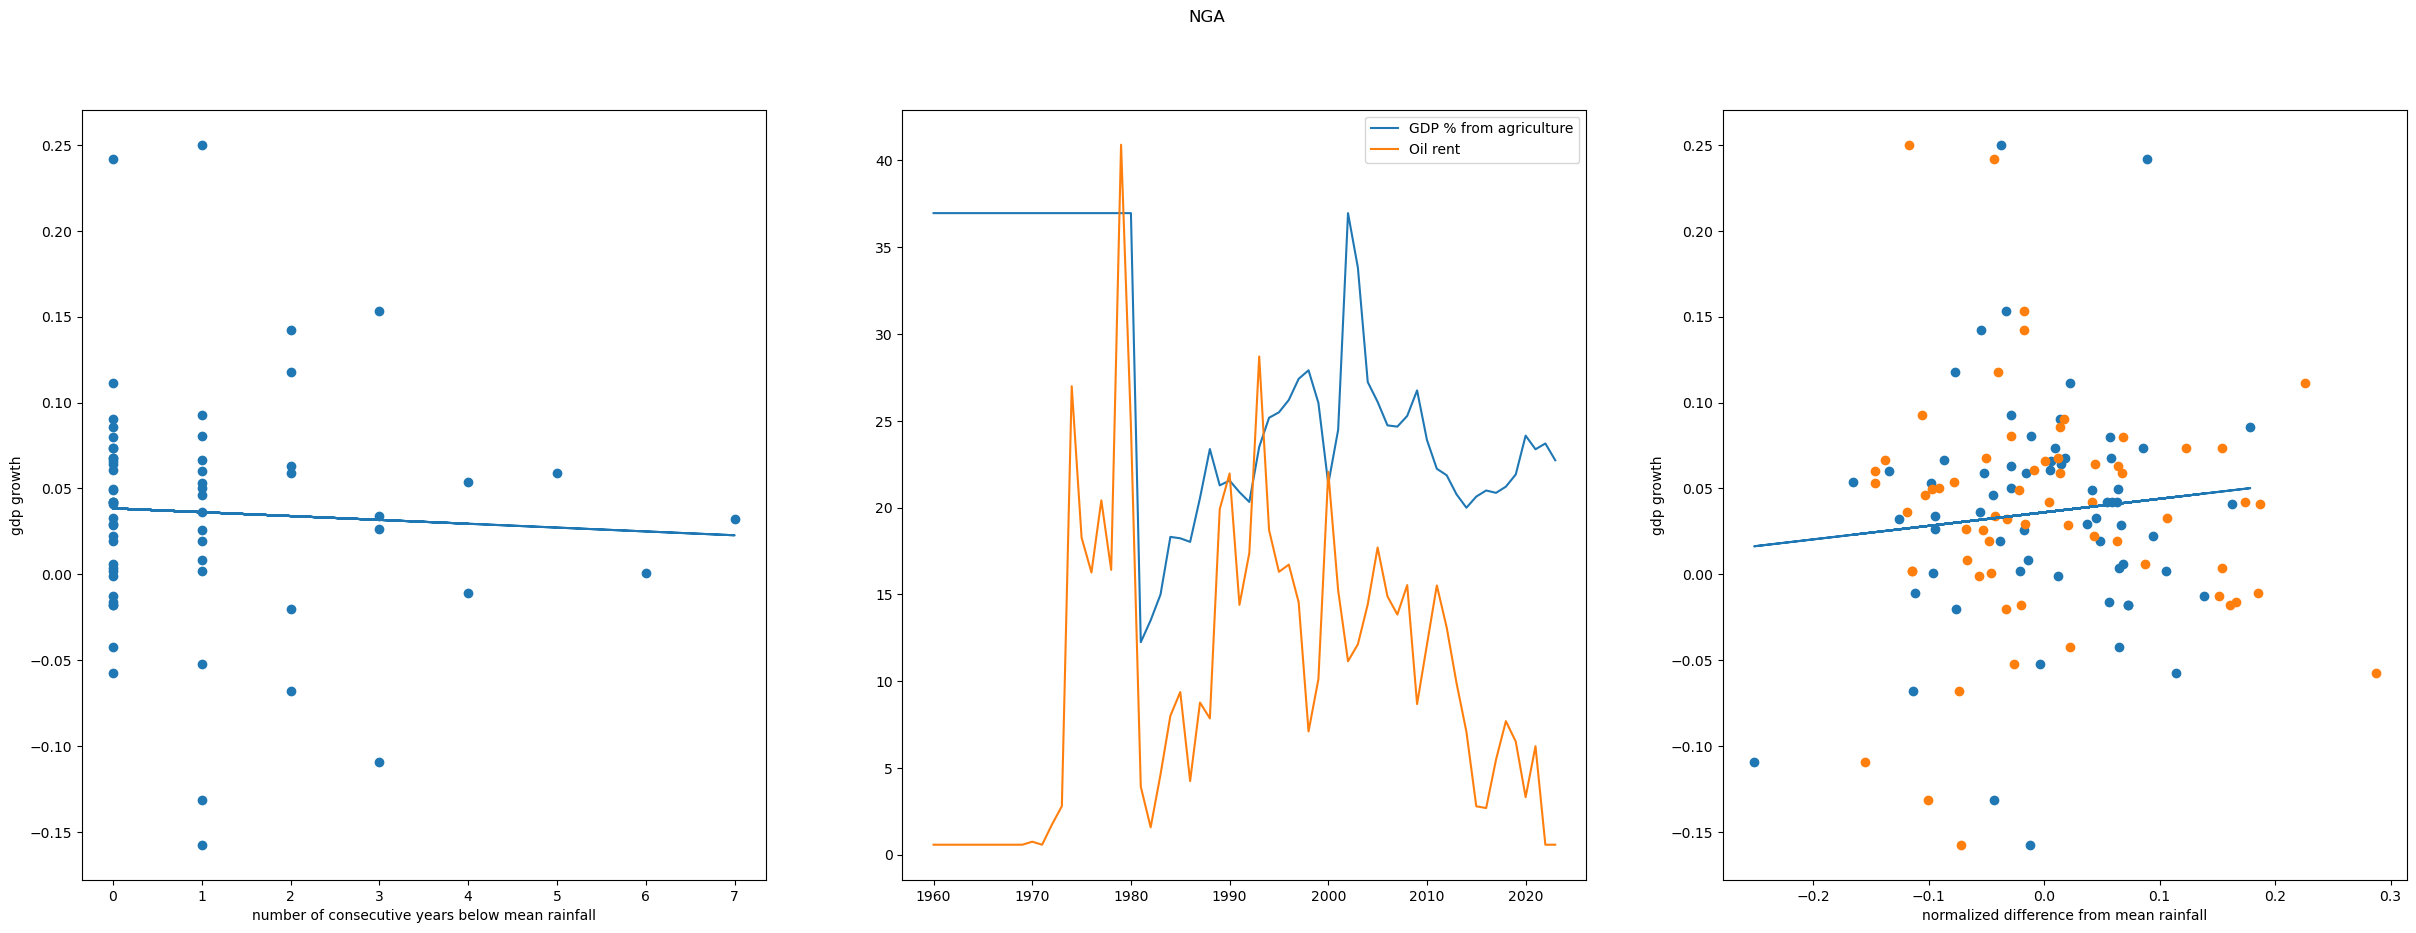

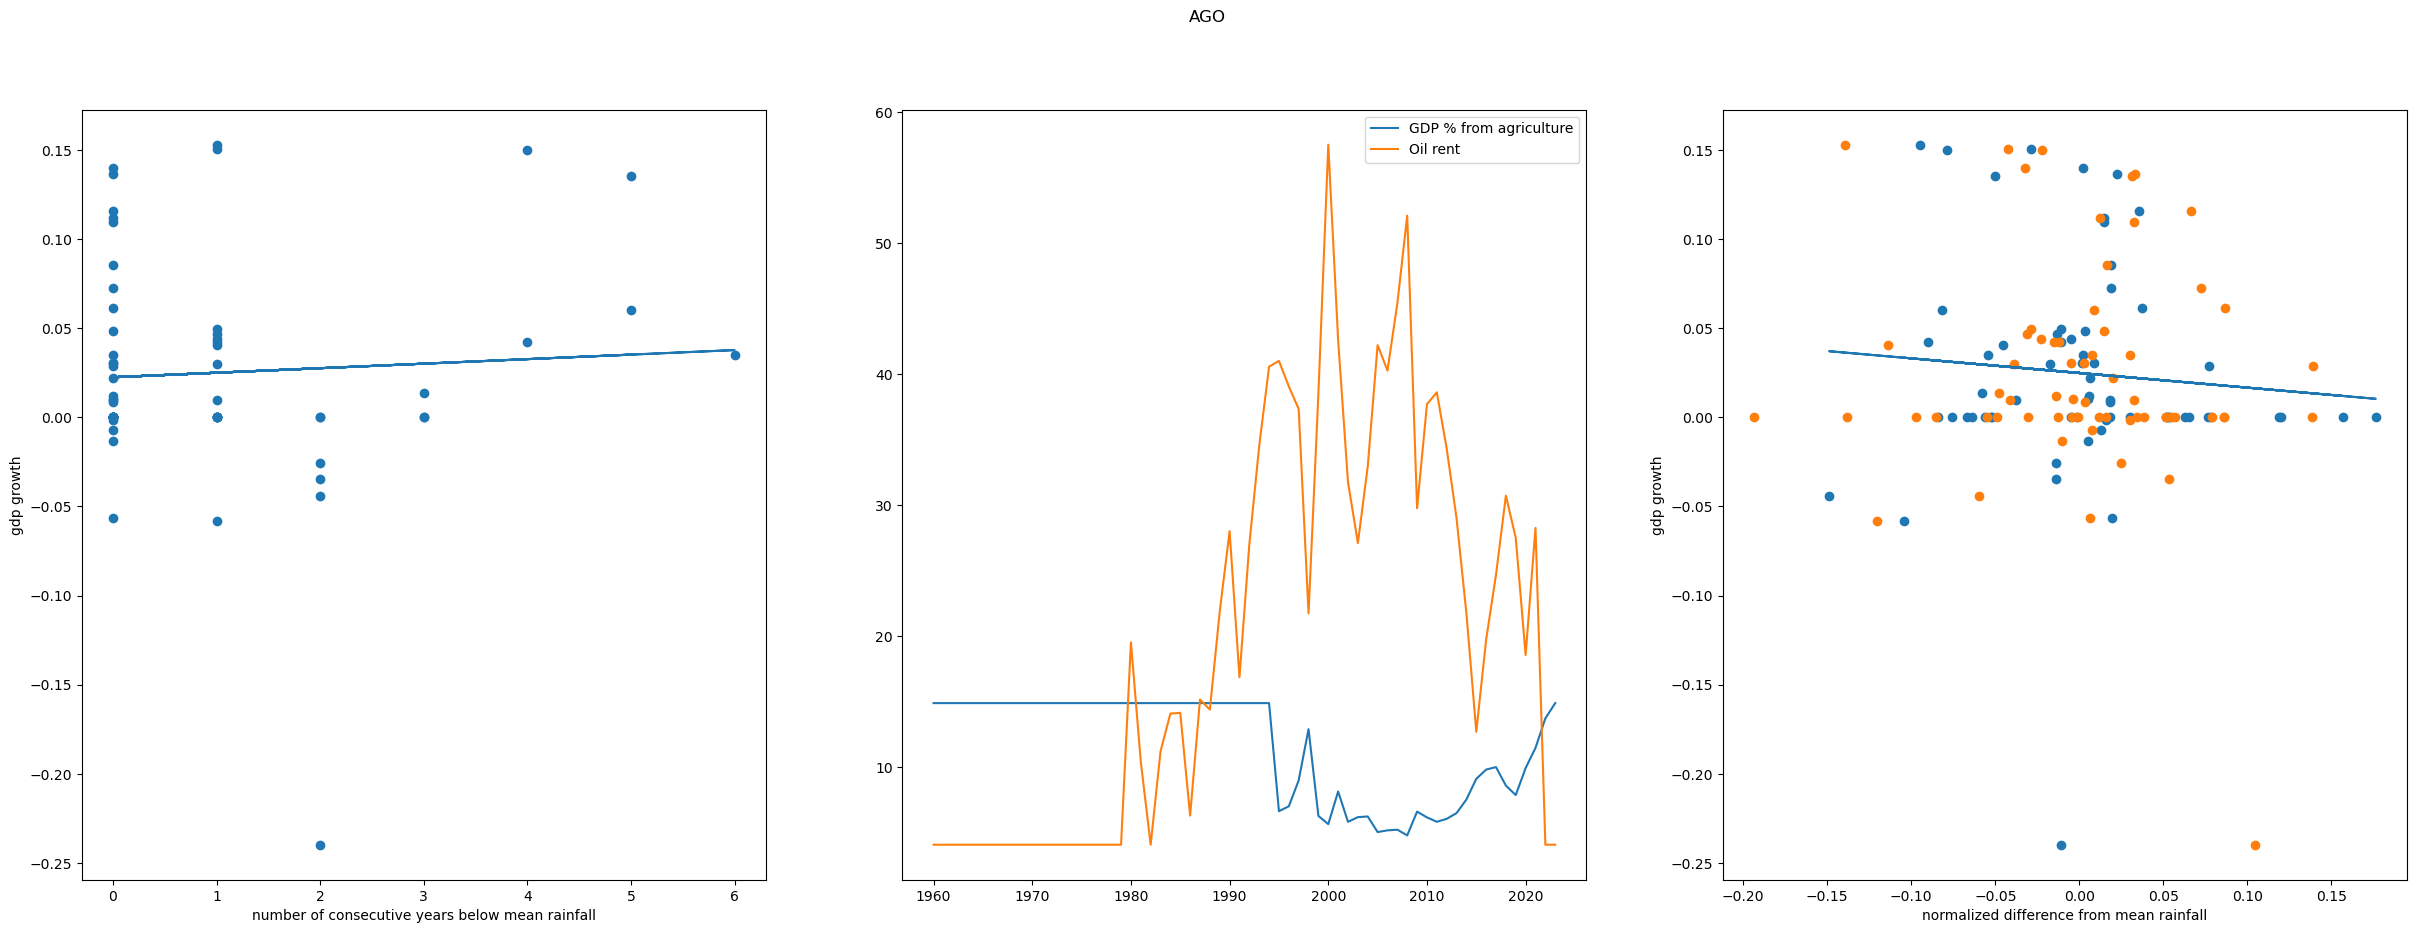

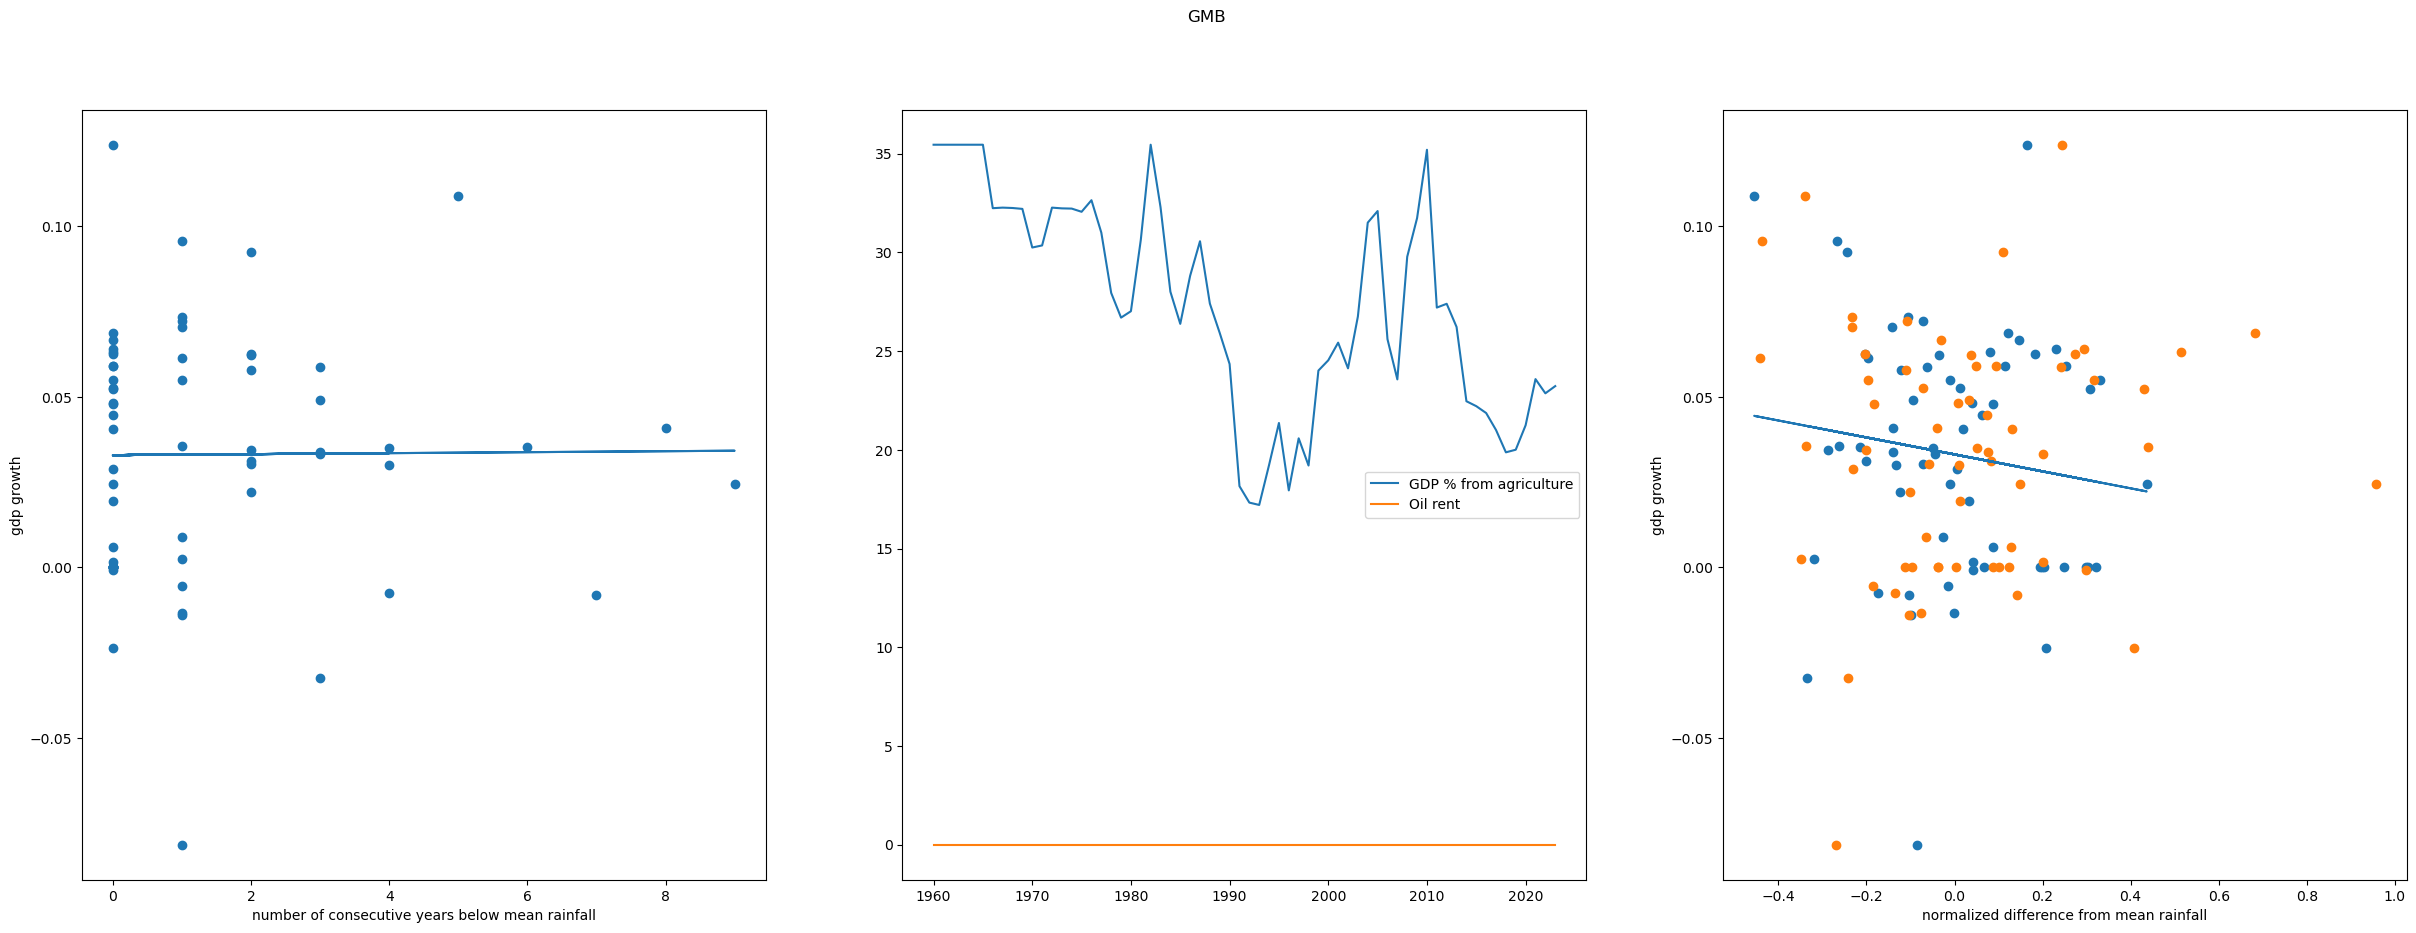

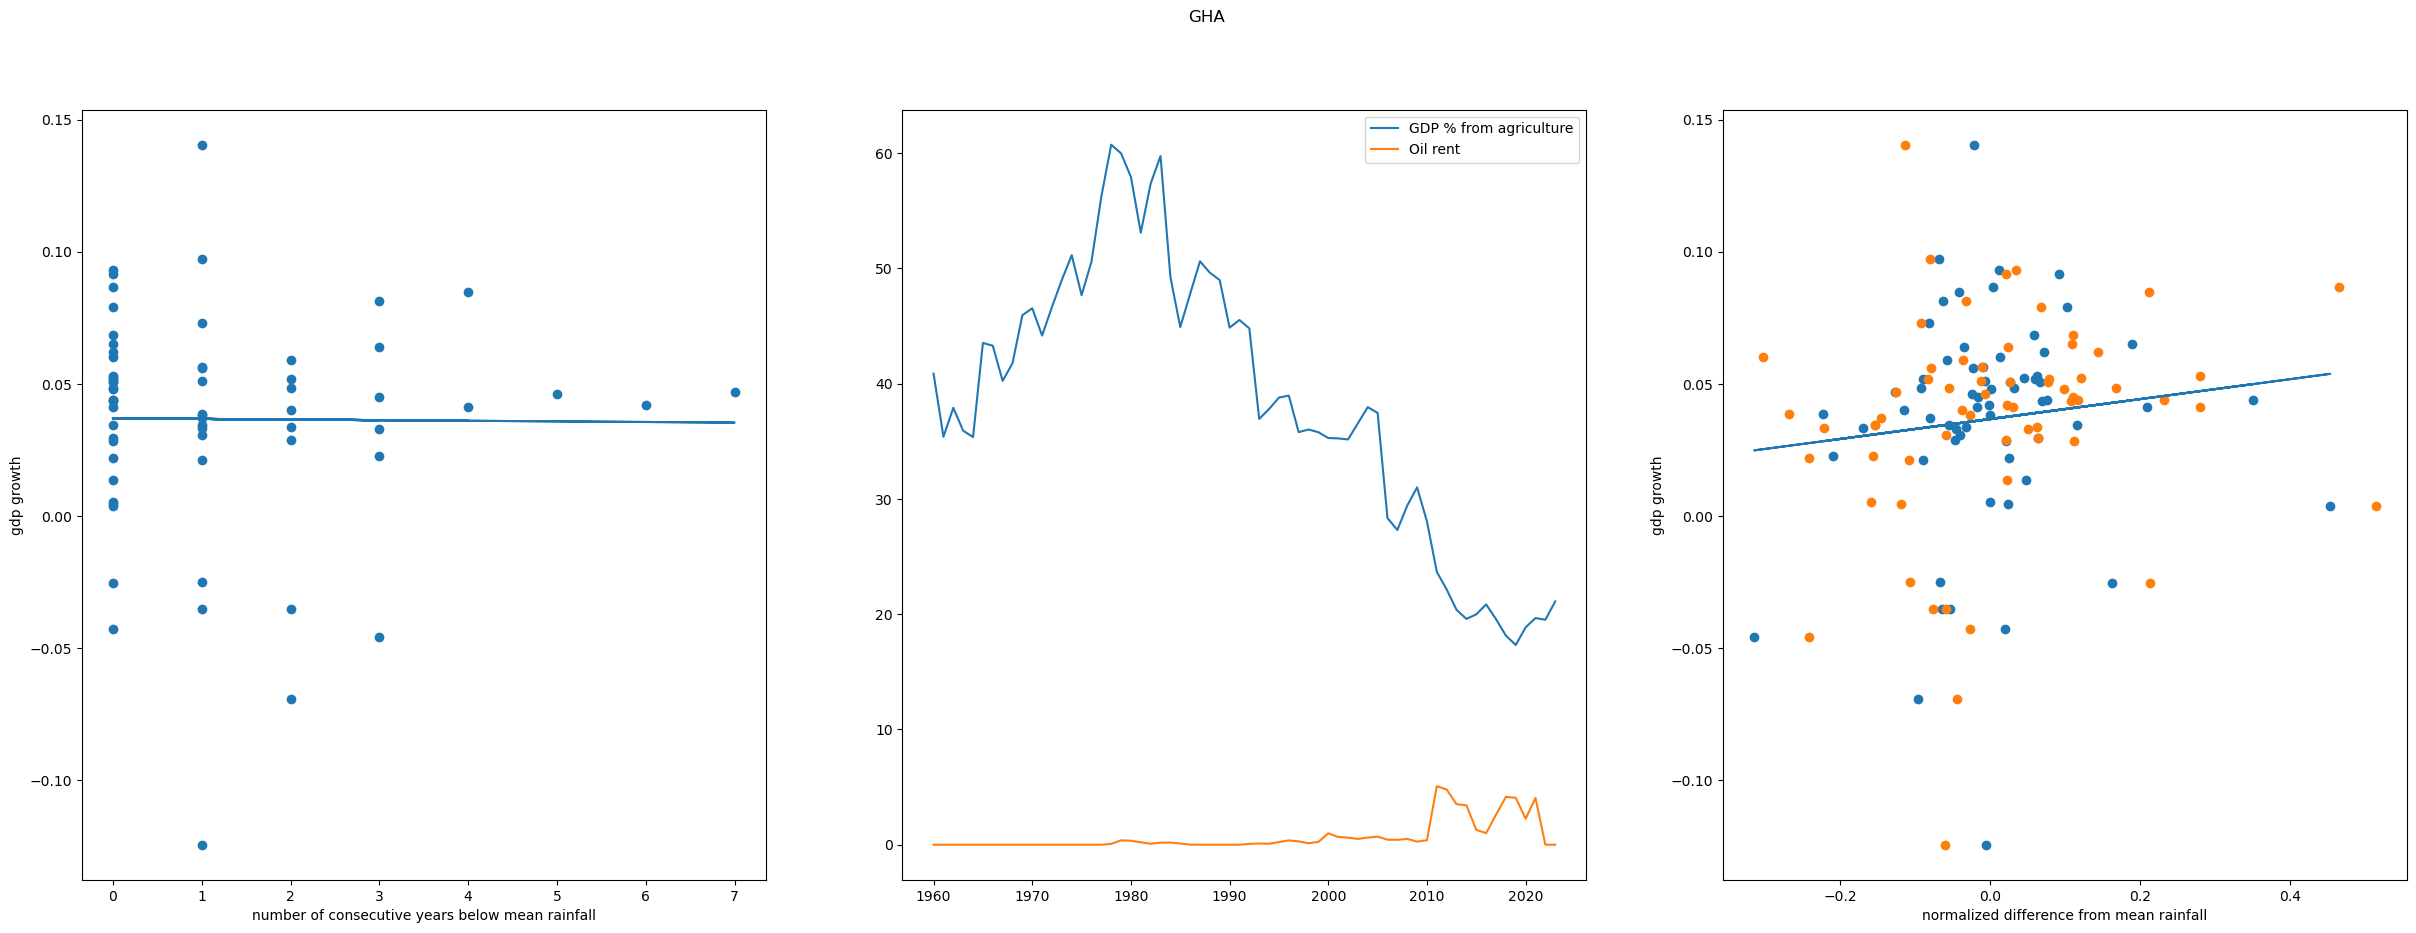

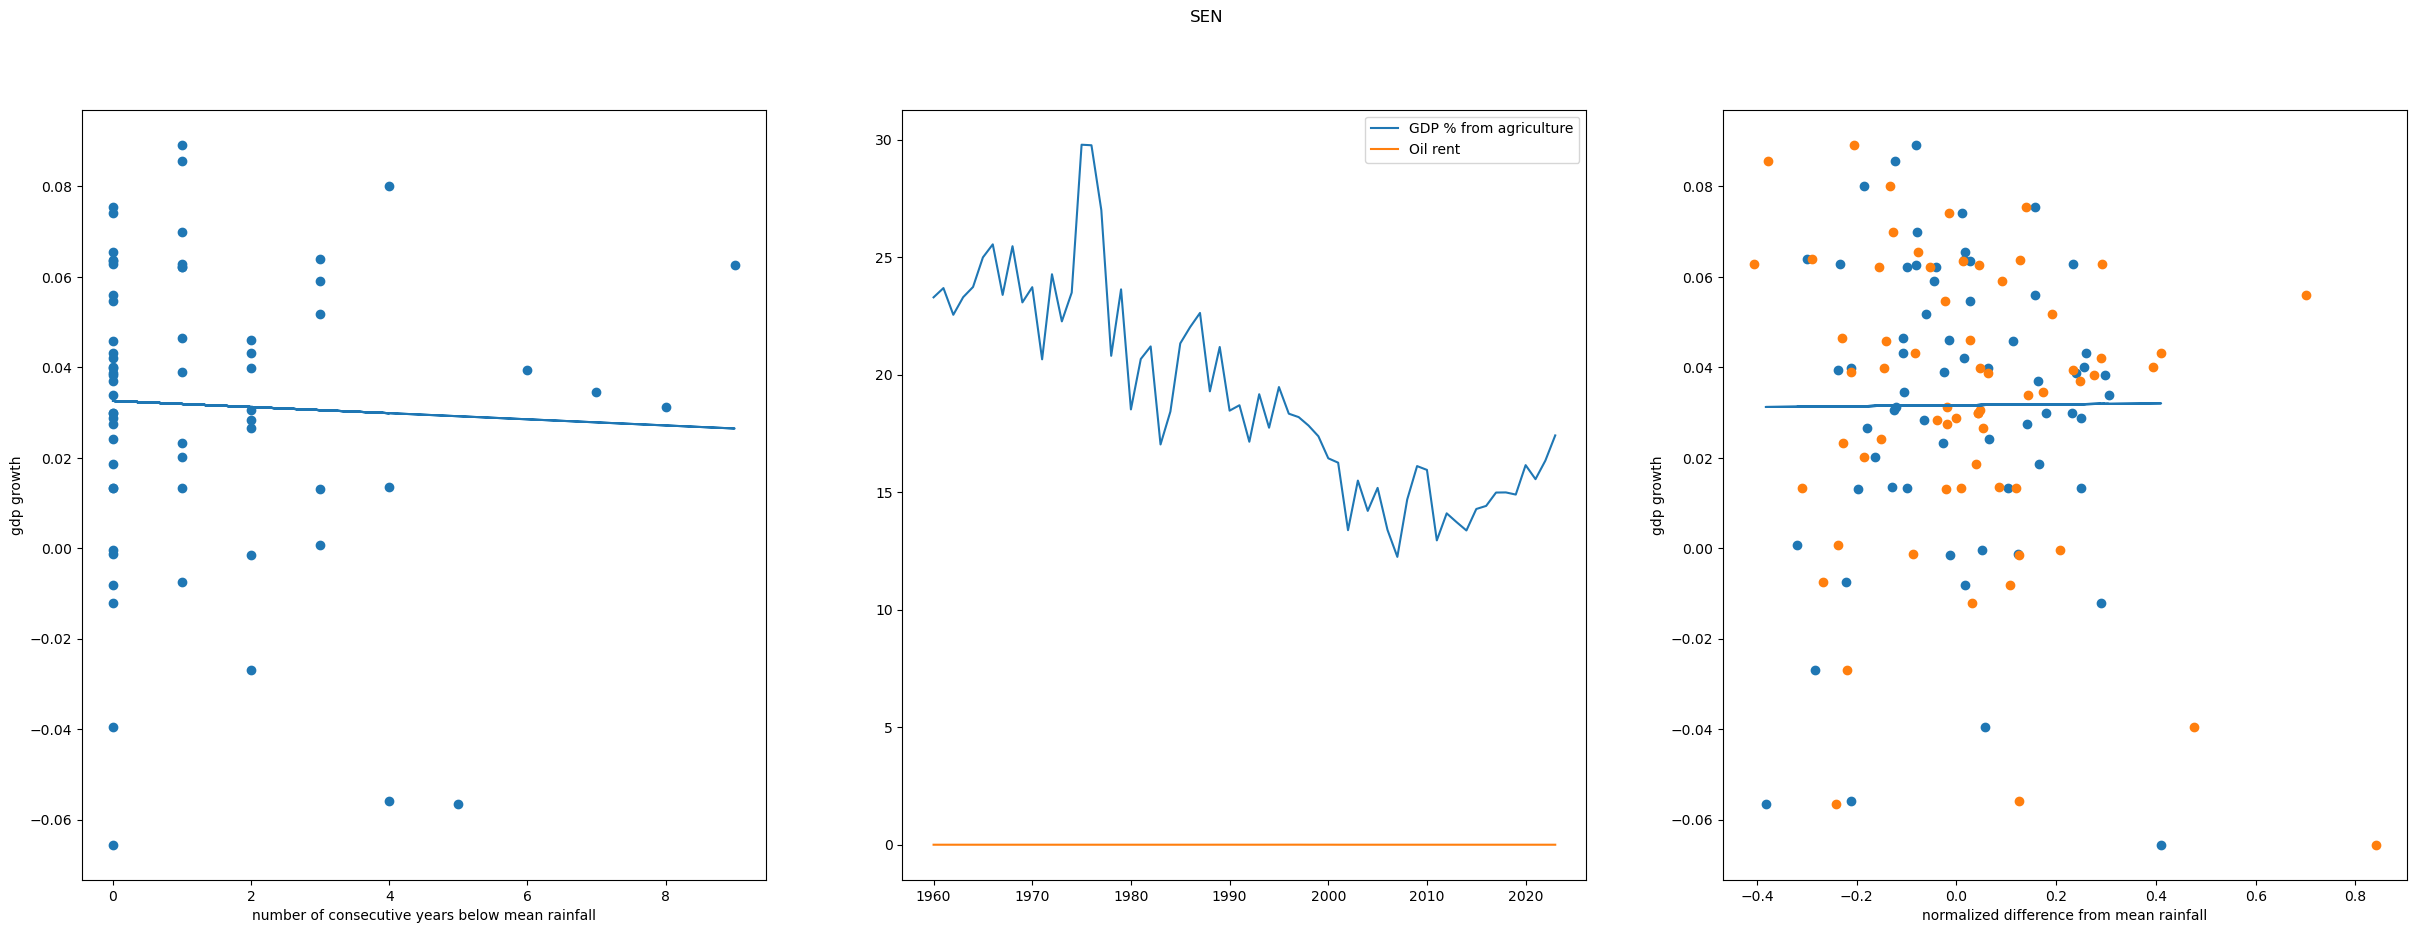

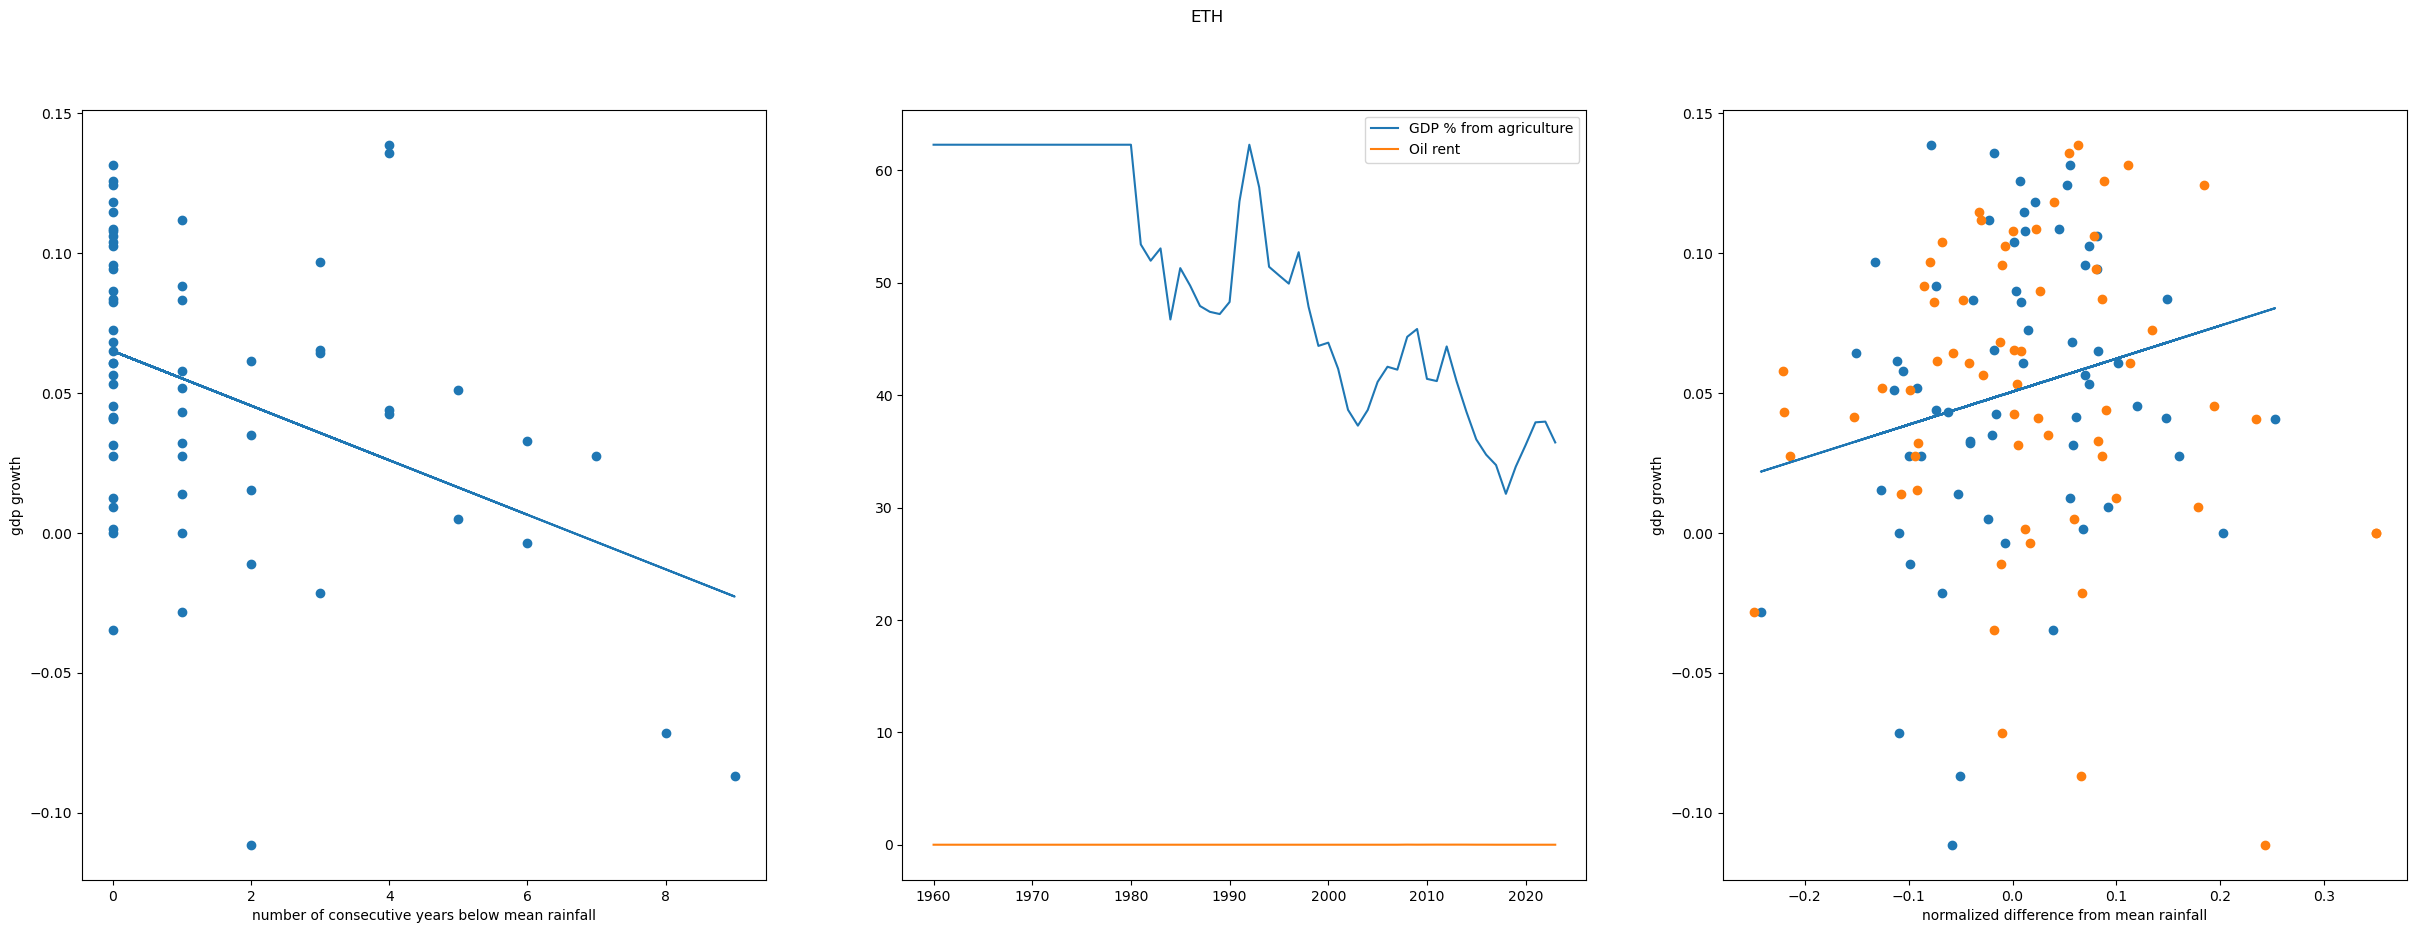

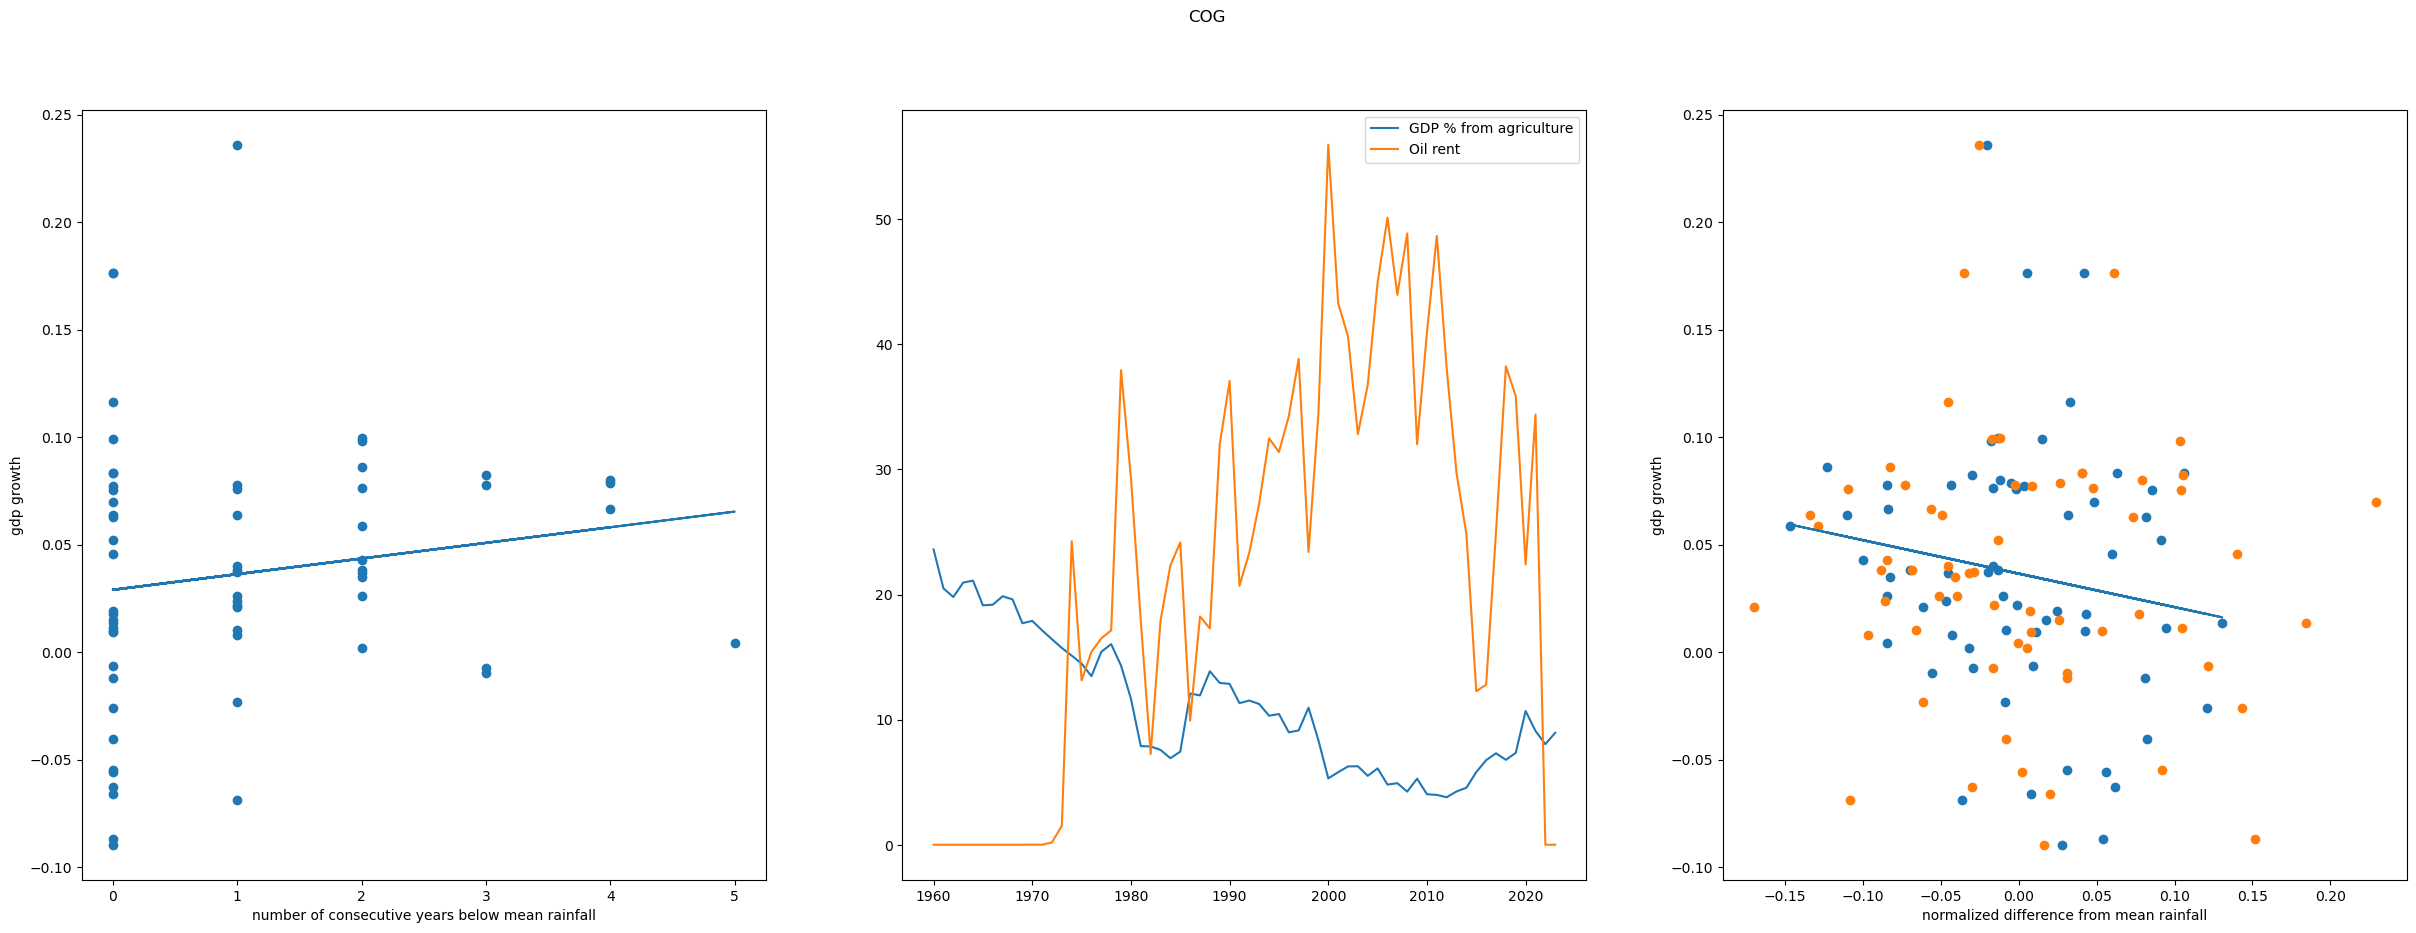

In [99]:
from sklearn.linear_model import LinearRegression

countries = ['UGA', 'NGA', 'AGO', 'GMB', 'GHA', 'SEN', 'ETH', 'COG']

for country in countries:
    fig, ax = plt.subplots(1,3,figsize=(30,10))
    country_subset = subset[subset['ISO3_code']==country]

    ax[0].scatter(country_subset['n_below_rainfall'], country_subset['gdp_g'])

    ols = LinearRegression()
    ols.fit(country_subset[['n_below_rainfall']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['n_below_rainfall']])
    ax[0].plot(country_subset['n_below_rainfall'], yp)

    ax[0].set_xlabel('number of consecutive years below mean rainfall')
    ax[0].set_ylabel('gdp growth')

    ax[1].plot(country_subset['Year'], country_subset['pt_gdp_agriculture'], label='GDP % from agriculture')
    ax[1].plot(country_subset['Year'], country_subset['oil_rent'], label='Oil rent')
    ax[1].legend()

    ax[2].scatter(country_subset['rainfall_diff_from_mean_norm'], country_subset['gdp_g'])
    ols.fit(country_subset[['rainfall_diff_from_mean_norm']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['rainfall_diff_from_mean_norm']])
    ax[2].plot(country_subset['rainfall_diff_from_mean_norm'], yp)
    ax[2].set_xlabel('normalized difference from mean rainfall')
    ax[2].set_ylabel('gdp growth')

    ax[2].scatter(country_subset['rainfall_var_t'], country_subset['gdp_g'])

    plt.suptitle(country)
    plt.show()


## Try OLS on countries with low oil production and high agricultural output


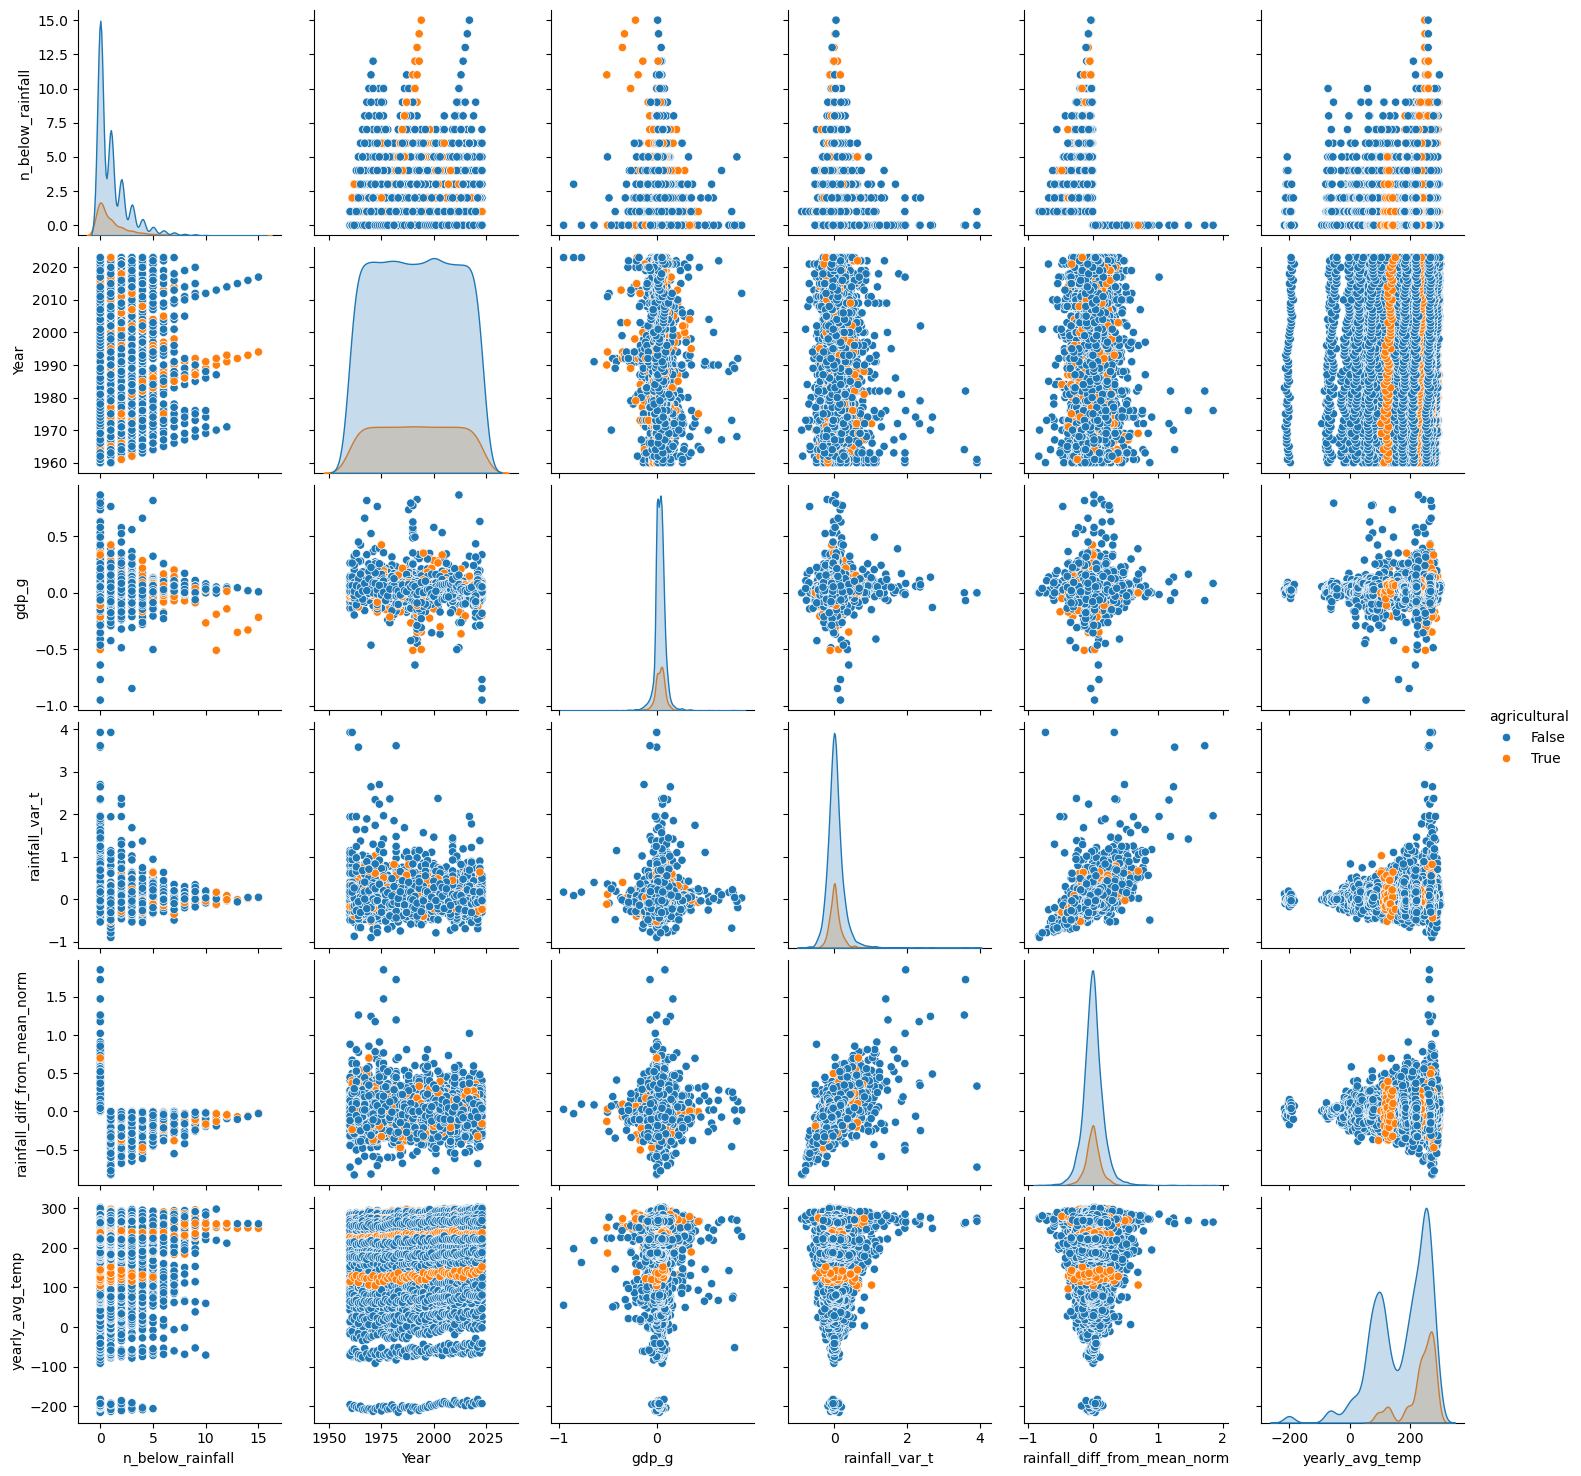

In [109]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='agricultural')

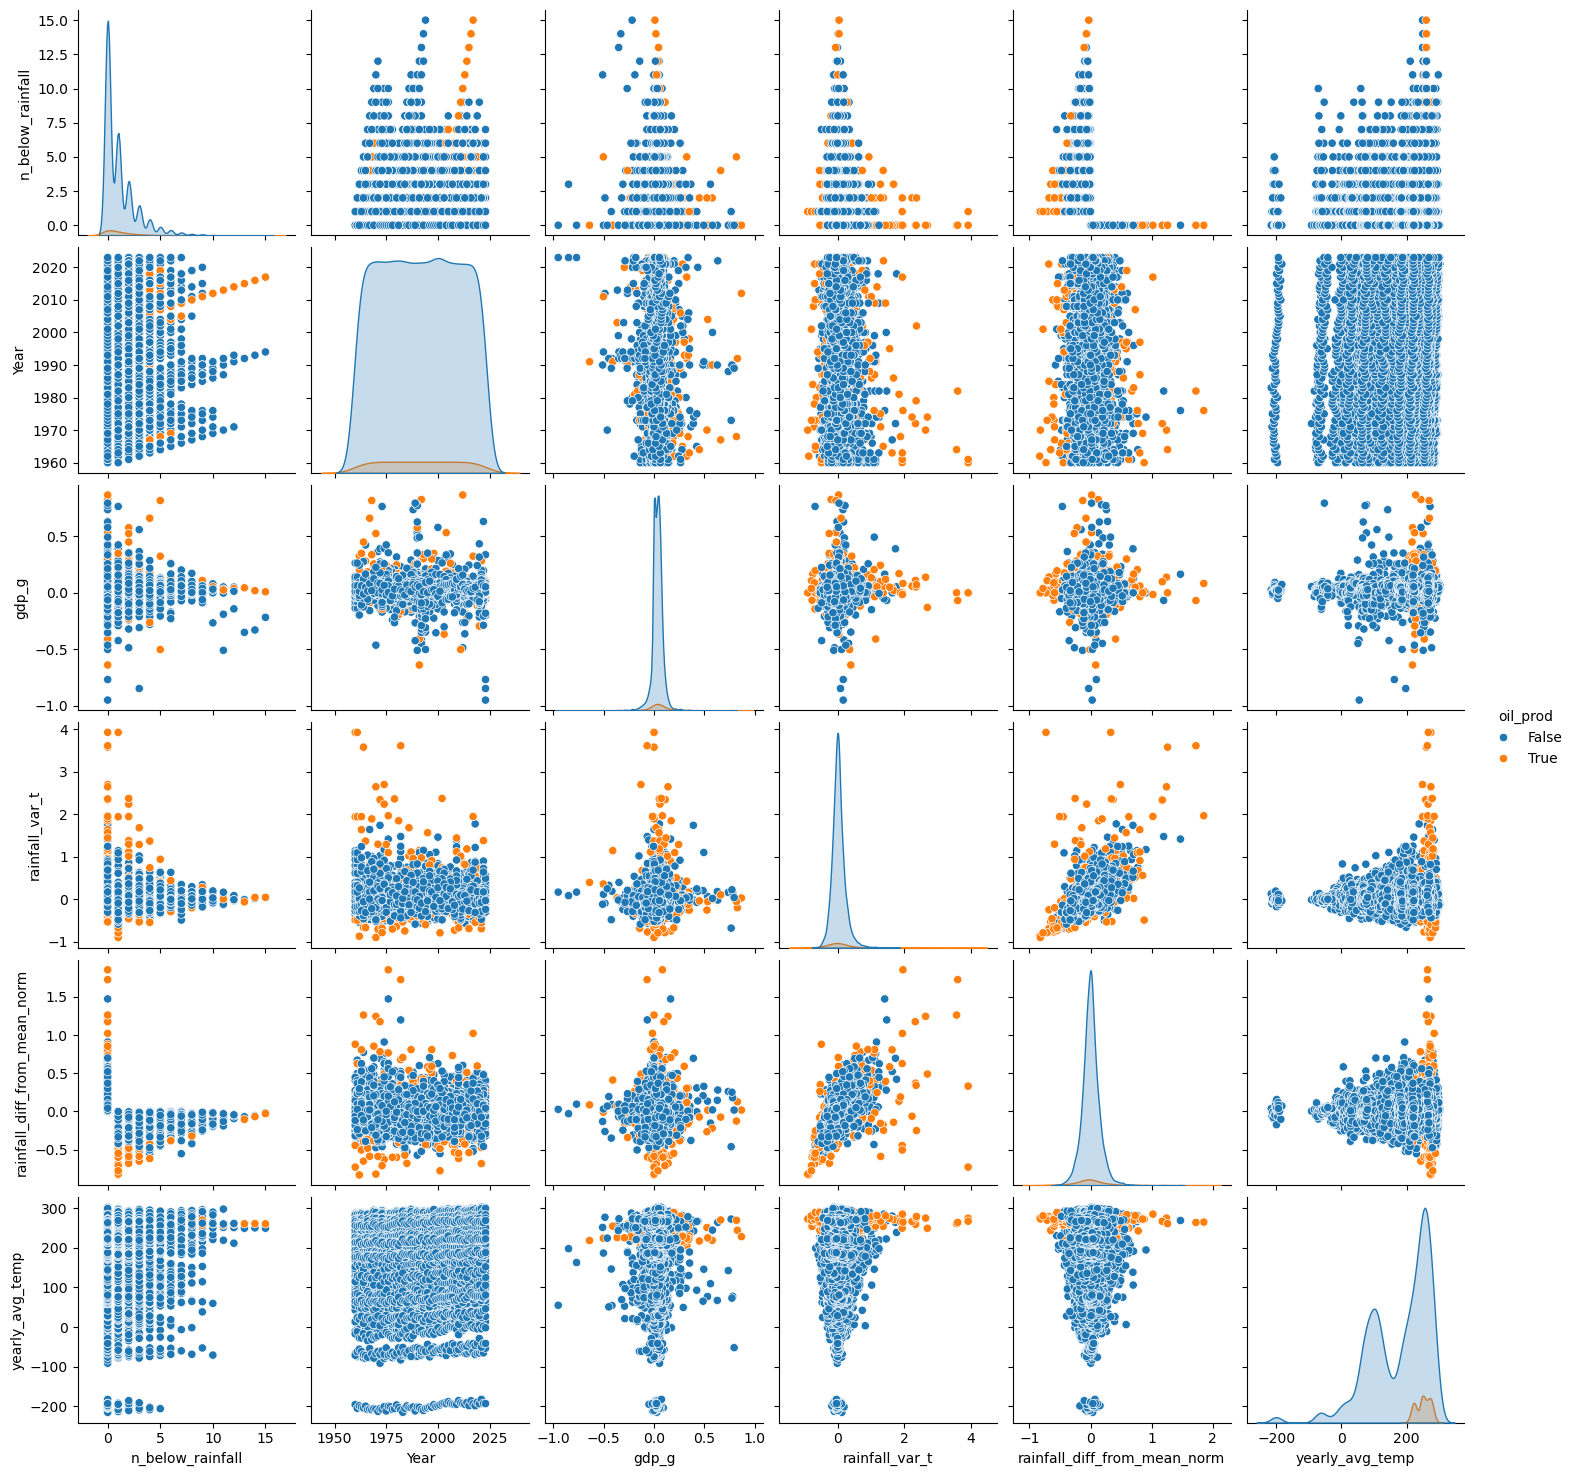

In [110]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='oil_prod')

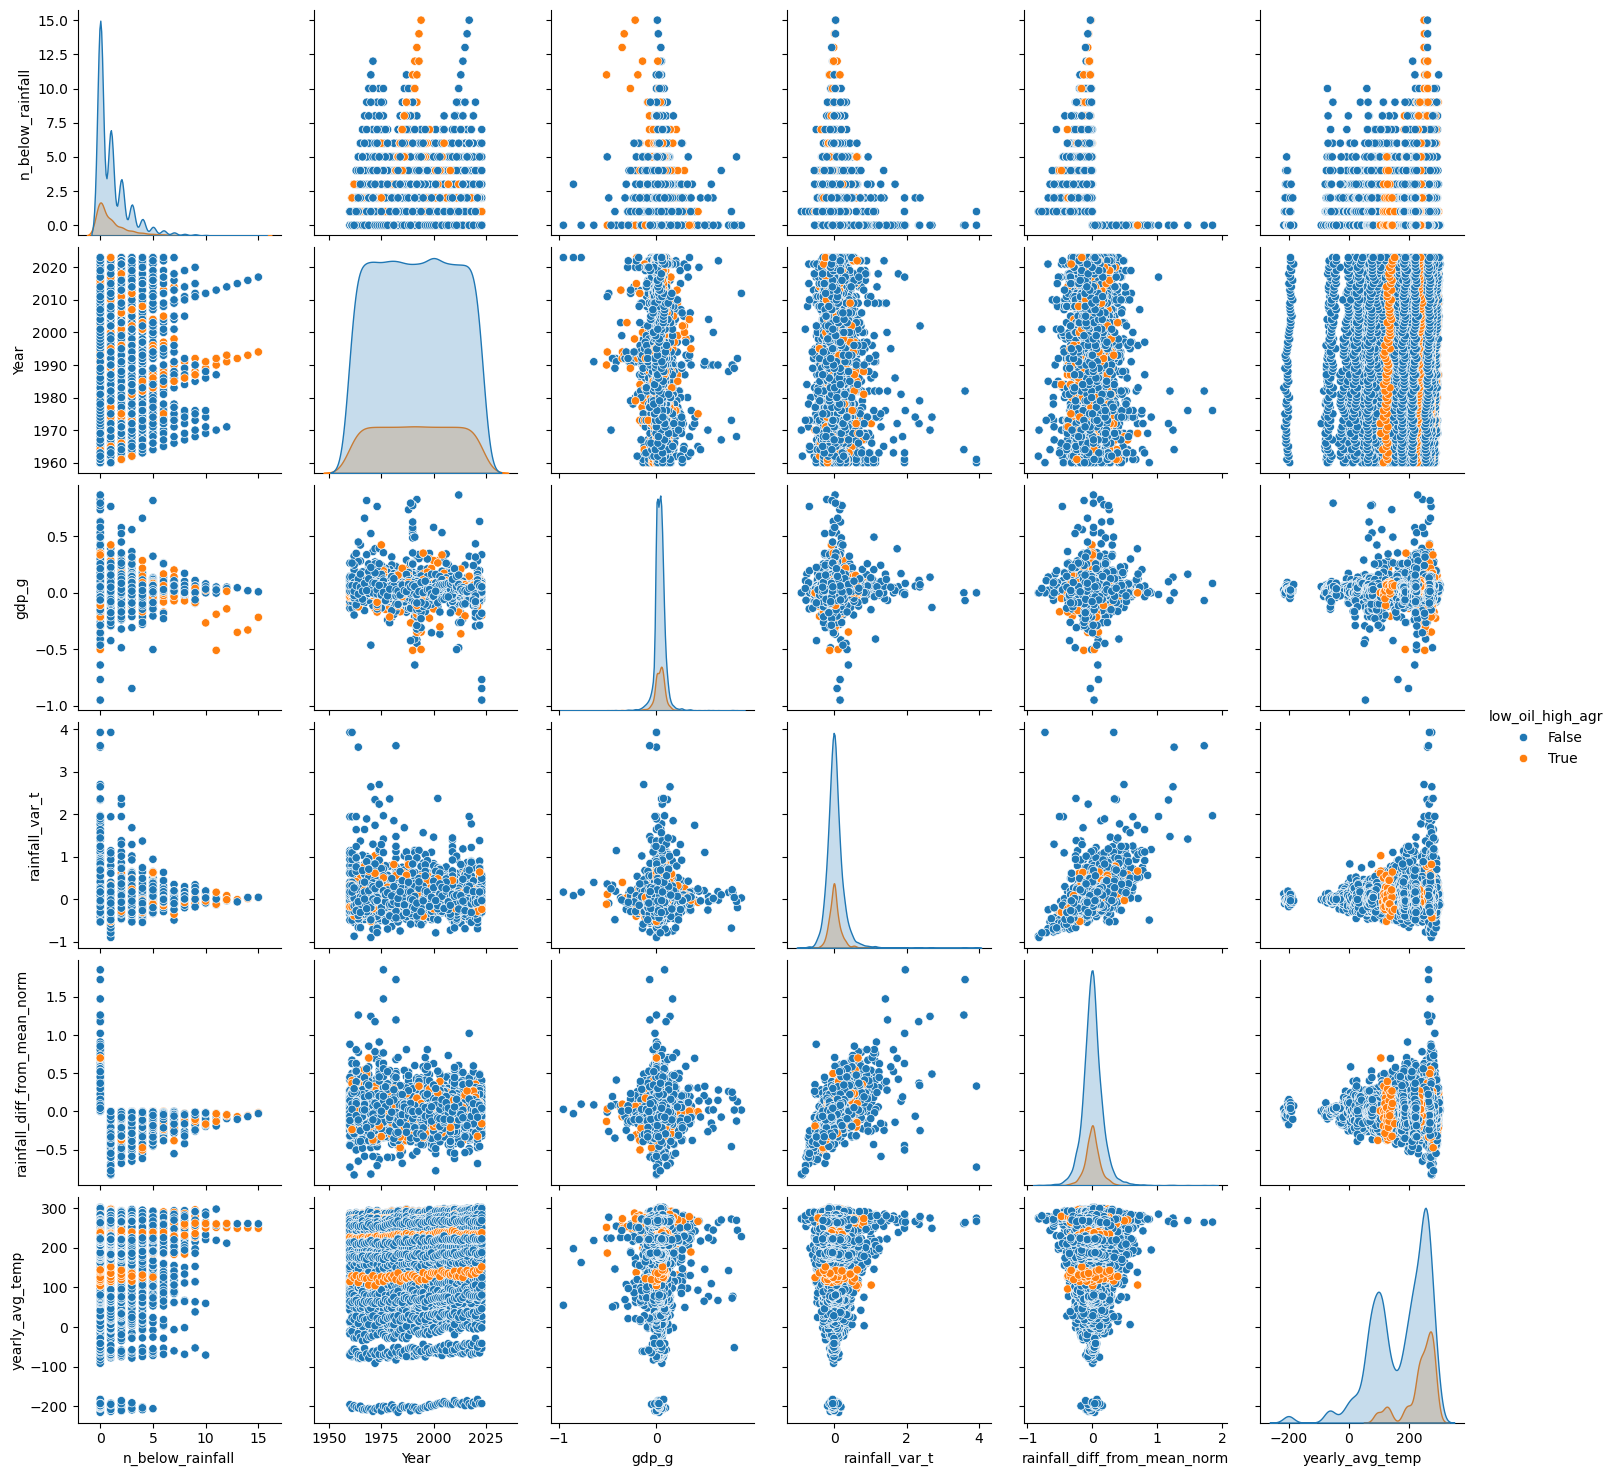

In [111]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='low_oil_high_agr')

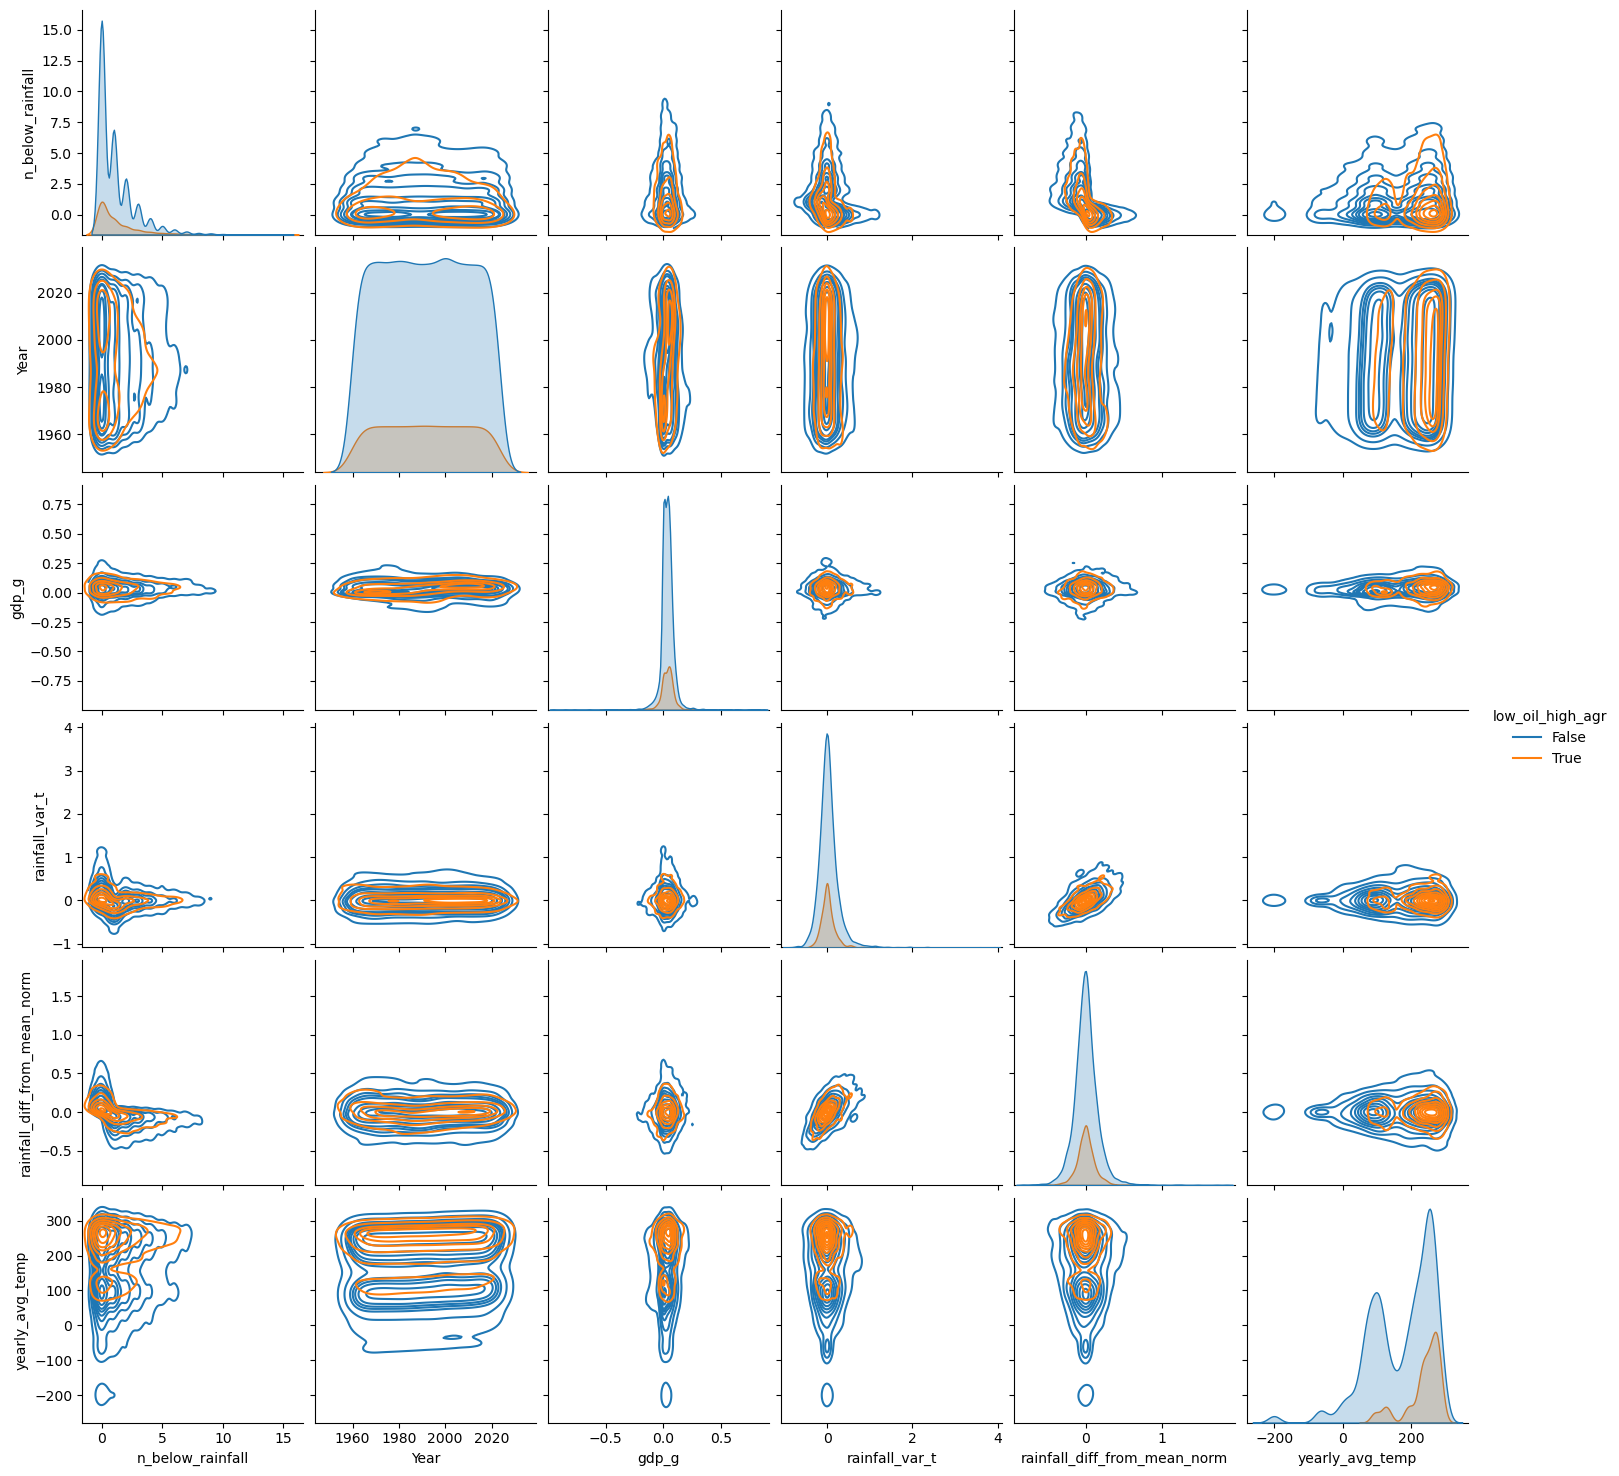

In [112]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='low_oil_high_agr',
             kind='kde')

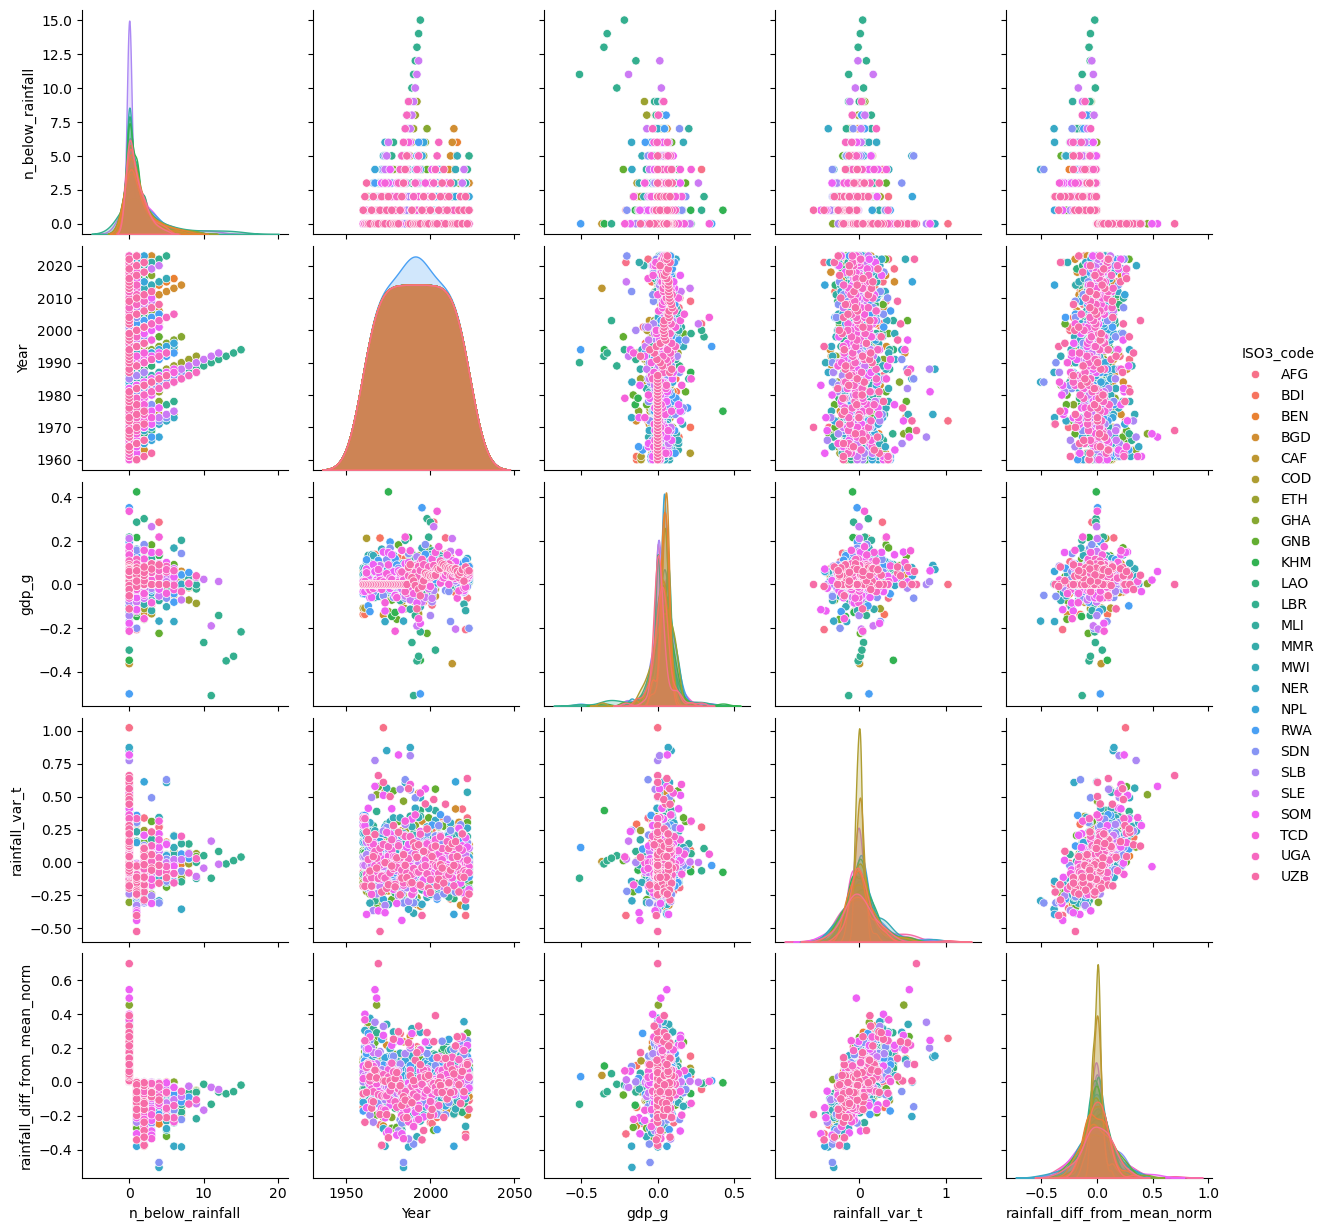

In [113]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']

sns.pairplot(subset[subset['low_oil_high_agr']==True],
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='ISO3_code')

In [114]:
from sklearn.metrics import root_mean_squared_error

low_oil_high_agriculture = subset[subset['low_oil_high_agr']==True].copy()

feat = ['n_below_rainfall']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0343, rmse:0.06180


In [115]:
feat = ['rainfall_diff_from_mean_norm']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0082, rmse:0.06263


In [116]:
feat = ['rainfall_var_t']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0048, rmse:0.06274


In [121]:
feat = ['rainfall_var_t', 'n_below_rainfall', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
target = ['gdp_g']

ols = LinearRegression()
ols.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
r2 = ols.score(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])
ypred = ols.predict(low_oil_high_agriculture[feat])
rmse_lr = root_mean_squared_error(low_oil_high_agriculture[target], ypred)
print(f'R2: {r2:.4f}, rmse:{rmse_lr:.5f}')

R2: 0.0385, rmse:0.06167


### Try random forest regressor

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [125]:
grid_cv = GridSearchCV(RandomForestRegressor(),
                       param_grid={'max_depth': range(1, 11),
                                   'n_estimators': [100, 500]},
                                   scoring='neg_root_mean_squared_error',
                                   cv=5)

feat = ['rainfall_var_t', 'n_below_rainfall', 'rainfall_diff_from_mean_norm', 'yearly_avg_temp']
target = 'gdp_g'
grid_cv.fit(low_oil_high_agriculture[feat], low_oil_high_agriculture[target])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 11), 'n_estimators': [100, 500]},
             scoring='neg_root_mean_squared_error')

In [124]:
print(grid_cv.best_params_, grid_cv.best_score_)

{'max_depth': 2, 'n_estimators': 100} -0.061909358906694426


In [127]:
feature_importance_df = pd.DataFrame({
    'Feature': feat,  # List of feature names
    'Importance': grid_cv.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df)

                        Feature  Importance
0              n_below_rainfall    0.662230
1  rainfall_diff_from_mean_norm    0.242677
2               yearly_avg_temp    0.049552
3                rainfall_var_t    0.045541


### Try XGBoost

In [128]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 66.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 67.1 MB/s eta 0:00:0000:0100:01


In [129]:
import xgboost as xgb

rmse:0.0587


[]

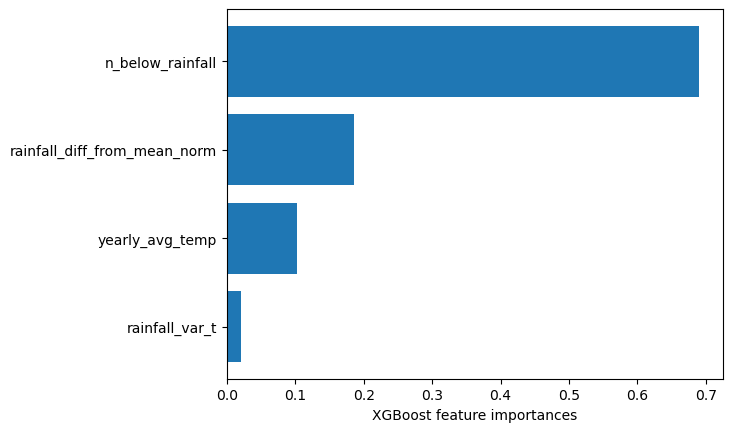

In [137]:
xgb_reg = xgb.XGBRegressor(learning_rate=0.1,
                            max_depth=3,
                            n_estimators=10)

X = low_oil_high_agriculture[feat]
y = low_oil_high_agriculture[target]
xgb_reg.fit(X, y)

ypreds = xgb_reg.predict(X)
rmse_xgb = root_mean_squared_error(y, ypreds)
print(f'rmse:{rmse_xgb:.4f}')

sorted_idx = xgb_reg.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_reg.feature_importances_[sorted_idx])
plt.xlabel('XGBoost feature importances')
plt.plot()

rmse:0.0661


[]

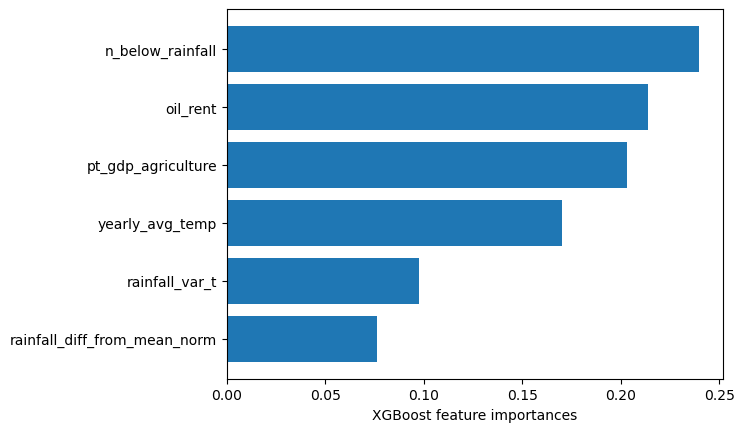

In [150]:
xgb_reg_2 = xgb.XGBRegressor(learning_rate=0.1,
                             max_depth=3,
                             n_estimators=10)

feat = ['n_below_rainfall', 'rainfall_var_t', 'rainfall_diff_from_mean_norm',
        'yearly_avg_temp', 'oil_rent', 'pt_gdp_agriculture']

target = 'gdp_g'

X = subset[feat]
y = subset[target]

xgb_reg_2.fit(X, y)

ypreds = xgb_reg_2.predict(X)
rmse_xgb_2 = root_mean_squared_error(y, ypreds)
print(f'rmse:{rmse_xgb_2:.4f}')

sorted_idx = xgb_reg_2.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_reg_2.feature_importances_[sorted_idx])
plt.xlabel('XGBoost feature importances')
plt.plot()

rmse:0.0664


[]

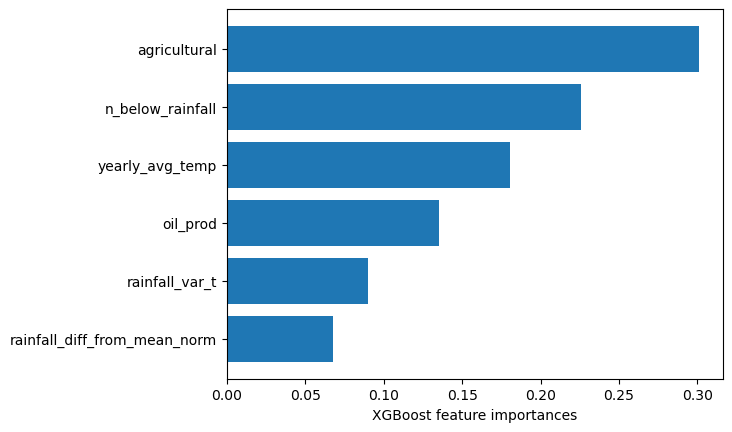

In [149]:
xgb_reg_2 = xgb.XGBRegressor(learning_rate=0.1,
                             max_depth=3,
                             n_estimators=10)

feat = ['n_below_rainfall', 'rainfall_var_t', 'rainfall_diff_from_mean_norm',
        'yearly_avg_temp', 'oil_prod', 'agricultural']

target = 'gdp_g'

X = subset[feat]
y = subset[target]

xgb_reg_2.fit(X, y)

ypreds = xgb_reg_2.predict(X)
rmse_xgb_2 = root_mean_squared_error(y, ypreds)
print(f'rmse:{rmse_xgb_2:.4f}')

sorted_idx = xgb_reg_2.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_reg_2.feature_importances_[sorted_idx])
plt.xlabel('XGBoost feature importances')
plt.plot()

With proper cross validation. Requires writing a wrapper class for the XGBoost regressor ([described here](https://stackoverflow.com/a/51997797/2112406)). 

In [147]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier


class XGBoostForSklearn(BaseEstimator):
    def __init__(self, test_size=0.1, **estimator_params):
        self.test_size = test_size        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorForSklearn(XGBoostForSklearn):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorForSklearn, self).__init__(*args, **kwargs)

class XGBoostClassifierForSklearn(XGBoostForSklearn):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierForSklearn, self).__init__(*args, **kwargs)

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBoostRegressorForSklearn())
])

param_grid = {
    'xgb__n_estimators': [10, 100, 500],
    'xgb__max_depth': [1, 3, 5, 10]
}

grid = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error')

feat = ['n_below_rainfall', 'rainfall_var_t', 'rainfall_diff_from_mean_norm',
        'yearly_avg_temp', 'oil_prod', 'agricultural']

target = 'gdp_g'

X = subset[feat].copy()
y = subset[target].copy()

grid.fit(X, y)

print(grid.best_params_, grid_cv.best_score_)

[0]	validation_0-rmse:0.06877
[1]	validation_0-rmse:0.06871
[2]	validation_0-rmse:0.06857
[3]	validation_0-rmse:0.06858
[4]	validation_0-rmse:0.06856
[5]	validation_0-rmse:0.06856
[6]	validation_0-rmse:0.06849
[7]	validation_0-rmse:0.06848
[8]	validation_0-rmse:0.06848
[9]	validation_0-rmse:0.06848
[0]	validation_0-rmse:0.07165
[1]	validation_0-rmse:0.07158
[2]	validation_0-rmse:0.07159
[3]	validation_0-rmse:0.07159
[4]	validation_0-rmse:0.07161
[5]	validation_0-rmse:0.07164
[6]	validation_0-rmse:0.07163
[7]	validation_0-rmse:0.07163
[8]	validation_0-rmse:0.07163
[9]	validation_0-rmse:0.07166
[0]	validation_0-rmse:0.05154
[1]	validation_0-rmse:0.05141
[2]	validation_0-rmse:0.05132
[3]	validation_0-rmse:0.05129
[4]	validation_0-rmse:0.05126
[5]	validation_0-rmse:0.05121
[6]	validation_0-rmse:0.05121
[7]	validation_0-rmse:0.05124
[8]	validation_0-rmse:0.05122
[9]	validation_0-rmse:0.05119
[0]	validation_0-rmse:0.05728
[1]	validation_0-rmse:0.05724
[2]	validation_0-rmse:0.05714
[3]	valida

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[6]	validation_0-rmse:0.06743
[7]	validation_0-rmse:0.06750
[8]	validation_0-rmse:0.06745
[9]	validation_0-rmse:0.06749
[0]	validation_0-rmse:0.07943
[1]	validation_0-rmse:0.07933
[2]	validation_0-rmse:0.07933
[3]	validation_0-rmse:0.07914
[4]	validation_0-rmse:0.07912
[5]	validation_0-rmse:0.07906
[6]	validation_0-rmse:0.07888
[7]	validation_0-rmse:0.07887
[8]	validation_0-rmse:0.07887
[9]	validation_0-rmse:0.07884
[10]	validation_0-rmse:0.07885
[11]	validation_0-rmse:0.07885
[12]	validation_0-rmse:0.07878
[13]	validation_0-rmse:0.07874
[14]	validation_0-rmse:0.07871
[15]	validation_0-rmse:0.07869
[16]	validation_0-rmse:0.07868
[17]	validation_0-rmse:0.07868
[18]	validation_0-rmse:0.07868
[19]	validation_0-rmse:0.07868
[20]	validation_0-rmse:0.07867


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[21]	validation_0-rmse:0.07866
[22]	validation_0-rmse:0.07866
[23]	validation_0-rmse:0.07865
[24]	validation_0-rmse:0.07864
[25]	validation_0-rmse:0.07863
[26]	validation_0-rmse:0.07860
[27]	validation_0-rmse:0.07856
[28]	validation_0-rmse:0.07855
[29]	validation_0-rmse:0.07854
[30]	validation_0-rmse:0.07854
[31]	validation_0-rmse:0.07855
[32]	validation_0-rmse:0.07855
[33]	validation_0-rmse:0.07856
[34]	validation_0-rmse:0.07855
[35]	validation_0-rmse:0.07856
[36]	validation_0-rmse:0.07855
[37]	validation_0-rmse:0.07855
[38]	validation_0-rmse:0.07854
[39]	validation_0-rmse:0.07853
[40]	validation_0-rmse:0.07853
[41]	validation_0-rmse:0.07853
[42]	validation_0-rmse:0.07853
[43]	validation_0-rmse:0.07853
[44]	validation_0-rmse:0.07852
[45]	validation_0-rmse:0.07851
[46]	validation_0-rmse:0.07852
[47]	validation_0-rmse:0.07852
[48]	validation_0-rmse:0.07852
[49]	validation_0-rmse:0.07852
[50]	validation_0-rmse:0.07851
[51]	validation_0-rmse:0.07851
[52]	validation_0-rmse:0.07852
[53]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[32]	validation_0-rmse:0.07234
[33]	validation_0-rmse:0.07234
[34]	validation_0-rmse:0.07233
[35]	validation_0-rmse:0.07233
[36]	validation_0-rmse:0.07233
[37]	validation_0-rmse:0.07233
[38]	validation_0-rmse:0.07234
[39]	validation_0-rmse:0.07234
[40]	validation_0-rmse:0.07234
[41]	validation_0-rmse:0.07237
[42]	validation_0-rmse:0.07237
[43]	validation_0-rmse:0.07238
[44]	validation_0-rmse:0.07235
[45]	validation_0-rmse:0.07236
[46]	validation_0-rmse:0.07236
[47]	validation_0-rmse:0.07236
[48]	validation_0-rmse:0.07235
[49]	validation_0-rmse:0.07237
[50]	validation_0-rmse:0.07236
[51]	validation_0-rmse:0.07238
[52]	validation_0-rmse:0.07238
[53]	validation_0-rmse:0.07238
[54]	validation_0-rmse:0.07238
[55]	validation_0-rmse:0.07237
[56]	validation_0-rmse:0.07238
[57]	validation_0-rmse:0.07238
[58]	validation_0-rmse:0.07237
[59]	validation_0-rmse:0.07238
[60]	validation_0-rmse:0.07236
[61]	validation_0-rmse:0.07239
[62]	validation_0-rmse:0.07245
[63]	validation_0-rmse:0.07244
[64]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[43]	validation_0-rmse:0.05445
[44]	validation_0-rmse:0.05445
[45]	validation_0-rmse:0.05446
[46]	validation_0-rmse:0.05445
[47]	validation_0-rmse:0.05445
[48]	validation_0-rmse:0.05442
[49]	validation_0-rmse:0.05443
[50]	validation_0-rmse:0.05443
[51]	validation_0-rmse:0.05444
[52]	validation_0-rmse:0.05443
[53]	validation_0-rmse:0.05444
[54]	validation_0-rmse:0.05444
[55]	validation_0-rmse:0.05444
[56]	validation_0-rmse:0.05443
[57]	validation_0-rmse:0.05444
[58]	validation_0-rmse:0.05444
[59]	validation_0-rmse:0.05444
[60]	validation_0-rmse:0.05444
[61]	validation_0-rmse:0.05445
[62]	validation_0-rmse:0.05444
[63]	validation_0-rmse:0.05444
[64]	validation_0-rmse:0.05443
[65]	validation_0-rmse:0.05444
[66]	validation_0-rmse:0.05444
[67]	validation_0-rmse:0.05445
[68]	validation_0-rmse:0.05442
[69]	validation_0-rmse:0.05442
[70]	validation_0-rmse:0.05441
[71]	validation_0-rmse:0.05441
[72]	validation_0-rmse:0.05442
[73]	validation_0-rmse:0.05442
[74]	validation_0-rmse:0.05443
[75]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[35]	validation_0-rmse:0.07590
[36]	validation_0-rmse:0.07591
[37]	validation_0-rmse:0.07592
[38]	validation_0-rmse:0.07590
[39]	validation_0-rmse:0.07586
[40]	validation_0-rmse:0.07592
[41]	validation_0-rmse:0.07593
[42]	validation_0-rmse:0.07592
[43]	validation_0-rmse:0.07596
[44]	validation_0-rmse:0.07594
[45]	validation_0-rmse:0.07595
[46]	validation_0-rmse:0.07593
[47]	validation_0-rmse:0.07594
[48]	validation_0-rmse:0.07596
[49]	validation_0-rmse:0.07594
[50]	validation_0-rmse:0.07596
[51]	validation_0-rmse:0.07594
[52]	validation_0-rmse:0.07595
[53]	validation_0-rmse:0.07594
[54]	validation_0-rmse:0.07595
[55]	validation_0-rmse:0.07594
[56]	validation_0-rmse:0.07597
[57]	validation_0-rmse:0.07595
[58]	validation_0-rmse:0.07596
[59]	validation_0-rmse:0.07596
[60]	validation_0-rmse:0.07595
[61]	validation_0-rmse:0.07596
[62]	validation_0-rmse:0.07594
[63]	validation_0-rmse:0.07595
[64]	validation_0-rmse:0.07593
[65]	validation_0-rmse:0.07593
[66]	validation_0-rmse:0.07594
[67]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.06984
[32]	validation_0-rmse:0.06985
[33]	validation_0-rmse:0.06984
[34]	validation_0-rmse:0.06986
[35]	validation_0-rmse:0.06982
[36]	validation_0-rmse:0.06982
[37]	validation_0-rmse:0.06982
[38]	validation_0-rmse:0.06981
[39]	validation_0-rmse:0.06981
[40]	validation_0-rmse:0.06980
[41]	validation_0-rmse:0.06980
[42]	validation_0-rmse:0.06981
[43]	validation_0-rmse:0.06983
[44]	validation_0-rmse:0.06980
[45]	validation_0-rmse:0.06980
[46]	validation_0-rmse:0.06980
[47]	validation_0-rmse:0.06983
[48]	validation_0-rmse:0.06982
[49]	validation_0-rmse:0.06983
[50]	validation_0-rmse:0.06983
[51]	validation_0-rmse:0.06983
[52]	validation_0-rmse:0.06983
[53]	validation_0-rmse:0.06983
[54]	validation_0-rmse:0.06982
[55]	validation_0-rmse:0.06983
[56]	validation_0-rmse:0.06981
[57]	validation_0-rmse:0.06981
[58]	validation_0-rmse:0.06982
[59]	validation_0-rmse:0.06979
[60]	validation_0-rmse:0.06979
[61]	validation_0-rmse:0.06979
[62]	validation_0-rmse:0.06979
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[40]	validation_0-rmse:0.06986
[41]	validation_0-rmse:0.06985
[42]	validation_0-rmse:0.06985
[43]	validation_0-rmse:0.06986
[44]	validation_0-rmse:0.06986
[45]	validation_0-rmse:0.06984
[46]	validation_0-rmse:0.06984
[47]	validation_0-rmse:0.06984
[48]	validation_0-rmse:0.06984
[49]	validation_0-rmse:0.06984
[50]	validation_0-rmse:0.06984
[51]	validation_0-rmse:0.06986
[52]	validation_0-rmse:0.06986
[53]	validation_0-rmse:0.06994
[54]	validation_0-rmse:0.06994
[55]	validation_0-rmse:0.06994
[56]	validation_0-rmse:0.06995
[57]	validation_0-rmse:0.06997
[58]	validation_0-rmse:0.06997
[59]	validation_0-rmse:0.06997
[60]	validation_0-rmse:0.06999
[61]	validation_0-rmse:0.07000
[62]	validation_0-rmse:0.06999
[63]	validation_0-rmse:0.06998
[64]	validation_0-rmse:0.07000
[65]	validation_0-rmse:0.07000
[66]	validation_0-rmse:0.07000
[67]	validation_0-rmse:0.07000
[68]	validation_0-rmse:0.07000
[69]	validation_0-rmse:0.07000
[70]	validation_0-rmse:0.07000
[71]	validation_0-rmse:0.07001
[72]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[64]	validation_0-rmse:0.07012
[65]	validation_0-rmse:0.07012
[66]	validation_0-rmse:0.07013
[67]	validation_0-rmse:0.07013
[68]	validation_0-rmse:0.07012
[69]	validation_0-rmse:0.07013
[70]	validation_0-rmse:0.07013
[71]	validation_0-rmse:0.07015
[72]	validation_0-rmse:0.07014
[73]	validation_0-rmse:0.07015
[74]	validation_0-rmse:0.07015
[75]	validation_0-rmse:0.07016
[76]	validation_0-rmse:0.07015
[77]	validation_0-rmse:0.07015
[78]	validation_0-rmse:0.07014
[79]	validation_0-rmse:0.07015
[80]	validation_0-rmse:0.07016
[81]	validation_0-rmse:0.07016
[82]	validation_0-rmse:0.07015
[83]	validation_0-rmse:0.07013
[84]	validation_0-rmse:0.07013
[85]	validation_0-rmse:0.07013
[86]	validation_0-rmse:0.07013
[87]	validation_0-rmse:0.07013
[88]	validation_0-rmse:0.07014
[89]	validation_0-rmse:0.07014
[90]	validation_0-rmse:0.07014
[91]	validation_0-rmse:0.07015
[92]	validation_0-rmse:0.07015
[93]	validation_0-rmse:0.07015
[94]	validation_0-rmse:0.07015
[95]	validation_0-rmse:0.07015
[96]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[20]	validation_0-rmse:0.05726
[21]	validation_0-rmse:0.05725
[22]	validation_0-rmse:0.05727
[23]	validation_0-rmse:0.05728
[24]	validation_0-rmse:0.05728
[25]	validation_0-rmse:0.05731
[26]	validation_0-rmse:0.05731
[27]	validation_0-rmse:0.05731
[28]	validation_0-rmse:0.05732
[29]	validation_0-rmse:0.05731
[30]	validation_0-rmse:0.05731
[31]	validation_0-rmse:0.05732
[32]	validation_0-rmse:0.05733
[33]	validation_0-rmse:0.05732
[34]	validation_0-rmse:0.05735
[35]	validation_0-rmse:0.05734
[36]	validation_0-rmse:0.05733
[37]	validation_0-rmse:0.05734
[38]	validation_0-rmse:0.05735
[39]	validation_0-rmse:0.05735
[40]	validation_0-rmse:0.05734
[41]	validation_0-rmse:0.05735
[42]	validation_0-rmse:0.05733
[43]	validation_0-rmse:0.05735
[44]	validation_0-rmse:0.05735
[45]	validation_0-rmse:0.05736
[46]	validation_0-rmse:0.05734
[47]	validation_0-rmse:0.05733
[48]	validation_0-rmse:0.05734
[49]	validation_0-rmse:0.05735
[50]	validation_0-rmse:0.05735
[51]	validation_0-rmse:0.05734
[52]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[27]	validation_0-rmse:0.06512
[28]	validation_0-rmse:0.06516
[29]	validation_0-rmse:0.06517
[30]	validation_0-rmse:0.06519
[31]	validation_0-rmse:0.06517
[32]	validation_0-rmse:0.06515
[33]	validation_0-rmse:0.06516
[34]	validation_0-rmse:0.06517
[35]	validation_0-rmse:0.06516
[36]	validation_0-rmse:0.06519
[37]	validation_0-rmse:0.06519
[38]	validation_0-rmse:0.06519
[39]	validation_0-rmse:0.06516
[40]	validation_0-rmse:0.06515
[41]	validation_0-rmse:0.06513
[42]	validation_0-rmse:0.06511
[43]	validation_0-rmse:0.06513
[44]	validation_0-rmse:0.06511
[45]	validation_0-rmse:0.06512
[46]	validation_0-rmse:0.06514
[47]	validation_0-rmse:0.06513
[48]	validation_0-rmse:0.06516
[49]	validation_0-rmse:0.06516
[50]	validation_0-rmse:0.06516
[51]	validation_0-rmse:0.06517
[52]	validation_0-rmse:0.06515
[53]	validation_0-rmse:0.06519
[54]	validation_0-rmse:0.06517
[55]	validation_0-rmse:0.06516
[56]	validation_0-rmse:0.06517
[57]	validation_0-rmse:0.06517
[58]	validation_0-rmse:0.06518
[59]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.06581
[20]	validation_0-rmse:0.06588
[21]	validation_0-rmse:0.06587
[22]	validation_0-rmse:0.06587
[23]	validation_0-rmse:0.06586
[24]	validation_0-rmse:0.06585
[25]	validation_0-rmse:0.06589
[26]	validation_0-rmse:0.06589
[27]	validation_0-rmse:0.06589
[28]	validation_0-rmse:0.06589
[29]	validation_0-rmse:0.06594
[30]	validation_0-rmse:0.06591
[31]	validation_0-rmse:0.06591
[32]	validation_0-rmse:0.06591
[33]	validation_0-rmse:0.06595
[34]	validation_0-rmse:0.06593
[35]	validation_0-rmse:0.06601
[36]	validation_0-rmse:0.06602
[37]	validation_0-rmse:0.06602
[38]	validation_0-rmse:0.06603
[39]	validation_0-rmse:0.06602
[40]	validation_0-rmse:0.06605
[41]	validation_0-rmse:0.06605
[42]	validation_0-rmse:0.06605
[43]	validation_0-rmse:0.06605
[44]	validation_0-rmse:0.06606
[45]	validation_0-rmse:0.06603
[46]	validation_0-rmse:0.06606
[47]	validation_0-rmse:0.06607
[48]	validation_0-rmse:0.06607
[49]	validation_0-rmse:0.06606
[50]	validation_0-rmse:0.06607
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[0]	validation_0-rmse:0.05630
[1]	validation_0-rmse:0.05630
[2]	validation_0-rmse:0.05638
[3]	validation_0-rmse:0.05643
[4]	validation_0-rmse:0.05646
[5]	validation_0-rmse:0.05651
[6]	validation_0-rmse:0.05655
[7]	validation_0-rmse:0.05658
[8]	validation_0-rmse:0.05661
[9]	validation_0-rmse:0.05662
[0]	validation_0-rmse:0.06619
[1]	validation_0-rmse:0.06616
[2]	validation_0-rmse:0.06617
[3]	validation_0-rmse:0.06614
[4]	validation_0-rmse:0.06620
[5]	validation_0-rmse:0.06631
[6]	validation_0-rmse:0.06636
[7]	validation_0-rmse:0.06631
[8]	validation_0-rmse:0.06643
[9]	validation_0-rmse:0.06649
[0]	validation_0-rmse:0.06642
[1]	validation_0-rmse:0.06610
[2]	validation_0-rmse:0.06596
[3]	validation_0-rmse:0.06600
[4]	validation_0-rmse:0.06608
[5]	validation_0-rmse:0.06614
[6]	validation_0-rmse:0.06619
[7]	validation_0-rmse:0.06627
[8]	validation_0-rmse:0.06626
[9]	validation_0-rmse:0.06635
[0]	validation_0-rmse:0.05698
[1]	validation_0-rmse:0.05682


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[2]	validation_0-rmse:0.05679
[3]	validation_0-rmse:0.05678
[4]	validation_0-rmse:0.05695
[5]	validation_0-rmse:0.05700
[6]	validation_0-rmse:0.05697
[7]	validation_0-rmse:0.05695
[8]	validation_0-rmse:0.05701
[9]	validation_0-rmse:0.05703
[10]	validation_0-rmse:0.05708
[11]	validation_0-rmse:0.05709
[12]	validation_0-rmse:0.05718
[13]	validation_0-rmse:0.05723
[14]	validation_0-rmse:0.05725
[15]	validation_0-rmse:0.05728
[16]	validation_0-rmse:0.05721
[17]	validation_0-rmse:0.05721
[18]	validation_0-rmse:0.05720
[19]	validation_0-rmse:0.05719
[20]	validation_0-rmse:0.05717
[21]	validation_0-rmse:0.05720
[22]	validation_0-rmse:0.05723
[23]	validation_0-rmse:0.05728
[24]	validation_0-rmse:0.05726
[25]	validation_0-rmse:0.05724
[26]	validation_0-rmse:0.05724
[27]	validation_0-rmse:0.05725
[28]	validation_0-rmse:0.05722
[29]	validation_0-rmse:0.05725
[30]	validation_0-rmse:0.05722
[31]	validation_0-rmse:0.05719
[32]	validation_0-rmse:0.05721
[33]	validation_0-rmse:0.05722
[34]	validation_

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[28]	validation_0-rmse:0.05828
[29]	validation_0-rmse:0.05838
[30]	validation_0-rmse:0.05844
[31]	validation_0-rmse:0.05848
[32]	validation_0-rmse:0.05881
[33]	validation_0-rmse:0.05883
[34]	validation_0-rmse:0.05867
[35]	validation_0-rmse:0.05864
[36]	validation_0-rmse:0.05859
[37]	validation_0-rmse:0.05876
[38]	validation_0-rmse:0.05880
[39]	validation_0-rmse:0.05878
[40]	validation_0-rmse:0.05878
[41]	validation_0-rmse:0.05880
[42]	validation_0-rmse:0.05875
[43]	validation_0-rmse:0.05876
[44]	validation_0-rmse:0.05881
[45]	validation_0-rmse:0.05885
[46]	validation_0-rmse:0.05885
[47]	validation_0-rmse:0.05884
[48]	validation_0-rmse:0.05883
[49]	validation_0-rmse:0.05885
[50]	validation_0-rmse:0.05890
[51]	validation_0-rmse:0.05884
[52]	validation_0-rmse:0.05880
[53]	validation_0-rmse:0.05885
[54]	validation_0-rmse:0.05882
[55]	validation_0-rmse:0.05890
[56]	validation_0-rmse:0.05885
[57]	validation_0-rmse:0.05884
[58]	validation_0-rmse:0.05890
[59]	validation_0-rmse:0.05888
[60]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.07439
[32]	validation_0-rmse:0.07447
[33]	validation_0-rmse:0.07443
[34]	validation_0-rmse:0.07445
[35]	validation_0-rmse:0.07445
[36]	validation_0-rmse:0.07444
[37]	validation_0-rmse:0.07443
[38]	validation_0-rmse:0.07440
[39]	validation_0-rmse:0.07443
[40]	validation_0-rmse:0.07450
[41]	validation_0-rmse:0.07450
[42]	validation_0-rmse:0.07461
[43]	validation_0-rmse:0.07461
[44]	validation_0-rmse:0.07466
[45]	validation_0-rmse:0.07472
[46]	validation_0-rmse:0.07485
[47]	validation_0-rmse:0.07489
[48]	validation_0-rmse:0.07491
[49]	validation_0-rmse:0.07493
[50]	validation_0-rmse:0.07493
[51]	validation_0-rmse:0.07490
[52]	validation_0-rmse:0.07524
[53]	validation_0-rmse:0.07528
[54]	validation_0-rmse:0.07527
[55]	validation_0-rmse:0.07524
[56]	validation_0-rmse:0.07528
[57]	validation_0-rmse:0.07529
[58]	validation_0-rmse:0.07525
[59]	validation_0-rmse:0.07526
[60]	validation_0-rmse:0.07536
[61]	validation_0-rmse:0.07536
[62]	validation_0-rmse:0.07534
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[26]	validation_0-rmse:0.06892
[27]	validation_0-rmse:0.06896
[28]	validation_0-rmse:0.06891
[29]	validation_0-rmse:0.06901
[30]	validation_0-rmse:0.06904
[31]	validation_0-rmse:0.06906
[32]	validation_0-rmse:0.06911
[33]	validation_0-rmse:0.06910
[34]	validation_0-rmse:0.06921
[35]	validation_0-rmse:0.06940
[36]	validation_0-rmse:0.06937
[37]	validation_0-rmse:0.06958
[38]	validation_0-rmse:0.06962
[39]	validation_0-rmse:0.06959
[40]	validation_0-rmse:0.06953
[41]	validation_0-rmse:0.06950
[42]	validation_0-rmse:0.06950
[43]	validation_0-rmse:0.06949
[44]	validation_0-rmse:0.06949
[45]	validation_0-rmse:0.06946
[46]	validation_0-rmse:0.06945
[47]	validation_0-rmse:0.06946
[48]	validation_0-rmse:0.06950
[49]	validation_0-rmse:0.06953
[50]	validation_0-rmse:0.06953
[51]	validation_0-rmse:0.06959
[52]	validation_0-rmse:0.06963
[53]	validation_0-rmse:0.06955
[54]	validation_0-rmse:0.06954
[55]	validation_0-rmse:0.06955
[56]	validation_0-rmse:0.06953
[57]	validation_0-rmse:0.06951
[58]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.06143
[32]	validation_0-rmse:0.06143
[33]	validation_0-rmse:0.06146
[34]	validation_0-rmse:0.06157
[35]	validation_0-rmse:0.06159
[36]	validation_0-rmse:0.06156
[37]	validation_0-rmse:0.06159
[38]	validation_0-rmse:0.06160
[39]	validation_0-rmse:0.06158
[40]	validation_0-rmse:0.06161
[41]	validation_0-rmse:0.06160
[42]	validation_0-rmse:0.06167
[43]	validation_0-rmse:0.06170
[44]	validation_0-rmse:0.06172
[45]	validation_0-rmse:0.06168
[46]	validation_0-rmse:0.06165
[47]	validation_0-rmse:0.06165
[48]	validation_0-rmse:0.06169
[49]	validation_0-rmse:0.06173
[50]	validation_0-rmse:0.06179
[51]	validation_0-rmse:0.06198
[52]	validation_0-rmse:0.06205
[53]	validation_0-rmse:0.06205
[54]	validation_0-rmse:0.06207
[55]	validation_0-rmse:0.06215
[56]	validation_0-rmse:0.06204
[57]	validation_0-rmse:0.06217
[58]	validation_0-rmse:0.06224
[59]	validation_0-rmse:0.06226
[60]	validation_0-rmse:0.06227
[61]	validation_0-rmse:0.06228
[62]	validation_0-rmse:0.06234
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[25]	validation_0-rmse:0.08146
[26]	validation_0-rmse:0.08151
[27]	validation_0-rmse:0.08168
[28]	validation_0-rmse:0.08159
[29]	validation_0-rmse:0.08155
[30]	validation_0-rmse:0.08157
[31]	validation_0-rmse:0.08165
[32]	validation_0-rmse:0.08173
[33]	validation_0-rmse:0.08174
[34]	validation_0-rmse:0.08172
[35]	validation_0-rmse:0.08170
[36]	validation_0-rmse:0.08175
[37]	validation_0-rmse:0.08173
[38]	validation_0-rmse:0.08179
[39]	validation_0-rmse:0.08180
[40]	validation_0-rmse:0.08178
[41]	validation_0-rmse:0.08179
[42]	validation_0-rmse:0.08176
[43]	validation_0-rmse:0.08173
[44]	validation_0-rmse:0.08172
[45]	validation_0-rmse:0.08175
[46]	validation_0-rmse:0.08174
[47]	validation_0-rmse:0.08176
[48]	validation_0-rmse:0.08176
[49]	validation_0-rmse:0.08175
[50]	validation_0-rmse:0.08171
[51]	validation_0-rmse:0.08177
[52]	validation_0-rmse:0.08178
[53]	validation_0-rmse:0.08187
[54]	validation_0-rmse:0.08189
[55]	validation_0-rmse:0.08186
[56]	validation_0-rmse:0.08193
[57]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[24]	validation_0-rmse:0.07620
[25]	validation_0-rmse:0.07622
[26]	validation_0-rmse:0.07626
[27]	validation_0-rmse:0.07627
[28]	validation_0-rmse:0.07626
[29]	validation_0-rmse:0.07633
[30]	validation_0-rmse:0.07620
[31]	validation_0-rmse:0.07621
[32]	validation_0-rmse:0.07623
[33]	validation_0-rmse:0.07624
[34]	validation_0-rmse:0.07619
[35]	validation_0-rmse:0.07563
[36]	validation_0-rmse:0.07567
[37]	validation_0-rmse:0.07566
[38]	validation_0-rmse:0.07570
[39]	validation_0-rmse:0.07576
[40]	validation_0-rmse:0.07578
[41]	validation_0-rmse:0.07575
[42]	validation_0-rmse:0.07578
[43]	validation_0-rmse:0.07571
[44]	validation_0-rmse:0.07573
[45]	validation_0-rmse:0.07573
[46]	validation_0-rmse:0.07571
[47]	validation_0-rmse:0.07573
[48]	validation_0-rmse:0.07570
[49]	validation_0-rmse:0.07568
[50]	validation_0-rmse:0.07567
[51]	validation_0-rmse:0.07570
[52]	validation_0-rmse:0.07569
[53]	validation_0-rmse:0.07570
[54]	validation_0-rmse:0.07568
[55]	validation_0-rmse:0.07572
[56]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[21]	validation_0-rmse:0.04841
[22]	validation_0-rmse:0.04839
[23]	validation_0-rmse:0.04839
[24]	validation_0-rmse:0.04842
[25]	validation_0-rmse:0.04841
[26]	validation_0-rmse:0.04839
[27]	validation_0-rmse:0.04841
[28]	validation_0-rmse:0.04844
[29]	validation_0-rmse:0.04843
[30]	validation_0-rmse:0.04844
[31]	validation_0-rmse:0.04862
[32]	validation_0-rmse:0.04866
[33]	validation_0-rmse:0.04870
[34]	validation_0-rmse:0.04870
[35]	validation_0-rmse:0.04871
[36]	validation_0-rmse:0.04877
[37]	validation_0-rmse:0.04875
[38]	validation_0-rmse:0.04880
[39]	validation_0-rmse:0.04883
[40]	validation_0-rmse:0.04885
[41]	validation_0-rmse:0.04885
[42]	validation_0-rmse:0.04891
[43]	validation_0-rmse:0.04899
[44]	validation_0-rmse:0.04901
[45]	validation_0-rmse:0.04897
[46]	validation_0-rmse:0.04956
[47]	validation_0-rmse:0.05020
[48]	validation_0-rmse:0.05022
[49]	validation_0-rmse:0.05024
[50]	validation_0-rmse:0.05021
[51]	validation_0-rmse:0.05029
[52]	validation_0-rmse:0.05031
[53]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[32]	validation_0-rmse:0.06537
[33]	validation_0-rmse:0.06536
[34]	validation_0-rmse:0.06543
[35]	validation_0-rmse:0.06542
[36]	validation_0-rmse:0.06543
[37]	validation_0-rmse:0.06545
[38]	validation_0-rmse:0.06546
[39]	validation_0-rmse:0.06547
[40]	validation_0-rmse:0.06552
[41]	validation_0-rmse:0.06544
[42]	validation_0-rmse:0.06545
[43]	validation_0-rmse:0.06546
[44]	validation_0-rmse:0.06556
[45]	validation_0-rmse:0.06571
[46]	validation_0-rmse:0.06572
[47]	validation_0-rmse:0.06572
[48]	validation_0-rmse:0.06566
[49]	validation_0-rmse:0.06580
[50]	validation_0-rmse:0.06598
[51]	validation_0-rmse:0.06600
[52]	validation_0-rmse:0.06605
[53]	validation_0-rmse:0.06608
[54]	validation_0-rmse:0.06607
[55]	validation_0-rmse:0.06611
[56]	validation_0-rmse:0.06608
[57]	validation_0-rmse:0.06612
[58]	validation_0-rmse:0.06610
[59]	validation_0-rmse:0.06606
[60]	validation_0-rmse:0.06611
[61]	validation_0-rmse:0.06616
[62]	validation_0-rmse:0.06614
[63]	validation_0-rmse:0.06612
[64]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.06810
[32]	validation_0-rmse:0.06806
[33]	validation_0-rmse:0.06805
[34]	validation_0-rmse:0.06800
[35]	validation_0-rmse:0.06815
[36]	validation_0-rmse:0.06827
[37]	validation_0-rmse:0.06837
[38]	validation_0-rmse:0.06840
[39]	validation_0-rmse:0.06835
[40]	validation_0-rmse:0.06836
[41]	validation_0-rmse:0.06833
[42]	validation_0-rmse:0.06833
[43]	validation_0-rmse:0.06836
[44]	validation_0-rmse:0.06836
[45]	validation_0-rmse:0.06836
[46]	validation_0-rmse:0.06837
[47]	validation_0-rmse:0.06843
[48]	validation_0-rmse:0.06843
[49]	validation_0-rmse:0.06780
[50]	validation_0-rmse:0.06788
[51]	validation_0-rmse:0.06794
[52]	validation_0-rmse:0.06805
[53]	validation_0-rmse:0.06800
[54]	validation_0-rmse:0.06804
[55]	validation_0-rmse:0.06809
[56]	validation_0-rmse:0.06811
[57]	validation_0-rmse:0.06811
[58]	validation_0-rmse:0.06810
[59]	validation_0-rmse:0.06810
[60]	validation_0-rmse:0.06808
[61]	validation_0-rmse:0.06808
[62]	validation_0-rmse:0.06840
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[5]	validation_0-rmse:0.06115
[6]	validation_0-rmse:0.06113
[7]	validation_0-rmse:0.06112
[8]	validation_0-rmse:0.06147
[9]	validation_0-rmse:0.06154
[0]	validation_0-rmse:0.08126
[1]	validation_0-rmse:0.08073
[2]	validation_0-rmse:0.08047
[3]	validation_0-rmse:0.08035
[4]	validation_0-rmse:0.08019
[5]	validation_0-rmse:0.07952
[6]	validation_0-rmse:0.07903
[7]	validation_0-rmse:0.07876
[8]	validation_0-rmse:0.07865
[9]	validation_0-rmse:0.07860
[0]	validation_0-rmse:0.06901
[1]	validation_0-rmse:0.06932
[2]	validation_0-rmse:0.06954
[3]	validation_0-rmse:0.06941
[4]	validation_0-rmse:0.06939
[5]	validation_0-rmse:0.06958
[6]	validation_0-rmse:0.06987
[7]	validation_0-rmse:0.06993
[8]	validation_0-rmse:0.06980
[9]	validation_0-rmse:0.06978
[0]	validation_0-rmse:0.07009
[1]	validation_0-rmse:0.06995
[2]	validation_0-rmse:0.07002
[3]	validation_0-rmse:0.06999
[4]	validation_0-rmse:0.07015
[5]	validation_0-rmse:0.07025
[6]	validation_0-rmse:0.07026
[7]	validation_0-rmse:0.07033
[8]	valida

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[14]	validation_0-rmse:0.07107
[15]	validation_0-rmse:0.07105
[16]	validation_0-rmse:0.07103
[17]	validation_0-rmse:0.07116
[18]	validation_0-rmse:0.07117
[19]	validation_0-rmse:0.07128
[20]	validation_0-rmse:0.07129
[21]	validation_0-rmse:0.07132
[22]	validation_0-rmse:0.07129
[23]	validation_0-rmse:0.07112
[24]	validation_0-rmse:0.07124
[25]	validation_0-rmse:0.07139
[26]	validation_0-rmse:0.07140
[27]	validation_0-rmse:0.07156
[28]	validation_0-rmse:0.07156
[29]	validation_0-rmse:0.07154
[30]	validation_0-rmse:0.07162
[31]	validation_0-rmse:0.07169
[32]	validation_0-rmse:0.07189
[33]	validation_0-rmse:0.07189
[34]	validation_0-rmse:0.07183
[35]	validation_0-rmse:0.07199
[36]	validation_0-rmse:0.07199
[37]	validation_0-rmse:0.07200
[38]	validation_0-rmse:0.07217
[39]	validation_0-rmse:0.07222
[40]	validation_0-rmse:0.07236
[41]	validation_0-rmse:0.07235
[42]	validation_0-rmse:0.07234
[43]	validation_0-rmse:0.07241
[44]	validation_0-rmse:0.07244
[45]	validation_0-rmse:0.07262
[46]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[28]	validation_0-rmse:0.07917
[29]	validation_0-rmse:0.07921
[30]	validation_0-rmse:0.07926
[31]	validation_0-rmse:0.07922
[32]	validation_0-rmse:0.07919
[33]	validation_0-rmse:0.07916
[34]	validation_0-rmse:0.07905
[35]	validation_0-rmse:0.07918
[36]	validation_0-rmse:0.07922
[37]	validation_0-rmse:0.07920
[38]	validation_0-rmse:0.07921
[39]	validation_0-rmse:0.07930
[40]	validation_0-rmse:0.07931
[41]	validation_0-rmse:0.07877
[42]	validation_0-rmse:0.07869
[43]	validation_0-rmse:0.07868
[44]	validation_0-rmse:0.07870
[45]	validation_0-rmse:0.07871
[46]	validation_0-rmse:0.07894
[47]	validation_0-rmse:0.07894
[48]	validation_0-rmse:0.07898
[49]	validation_0-rmse:0.07908
[50]	validation_0-rmse:0.07909
[51]	validation_0-rmse:0.07912
[52]	validation_0-rmse:0.07911
[53]	validation_0-rmse:0.07909
[54]	validation_0-rmse:0.07908
[55]	validation_0-rmse:0.07912
[56]	validation_0-rmse:0.07922
[57]	validation_0-rmse:0.07935
[58]	validation_0-rmse:0.07951
[59]	validation_0-rmse:0.07948
[60]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[29]	validation_0-rmse:0.05833
[30]	validation_0-rmse:0.05860
[31]	validation_0-rmse:0.05854
[32]	validation_0-rmse:0.05863
[33]	validation_0-rmse:0.05861
[34]	validation_0-rmse:0.05869
[35]	validation_0-rmse:0.05877
[36]	validation_0-rmse:0.05875
[37]	validation_0-rmse:0.05876
[38]	validation_0-rmse:0.05874
[39]	validation_0-rmse:0.05872
[40]	validation_0-rmse:0.05882
[41]	validation_0-rmse:0.05908
[42]	validation_0-rmse:0.05914
[43]	validation_0-rmse:0.05922
[44]	validation_0-rmse:0.05926
[45]	validation_0-rmse:0.05887
[46]	validation_0-rmse:0.05890
[47]	validation_0-rmse:0.05894
[48]	validation_0-rmse:0.05903
[49]	validation_0-rmse:0.05901
[50]	validation_0-rmse:0.05905
[51]	validation_0-rmse:0.05904
[52]	validation_0-rmse:0.05914
[53]	validation_0-rmse:0.05913
[54]	validation_0-rmse:0.05931
[55]	validation_0-rmse:0.05931
[56]	validation_0-rmse:0.05940
[57]	validation_0-rmse:0.05933
[58]	validation_0-rmse:0.05928
[59]	validation_0-rmse:0.05924
[60]	validation_0-rmse:0.05926
[61]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[24]	validation_0-rmse:0.07127
[25]	validation_0-rmse:0.07125
[26]	validation_0-rmse:0.07140
[27]	validation_0-rmse:0.07149
[28]	validation_0-rmse:0.07151
[29]	validation_0-rmse:0.07154
[30]	validation_0-rmse:0.07152
[31]	validation_0-rmse:0.07157
[32]	validation_0-rmse:0.07150
[33]	validation_0-rmse:0.07152
[34]	validation_0-rmse:0.07158
[35]	validation_0-rmse:0.07162
[36]	validation_0-rmse:0.07161
[37]	validation_0-rmse:0.07158
[38]	validation_0-rmse:0.07163
[39]	validation_0-rmse:0.07160
[40]	validation_0-rmse:0.07152
[41]	validation_0-rmse:0.07158
[42]	validation_0-rmse:0.07161
[43]	validation_0-rmse:0.07162
[44]	validation_0-rmse:0.07169
[45]	validation_0-rmse:0.07167
[46]	validation_0-rmse:0.07167
[47]	validation_0-rmse:0.07170
[48]	validation_0-rmse:0.07170
[49]	validation_0-rmse:0.07172
[50]	validation_0-rmse:0.07179
[51]	validation_0-rmse:0.07176
[52]	validation_0-rmse:0.07173
[53]	validation_0-rmse:0.07179
[54]	validation_0-rmse:0.07176
[55]	validation_0-rmse:0.07181
[56]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[15]	validation_0-rmse:0.06622
[16]	validation_0-rmse:0.06651
[17]	validation_0-rmse:0.06648
[18]	validation_0-rmse:0.06663
[19]	validation_0-rmse:0.06670
[20]	validation_0-rmse:0.06674
[21]	validation_0-rmse:0.06699
[22]	validation_0-rmse:0.06734
[23]	validation_0-rmse:0.06741
[24]	validation_0-rmse:0.06752
[25]	validation_0-rmse:0.06742
[26]	validation_0-rmse:0.06748
[27]	validation_0-rmse:0.06748
[28]	validation_0-rmse:0.06775
[29]	validation_0-rmse:0.06773
[30]	validation_0-rmse:0.06790
[31]	validation_0-rmse:0.06792
[32]	validation_0-rmse:0.06796
[33]	validation_0-rmse:0.06806
[34]	validation_0-rmse:0.06809
[35]	validation_0-rmse:0.06804
[36]	validation_0-rmse:0.06807
[37]	validation_0-rmse:0.06808
[38]	validation_0-rmse:0.06817
[39]	validation_0-rmse:0.06814
[40]	validation_0-rmse:0.06814
[41]	validation_0-rmse:0.06819
[42]	validation_0-rmse:0.06815
[43]	validation_0-rmse:0.06819
[44]	validation_0-rmse:0.06817
[45]	validation_0-rmse:0.06815
[46]	validation_0-rmse:0.06812
[47]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[25]	validation_0-rmse:0.06811
[26]	validation_0-rmse:0.06815
[27]	validation_0-rmse:0.06817
[28]	validation_0-rmse:0.06826
[29]	validation_0-rmse:0.06842
[30]	validation_0-rmse:0.06842
[31]	validation_0-rmse:0.06842
[32]	validation_0-rmse:0.06840
[33]	validation_0-rmse:0.06848
[34]	validation_0-rmse:0.06845
[35]	validation_0-rmse:0.06846
[36]	validation_0-rmse:0.06859
[37]	validation_0-rmse:0.06869
[38]	validation_0-rmse:0.06870
[39]	validation_0-rmse:0.06871
[40]	validation_0-rmse:0.06875
[41]	validation_0-rmse:0.06883
[42]	validation_0-rmse:0.06889
[43]	validation_0-rmse:0.06890
[44]	validation_0-rmse:0.06924
[45]	validation_0-rmse:0.06943
[46]	validation_0-rmse:0.06947
[47]	validation_0-rmse:0.06951
[48]	validation_0-rmse:0.06965
[49]	validation_0-rmse:0.07016
[50]	validation_0-rmse:0.07032
[51]	validation_0-rmse:0.07027
[52]	validation_0-rmse:0.07035
[53]	validation_0-rmse:0.07042
[54]	validation_0-rmse:0.07051
[55]	validation_0-rmse:0.07050
[56]	validation_0-rmse:0.07061
[57]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[29]	validation_0-rmse:0.07129
[30]	validation_0-rmse:0.07130
[31]	validation_0-rmse:0.07124
[32]	validation_0-rmse:0.07125
[33]	validation_0-rmse:0.07139
[34]	validation_0-rmse:0.07144
[35]	validation_0-rmse:0.07145
[36]	validation_0-rmse:0.07147
[37]	validation_0-rmse:0.07146
[38]	validation_0-rmse:0.07151
[39]	validation_0-rmse:0.07155
[40]	validation_0-rmse:0.07168
[41]	validation_0-rmse:0.07174
[42]	validation_0-rmse:0.07208
[43]	validation_0-rmse:0.07209
[44]	validation_0-rmse:0.07208
[45]	validation_0-rmse:0.07203
[46]	validation_0-rmse:0.07206
[47]	validation_0-rmse:0.07208
[48]	validation_0-rmse:0.07212
[49]	validation_0-rmse:0.07215
[50]	validation_0-rmse:0.07213
[51]	validation_0-rmse:0.07213
[52]	validation_0-rmse:0.07215
[53]	validation_0-rmse:0.07226
[54]	validation_0-rmse:0.07201
[55]	validation_0-rmse:0.07204
[56]	validation_0-rmse:0.07211
[57]	validation_0-rmse:0.07214
[58]	validation_0-rmse:0.07215
[59]	validation_0-rmse:0.07219
[60]	validation_0-rmse:0.07224
[61]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[24]	validation_0-rmse:0.05564
[25]	validation_0-rmse:0.05558
[26]	validation_0-rmse:0.05563
[27]	validation_0-rmse:0.05577
[28]	validation_0-rmse:0.05576
[29]	validation_0-rmse:0.05585
[30]	validation_0-rmse:0.05585
[31]	validation_0-rmse:0.05591
[32]	validation_0-rmse:0.05608
[33]	validation_0-rmse:0.05607
[34]	validation_0-rmse:0.05613
[35]	validation_0-rmse:0.05612
[36]	validation_0-rmse:0.05615
[37]	validation_0-rmse:0.05627
[38]	validation_0-rmse:0.05631
[39]	validation_0-rmse:0.05640
[40]	validation_0-rmse:0.05642
[41]	validation_0-rmse:0.05659
[42]	validation_0-rmse:0.05654
[43]	validation_0-rmse:0.05653
[44]	validation_0-rmse:0.05670
[45]	validation_0-rmse:0.05691
[46]	validation_0-rmse:0.05698
[47]	validation_0-rmse:0.05708
[48]	validation_0-rmse:0.05755
[49]	validation_0-rmse:0.05752
[50]	validation_0-rmse:0.05759
[51]	validation_0-rmse:0.05759
[52]	validation_0-rmse:0.05773
[53]	validation_0-rmse:0.05767
[54]	validation_0-rmse:0.05771
[55]	validation_0-rmse:0.05771
[56]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[26]	validation_0-rmse:0.07309
[27]	validation_0-rmse:0.07310
[28]	validation_0-rmse:0.07330
[29]	validation_0-rmse:0.07334
[30]	validation_0-rmse:0.07341
[31]	validation_0-rmse:0.07339
[32]	validation_0-rmse:0.07342
[33]	validation_0-rmse:0.07344
[34]	validation_0-rmse:0.07344
[35]	validation_0-rmse:0.07326
[36]	validation_0-rmse:0.07347
[37]	validation_0-rmse:0.07348
[38]	validation_0-rmse:0.07368
[39]	validation_0-rmse:0.07371
[40]	validation_0-rmse:0.07389
[41]	validation_0-rmse:0.07395
[42]	validation_0-rmse:0.07399
[43]	validation_0-rmse:0.07404
[44]	validation_0-rmse:0.07413
[45]	validation_0-rmse:0.07396
[46]	validation_0-rmse:0.07404
[47]	validation_0-rmse:0.07389
[48]	validation_0-rmse:0.07399
[49]	validation_0-rmse:0.07415
[50]	validation_0-rmse:0.07414
[51]	validation_0-rmse:0.07414
[52]	validation_0-rmse:0.07433
[53]	validation_0-rmse:0.07434
[54]	validation_0-rmse:0.07425
[55]	validation_0-rmse:0.07427
[56]	validation_0-rmse:0.07436
[57]	validation_0-rmse:0.07439
[58]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.05375
[20]	validation_0-rmse:0.05379
[21]	validation_0-rmse:0.05380
[22]	validation_0-rmse:0.05400
[23]	validation_0-rmse:0.05411
[24]	validation_0-rmse:0.05378
[25]	validation_0-rmse:0.05382
[26]	validation_0-rmse:0.05396
[27]	validation_0-rmse:0.05394
[28]	validation_0-rmse:0.05393
[29]	validation_0-rmse:0.05460
[30]	validation_0-rmse:0.05471
[31]	validation_0-rmse:0.05483
[32]	validation_0-rmse:0.05489
[33]	validation_0-rmse:0.05489
[34]	validation_0-rmse:0.05493
[35]	validation_0-rmse:0.05497
[36]	validation_0-rmse:0.05524
[37]	validation_0-rmse:0.05523
[38]	validation_0-rmse:0.05537
[39]	validation_0-rmse:0.05538
[40]	validation_0-rmse:0.05538
[41]	validation_0-rmse:0.05549
[42]	validation_0-rmse:0.05556
[43]	validation_0-rmse:0.05556
[44]	validation_0-rmse:0.05590
[45]	validation_0-rmse:0.05591
[46]	validation_0-rmse:0.05589
[47]	validation_0-rmse:0.05595
[48]	validation_0-rmse:0.05609
[49]	validation_0-rmse:0.05616
[50]	validation_0-rmse:0.05635
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[4]	validation_0-rmse:0.07434
[5]	validation_0-rmse:0.07459
[6]	validation_0-rmse:0.07491
[7]	validation_0-rmse:0.07498
[8]	validation_0-rmse:0.07528
[9]	validation_0-rmse:0.07553
[0]	validation_0-rmse:0.06641
[1]	validation_0-rmse:0.06659
[2]	validation_0-rmse:0.06730
[3]	validation_0-rmse:0.06744
[4]	validation_0-rmse:0.06744
[5]	validation_0-rmse:0.06763
[6]	validation_0-rmse:0.06763
[7]	validation_0-rmse:0.06748
[8]	validation_0-rmse:0.06763
[9]	validation_0-rmse:0.06759


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[0]	validation_0-rmse:0.06028
[1]	validation_0-rmse:0.06036
[2]	validation_0-rmse:0.06076
[3]	validation_0-rmse:0.06113
[4]	validation_0-rmse:0.06180
[5]	validation_0-rmse:0.06226
[6]	validation_0-rmse:0.06286
[7]	validation_0-rmse:0.06293
[8]	validation_0-rmse:0.06346
[9]	validation_0-rmse:0.06365
[0]	validation_0-rmse:0.06418
[1]	validation_0-rmse:0.06503
[2]	validation_0-rmse:0.06571
[3]	validation_0-rmse:0.06640
[4]	validation_0-rmse:0.06628
[5]	validation_0-rmse:0.06690
[6]	validation_0-rmse:0.06744
[7]	validation_0-rmse:0.06790
[8]	validation_0-rmse:0.06845
[9]	validation_0-rmse:0.06869
[0]	validation_0-rmse:0.08661
[1]	validation_0-rmse:0.08678


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[2]	validation_0-rmse:0.08791
[3]	validation_0-rmse:0.08900
[4]	validation_0-rmse:0.08939
[5]	validation_0-rmse:0.08981
[6]	validation_0-rmse:0.08976
[7]	validation_0-rmse:0.08979
[8]	validation_0-rmse:0.09031
[9]	validation_0-rmse:0.09039
[10]	validation_0-rmse:0.09056
[11]	validation_0-rmse:0.09079
[12]	validation_0-rmse:0.09105
[13]	validation_0-rmse:0.09123
[14]	validation_0-rmse:0.09133
[15]	validation_0-rmse:0.09143
[16]	validation_0-rmse:0.09202
[17]	validation_0-rmse:0.09211
[18]	validation_0-rmse:0.09216
[19]	validation_0-rmse:0.09215
[20]	validation_0-rmse:0.09246
[21]	validation_0-rmse:0.09251
[22]	validation_0-rmse:0.09249
[23]	validation_0-rmse:0.09274
[24]	validation_0-rmse:0.09291
[25]	validation_0-rmse:0.09303
[26]	validation_0-rmse:0.09306
[27]	validation_0-rmse:0.09307
[28]	validation_0-rmse:0.09313
[29]	validation_0-rmse:0.09321
[30]	validation_0-rmse:0.09327
[31]	validation_0-rmse:0.09328
[32]	validation_0-rmse:0.09329
[33]	validation_0-rmse:0.09327
[34]	validation_

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[9]	validation_0-rmse:0.08222
[10]	validation_0-rmse:0.08236
[11]	validation_0-rmse:0.08261
[12]	validation_0-rmse:0.08265
[13]	validation_0-rmse:0.08269
[14]	validation_0-rmse:0.08298
[15]	validation_0-rmse:0.08310
[16]	validation_0-rmse:0.08312
[17]	validation_0-rmse:0.08333
[18]	validation_0-rmse:0.08345
[19]	validation_0-rmse:0.08351
[20]	validation_0-rmse:0.08359
[21]	validation_0-rmse:0.08371
[22]	validation_0-rmse:0.08386
[23]	validation_0-rmse:0.08411
[24]	validation_0-rmse:0.08406
[25]	validation_0-rmse:0.08422
[26]	validation_0-rmse:0.08440
[27]	validation_0-rmse:0.08444
[28]	validation_0-rmse:0.08464
[29]	validation_0-rmse:0.08468
[30]	validation_0-rmse:0.08476
[31]	validation_0-rmse:0.08486
[32]	validation_0-rmse:0.08488
[33]	validation_0-rmse:0.08489
[34]	validation_0-rmse:0.08497
[35]	validation_0-rmse:0.08497
[36]	validation_0-rmse:0.08502
[37]	validation_0-rmse:0.08501
[38]	validation_0-rmse:0.08506
[39]	validation_0-rmse:0.08509
[40]	validation_0-rmse:0.08529
[41]	vali

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[7]	validation_0-rmse:0.06200
[8]	validation_0-rmse:0.06204
[9]	validation_0-rmse:0.06229
[10]	validation_0-rmse:0.06259
[11]	validation_0-rmse:0.06282
[12]	validation_0-rmse:0.06323
[13]	validation_0-rmse:0.06347
[14]	validation_0-rmse:0.06377
[15]	validation_0-rmse:0.06368
[16]	validation_0-rmse:0.06376
[17]	validation_0-rmse:0.06395
[18]	validation_0-rmse:0.06375
[19]	validation_0-rmse:0.06369
[20]	validation_0-rmse:0.06370
[21]	validation_0-rmse:0.06384
[22]	validation_0-rmse:0.06402
[23]	validation_0-rmse:0.06409
[24]	validation_0-rmse:0.06411
[25]	validation_0-rmse:0.06414
[26]	validation_0-rmse:0.06410
[27]	validation_0-rmse:0.06421
[28]	validation_0-rmse:0.06426
[29]	validation_0-rmse:0.06427
[30]	validation_0-rmse:0.06451
[31]	validation_0-rmse:0.06463
[32]	validation_0-rmse:0.06469
[33]	validation_0-rmse:0.06478
[34]	validation_0-rmse:0.06476
[35]	validation_0-rmse:0.06484
[36]	validation_0-rmse:0.06483
[37]	validation_0-rmse:0.06490
[38]	validation_0-rmse:0.06502
[39]	valida

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[18]	validation_0-rmse:0.06917
[19]	validation_0-rmse:0.06916
[20]	validation_0-rmse:0.06928
[21]	validation_0-rmse:0.06932
[22]	validation_0-rmse:0.06954
[23]	validation_0-rmse:0.06968
[24]	validation_0-rmse:0.06977
[25]	validation_0-rmse:0.06979
[26]	validation_0-rmse:0.06980
[27]	validation_0-rmse:0.07003
[28]	validation_0-rmse:0.07008
[29]	validation_0-rmse:0.07024
[30]	validation_0-rmse:0.07022
[31]	validation_0-rmse:0.07026
[32]	validation_0-rmse:0.07047
[33]	validation_0-rmse:0.07053
[34]	validation_0-rmse:0.07070
[35]	validation_0-rmse:0.07086
[36]	validation_0-rmse:0.07091
[37]	validation_0-rmse:0.07110
[38]	validation_0-rmse:0.07107
[39]	validation_0-rmse:0.07113
[40]	validation_0-rmse:0.07104
[41]	validation_0-rmse:0.07107
[42]	validation_0-rmse:0.07114
[43]	validation_0-rmse:0.07121
[44]	validation_0-rmse:0.07134
[45]	validation_0-rmse:0.07141
[46]	validation_0-rmse:0.07142
[47]	validation_0-rmse:0.07148
[48]	validation_0-rmse:0.07142
[49]	validation_0-rmse:0.07159
[50]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[14]	validation_0-rmse:0.07028
[15]	validation_0-rmse:0.07055
[16]	validation_0-rmse:0.07104
[17]	validation_0-rmse:0.07143
[18]	validation_0-rmse:0.07161
[19]	validation_0-rmse:0.07167
[20]	validation_0-rmse:0.07161
[21]	validation_0-rmse:0.07168
[22]	validation_0-rmse:0.07168
[23]	validation_0-rmse:0.07170
[24]	validation_0-rmse:0.07190
[25]	validation_0-rmse:0.07187
[26]	validation_0-rmse:0.07203
[27]	validation_0-rmse:0.07191
[28]	validation_0-rmse:0.07204
[29]	validation_0-rmse:0.07203
[30]	validation_0-rmse:0.07211
[31]	validation_0-rmse:0.07229
[32]	validation_0-rmse:0.07250
[33]	validation_0-rmse:0.07241
[34]	validation_0-rmse:0.07240
[35]	validation_0-rmse:0.07271
[36]	validation_0-rmse:0.07274
[37]	validation_0-rmse:0.07279
[38]	validation_0-rmse:0.07287
[39]	validation_0-rmse:0.07306
[40]	validation_0-rmse:0.07317
[41]	validation_0-rmse:0.07324
[42]	validation_0-rmse:0.07328
[43]	validation_0-rmse:0.07333
[44]	validation_0-rmse:0.07330
[45]	validation_0-rmse:0.07336
[46]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[14]	validation_0-rmse:0.07945
[15]	validation_0-rmse:0.07927
[16]	validation_0-rmse:0.07985
[17]	validation_0-rmse:0.08000
[18]	validation_0-rmse:0.08016
[19]	validation_0-rmse:0.08019
[20]	validation_0-rmse:0.08027
[21]	validation_0-rmse:0.08033
[22]	validation_0-rmse:0.08038
[23]	validation_0-rmse:0.08040
[24]	validation_0-rmse:0.08044
[25]	validation_0-rmse:0.08039
[26]	validation_0-rmse:0.08043
[27]	validation_0-rmse:0.08058
[28]	validation_0-rmse:0.08066
[29]	validation_0-rmse:0.08073
[30]	validation_0-rmse:0.08079
[31]	validation_0-rmse:0.08093
[32]	validation_0-rmse:0.08093
[33]	validation_0-rmse:0.08096
[34]	validation_0-rmse:0.08094
[35]	validation_0-rmse:0.08100
[36]	validation_0-rmse:0.08124
[37]	validation_0-rmse:0.08123
[38]	validation_0-rmse:0.08129
[39]	validation_0-rmse:0.08133
[40]	validation_0-rmse:0.08133
[41]	validation_0-rmse:0.08131
[42]	validation_0-rmse:0.08139
[43]	validation_0-rmse:0.08142
[44]	validation_0-rmse:0.08149
[45]	validation_0-rmse:0.08157
[46]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[13]	validation_0-rmse:0.08028
[14]	validation_0-rmse:0.08036
[15]	validation_0-rmse:0.08040
[16]	validation_0-rmse:0.08058
[17]	validation_0-rmse:0.08068
[18]	validation_0-rmse:0.08114
[19]	validation_0-rmse:0.08105
[20]	validation_0-rmse:0.08110
[21]	validation_0-rmse:0.08125
[22]	validation_0-rmse:0.08143
[23]	validation_0-rmse:0.08135
[24]	validation_0-rmse:0.08134
[25]	validation_0-rmse:0.08160
[26]	validation_0-rmse:0.08187
[27]	validation_0-rmse:0.08195
[28]	validation_0-rmse:0.08204
[29]	validation_0-rmse:0.08213
[30]	validation_0-rmse:0.08232
[31]	validation_0-rmse:0.08255
[32]	validation_0-rmse:0.08272
[33]	validation_0-rmse:0.08293
[34]	validation_0-rmse:0.08306
[35]	validation_0-rmse:0.08316
[36]	validation_0-rmse:0.08329
[37]	validation_0-rmse:0.08345
[38]	validation_0-rmse:0.08354
[39]	validation_0-rmse:0.08353
[40]	validation_0-rmse:0.08366
[41]	validation_0-rmse:0.08368
[42]	validation_0-rmse:0.08380
[43]	validation_0-rmse:0.08384
[44]	validation_0-rmse:0.08388
[45]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[21]	validation_0-rmse:0.06404
[22]	validation_0-rmse:0.06417
[23]	validation_0-rmse:0.06428
[24]	validation_0-rmse:0.06438
[25]	validation_0-rmse:0.06454
[26]	validation_0-rmse:0.06482
[27]	validation_0-rmse:0.06492
[28]	validation_0-rmse:0.06496
[29]	validation_0-rmse:0.06501
[30]	validation_0-rmse:0.06522
[31]	validation_0-rmse:0.06538
[32]	validation_0-rmse:0.06546
[33]	validation_0-rmse:0.06544
[34]	validation_0-rmse:0.06547
[35]	validation_0-rmse:0.06546
[36]	validation_0-rmse:0.06548
[37]	validation_0-rmse:0.06546
[38]	validation_0-rmse:0.06554
[39]	validation_0-rmse:0.06552
[40]	validation_0-rmse:0.06556
[41]	validation_0-rmse:0.06556
[42]	validation_0-rmse:0.06558
[43]	validation_0-rmse:0.06570
[44]	validation_0-rmse:0.06568
[45]	validation_0-rmse:0.06574
[46]	validation_0-rmse:0.06592
[47]	validation_0-rmse:0.06604
[48]	validation_0-rmse:0.06614
[49]	validation_0-rmse:0.06621
[50]	validation_0-rmse:0.06623
[51]	validation_0-rmse:0.06636
[52]	validation_0-rmse:0.06642
[53]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[13]	validation_0-rmse:0.07320
[14]	validation_0-rmse:0.07355
[15]	validation_0-rmse:0.07358
[16]	validation_0-rmse:0.07369
[17]	validation_0-rmse:0.07382
[18]	validation_0-rmse:0.07385
[19]	validation_0-rmse:0.07394
[20]	validation_0-rmse:0.07409
[21]	validation_0-rmse:0.07413
[22]	validation_0-rmse:0.07440
[23]	validation_0-rmse:0.07465
[24]	validation_0-rmse:0.07481
[25]	validation_0-rmse:0.07495
[26]	validation_0-rmse:0.07494
[27]	validation_0-rmse:0.07521
[28]	validation_0-rmse:0.07537
[29]	validation_0-rmse:0.07549
[30]	validation_0-rmse:0.07554
[31]	validation_0-rmse:0.07575
[32]	validation_0-rmse:0.07573
[33]	validation_0-rmse:0.07569
[34]	validation_0-rmse:0.07572
[35]	validation_0-rmse:0.07578
[36]	validation_0-rmse:0.07572
[37]	validation_0-rmse:0.07578
[38]	validation_0-rmse:0.07579
[39]	validation_0-rmse:0.07588
[40]	validation_0-rmse:0.07600
[41]	validation_0-rmse:0.07596
[42]	validation_0-rmse:0.07595
[43]	validation_0-rmse:0.07601
[44]	validation_0-rmse:0.07608
[45]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[12]	validation_0-rmse:0.06894
[13]	validation_0-rmse:0.06923
[14]	validation_0-rmse:0.06935
[15]	validation_0-rmse:0.06955
[16]	validation_0-rmse:0.06989
[17]	validation_0-rmse:0.06991
[18]	validation_0-rmse:0.06998
[19]	validation_0-rmse:0.07048
[20]	validation_0-rmse:0.07056
[21]	validation_0-rmse:0.07059
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07067
[24]	validation_0-rmse:0.07067
[25]	validation_0-rmse:0.07090
[26]	validation_0-rmse:0.07093
[27]	validation_0-rmse:0.07096
[28]	validation_0-rmse:0.07101
[29]	validation_0-rmse:0.07082
[30]	validation_0-rmse:0.07085
[31]	validation_0-rmse:0.07095
[32]	validation_0-rmse:0.07094
[33]	validation_0-rmse:0.07119
[34]	validation_0-rmse:0.07135
[35]	validation_0-rmse:0.07147
[36]	validation_0-rmse:0.07167
[37]	validation_0-rmse:0.07170
[38]	validation_0-rmse:0.07183
[39]	validation_0-rmse:0.07179
[40]	validation_0-rmse:0.07173
[41]	validation_0-rmse:0.07178
[42]	validation_0-rmse:0.07179
[43]	validation_0-rmse:0.07181
[44]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'xgb__max_depth': 1, 'xgb__n_estimators': 10} -0.0620713632686174


[]

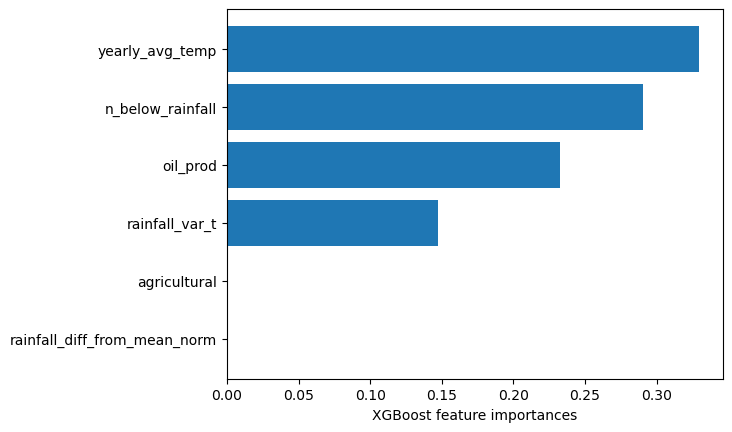

In [161]:
print(grid.best_params_, grid_cv.best_score_)
best_model = grid.best_estimator_.named_steps['xgb']
sorted_idx = best_model.estimator.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model.estimator.feature_importances_[sorted_idx])
plt.xlabel('XGBoost feature importances')
plt.plot()

[0]	validation_0-rmse:0.07224
[1]	validation_0-rmse:0.07208
[2]	validation_0-rmse:0.07206
[3]	validation_0-rmse:0.07196
[4]	validation_0-rmse:0.07195
[5]	validation_0-rmse:0.07188
[6]	validation_0-rmse:0.07184
[7]	validation_0-rmse:0.07184
[8]	validation_0-rmse:0.07183
[9]	validation_0-rmse:0.07185
[0]	validation_0-rmse:0.07125
[1]	validation_0-rmse:0.07125
[2]	validation_0-rmse:0.07125
[3]	validation_0-rmse:0.07126
[4]	validation_0-rmse:0.07126
[5]	validation_0-rmse:0.07127
[6]	validation_0-rmse:0.07127
[7]	validation_0-rmse:0.07129
[8]	validation_0-rmse:0.07132


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[9]	validation_0-rmse:0.07132
[0]	validation_0-rmse:0.06906
[1]	validation_0-rmse:0.06906
[2]	validation_0-rmse:0.06906
[3]	validation_0-rmse:0.06904
[4]	validation_0-rmse:0.06905
[5]	validation_0-rmse:0.06904
[6]	validation_0-rmse:0.06903
[7]	validation_0-rmse:0.06904
[8]	validation_0-rmse:0.06904
[9]	validation_0-rmse:0.06903
[0]	validation_0-rmse:0.07402
[1]	validation_0-rmse:0.07402
[2]	validation_0-rmse:0.07409
[3]	validation_0-rmse:0.07409
[4]	validation_0-rmse:0.07401
[5]	validation_0-rmse:0.07405
[6]	validation_0-rmse:0.07408


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[7]	validation_0-rmse:0.07408
[8]	validation_0-rmse:0.07410
[9]	validation_0-rmse:0.07407
[0]	validation_0-rmse:0.06940
[1]	validation_0-rmse:0.06940
[2]	validation_0-rmse:0.06940
[3]	validation_0-rmse:0.06940
[4]	validation_0-rmse:0.06942
[5]	validation_0-rmse:0.06939
[6]	validation_0-rmse:0.06939
[7]	validation_0-rmse:0.06940
[8]	validation_0-rmse:0.06941
[9]	validation_0-rmse:0.06941
[0]	validation_0-rmse:0.06170
[1]	validation_0-rmse:0.06170
[2]	validation_0-rmse:0.06170
[3]	validation_0-rmse:0.06166
[4]	validation_0-rmse:0.06166
[5]	validation_0-rmse:0.06166
[6]	validation_0-rmse:0.06163


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[7]	validation_0-rmse:0.06161
[8]	validation_0-rmse:0.06161
[9]	validation_0-rmse:0.06161
[10]	validation_0-rmse:0.06161
[11]	validation_0-rmse:0.06159
[12]	validation_0-rmse:0.06158
[13]	validation_0-rmse:0.06158
[14]	validation_0-rmse:0.06157
[15]	validation_0-rmse:0.06158
[16]	validation_0-rmse:0.06160
[17]	validation_0-rmse:0.06158
[18]	validation_0-rmse:0.06158
[19]	validation_0-rmse:0.06158
[20]	validation_0-rmse:0.06160
[21]	validation_0-rmse:0.06160
[22]	validation_0-rmse:0.06159
[23]	validation_0-rmse:0.06159
[24]	validation_0-rmse:0.06158
[25]	validation_0-rmse:0.06158
[26]	validation_0-rmse:0.06157
[27]	validation_0-rmse:0.06159
[28]	validation_0-rmse:0.06159
[29]	validation_0-rmse:0.06160
[30]	validation_0-rmse:0.06158
[31]	validation_0-rmse:0.06158
[32]	validation_0-rmse:0.06156
[33]	validation_0-rmse:0.06157
[34]	validation_0-rmse:0.06157
[35]	validation_0-rmse:0.06157
[36]	validation_0-rmse:0.06156
[37]	validation_0-rmse:0.06157
[38]	validation_0-rmse:0.06159
[39]	valida

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[37]	validation_0-rmse:0.06329
[38]	validation_0-rmse:0.06329
[39]	validation_0-rmse:0.06330
[40]	validation_0-rmse:0.06330
[41]	validation_0-rmse:0.06330
[42]	validation_0-rmse:0.06330
[43]	validation_0-rmse:0.06330
[44]	validation_0-rmse:0.06329
[45]	validation_0-rmse:0.06328
[46]	validation_0-rmse:0.06328
[47]	validation_0-rmse:0.06328
[48]	validation_0-rmse:0.06327
[49]	validation_0-rmse:0.06327
[50]	validation_0-rmse:0.06327
[51]	validation_0-rmse:0.06327
[52]	validation_0-rmse:0.06327
[53]	validation_0-rmse:0.06327
[54]	validation_0-rmse:0.06327
[55]	validation_0-rmse:0.06327
[56]	validation_0-rmse:0.06325
[57]	validation_0-rmse:0.06326
[58]	validation_0-rmse:0.06326
[59]	validation_0-rmse:0.06326
[60]	validation_0-rmse:0.06324
[61]	validation_0-rmse:0.06323
[62]	validation_0-rmse:0.06325
[63]	validation_0-rmse:0.06326
[64]	validation_0-rmse:0.06326
[65]	validation_0-rmse:0.06325
[66]	validation_0-rmse:0.06325
[67]	validation_0-rmse:0.06324
[68]	validation_0-rmse:0.06325
[69]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[38]	validation_0-rmse:0.07307
[39]	validation_0-rmse:0.07307
[40]	validation_0-rmse:0.07306
[41]	validation_0-rmse:0.07308
[42]	validation_0-rmse:0.07307
[43]	validation_0-rmse:0.07307
[44]	validation_0-rmse:0.07307
[45]	validation_0-rmse:0.07307
[46]	validation_0-rmse:0.07307
[47]	validation_0-rmse:0.07307
[48]	validation_0-rmse:0.07306
[49]	validation_0-rmse:0.07306
[50]	validation_0-rmse:0.07306
[51]	validation_0-rmse:0.07306
[52]	validation_0-rmse:0.07306
[53]	validation_0-rmse:0.07306
[54]	validation_0-rmse:0.07307
[55]	validation_0-rmse:0.07307
[56]	validation_0-rmse:0.07307
[57]	validation_0-rmse:0.07306
[58]	validation_0-rmse:0.07305
[59]	validation_0-rmse:0.07306
[60]	validation_0-rmse:0.07305
[61]	validation_0-rmse:0.07305
[62]	validation_0-rmse:0.07305
[63]	validation_0-rmse:0.07305
[64]	validation_0-rmse:0.07304
[65]	validation_0-rmse:0.07305
[66]	validation_0-rmse:0.07305
[67]	validation_0-rmse:0.07305
[68]	validation_0-rmse:0.07305
[69]	validation_0-rmse:0.07305
[70]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.06432
[32]	validation_0-rmse:0.06432
[33]	validation_0-rmse:0.06432
[34]	validation_0-rmse:0.06431
[35]	validation_0-rmse:0.06432
[36]	validation_0-rmse:0.06431
[37]	validation_0-rmse:0.06432
[38]	validation_0-rmse:0.06431
[39]	validation_0-rmse:0.06432
[40]	validation_0-rmse:0.06431
[41]	validation_0-rmse:0.06431
[42]	validation_0-rmse:0.06433
[43]	validation_0-rmse:0.06432
[44]	validation_0-rmse:0.06430
[45]	validation_0-rmse:0.06430
[46]	validation_0-rmse:0.06431
[47]	validation_0-rmse:0.06430
[48]	validation_0-rmse:0.06431
[49]	validation_0-rmse:0.06431
[50]	validation_0-rmse:0.06431
[51]	validation_0-rmse:0.06432
[52]	validation_0-rmse:0.06433
[53]	validation_0-rmse:0.06433
[54]	validation_0-rmse:0.06432
[55]	validation_0-rmse:0.06430
[56]	validation_0-rmse:0.06431
[57]	validation_0-rmse:0.06430
[58]	validation_0-rmse:0.06431
[59]	validation_0-rmse:0.06430
[60]	validation_0-rmse:0.06430
[61]	validation_0-rmse:0.06430
[62]	validation_0-rmse:0.06430
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[28]	validation_0-rmse:0.06490
[29]	validation_0-rmse:0.06489
[30]	validation_0-rmse:0.06490
[31]	validation_0-rmse:0.06503
[32]	validation_0-rmse:0.06505
[33]	validation_0-rmse:0.06505
[34]	validation_0-rmse:0.06503
[35]	validation_0-rmse:0.06504
[36]	validation_0-rmse:0.06506
[37]	validation_0-rmse:0.06506
[38]	validation_0-rmse:0.06507
[39]	validation_0-rmse:0.06507
[40]	validation_0-rmse:0.06507
[41]	validation_0-rmse:0.06506
[42]	validation_0-rmse:0.06507
[43]	validation_0-rmse:0.06507
[44]	validation_0-rmse:0.06506
[45]	validation_0-rmse:0.06507
[46]	validation_0-rmse:0.06506
[47]	validation_0-rmse:0.06506
[48]	validation_0-rmse:0.06506
[49]	validation_0-rmse:0.06507
[50]	validation_0-rmse:0.06506
[51]	validation_0-rmse:0.06506
[52]	validation_0-rmse:0.06517
[53]	validation_0-rmse:0.06518
[54]	validation_0-rmse:0.06517
[55]	validation_0-rmse:0.06518
[56]	validation_0-rmse:0.06518
[57]	validation_0-rmse:0.06518
[58]	validation_0-rmse:0.06519
[59]	validation_0-rmse:0.06520
[60]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[35]	validation_0-rmse:0.06674
[36]	validation_0-rmse:0.06675
[37]	validation_0-rmse:0.06673
[38]	validation_0-rmse:0.06673
[39]	validation_0-rmse:0.06673
[40]	validation_0-rmse:0.06672
[41]	validation_0-rmse:0.06672
[42]	validation_0-rmse:0.06672
[43]	validation_0-rmse:0.06673
[44]	validation_0-rmse:0.06674
[45]	validation_0-rmse:0.06674
[46]	validation_0-rmse:0.06674
[47]	validation_0-rmse:0.06674
[48]	validation_0-rmse:0.06674
[49]	validation_0-rmse:0.06674
[50]	validation_0-rmse:0.06674
[51]	validation_0-rmse:0.06674
[52]	validation_0-rmse:0.06675
[53]	validation_0-rmse:0.06676
[54]	validation_0-rmse:0.06675
[55]	validation_0-rmse:0.06675
[56]	validation_0-rmse:0.06675
[57]	validation_0-rmse:0.06675
[58]	validation_0-rmse:0.06674
[59]	validation_0-rmse:0.06674
[60]	validation_0-rmse:0.06675
[61]	validation_0-rmse:0.06676
[62]	validation_0-rmse:0.06676
[63]	validation_0-rmse:0.06677
[64]	validation_0-rmse:0.06678
[65]	validation_0-rmse:0.06678
[66]	validation_0-rmse:0.06677
[67]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[96]	validation_0-rmse:0.06609
[97]	validation_0-rmse:0.06609
[98]	validation_0-rmse:0.06609
[99]	validation_0-rmse:0.06609
[100]	validation_0-rmse:0.06609
[101]	validation_0-rmse:0.06609
[102]	validation_0-rmse:0.06611
[103]	validation_0-rmse:0.06611
[104]	validation_0-rmse:0.06612
[105]	validation_0-rmse:0.06611
[106]	validation_0-rmse:0.06611
[107]	validation_0-rmse:0.06612
[108]	validation_0-rmse:0.06612
[109]	validation_0-rmse:0.06615
[110]	validation_0-rmse:0.06615
[111]	validation_0-rmse:0.06615
[112]	validation_0-rmse:0.06615
[113]	validation_0-rmse:0.06615
[114]	validation_0-rmse:0.06615
[115]	validation_0-rmse:0.06615
[116]	validation_0-rmse:0.06616
[117]	validation_0-rmse:0.06616
[118]	validation_0-rmse:0.06616
[119]	validation_0-rmse:0.06614
[120]	validation_0-rmse:0.06614
[121]	validation_0-rmse:0.06615
[122]	validation_0-rmse:0.06616
[123]	validation_0-rmse:0.06616
[124]	validation_0-rmse:0.06617
[125]	validation_0-rmse:0.06616
[126]	validation_0-rmse:0.06617
[127]	valida

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[39]	validation_0-rmse:0.06225
[40]	validation_0-rmse:0.06225
[41]	validation_0-rmse:0.06225
[42]	validation_0-rmse:0.06226
[43]	validation_0-rmse:0.06225
[44]	validation_0-rmse:0.06226
[45]	validation_0-rmse:0.06225
[46]	validation_0-rmse:0.06225
[47]	validation_0-rmse:0.06225
[48]	validation_0-rmse:0.06225
[49]	validation_0-rmse:0.06225
[50]	validation_0-rmse:0.06225
[51]	validation_0-rmse:0.06226
[52]	validation_0-rmse:0.06227
[53]	validation_0-rmse:0.06227
[54]	validation_0-rmse:0.06226
[55]	validation_0-rmse:0.06227
[56]	validation_0-rmse:0.06227
[57]	validation_0-rmse:0.06228
[58]	validation_0-rmse:0.06227
[59]	validation_0-rmse:0.06228
[60]	validation_0-rmse:0.06228
[61]	validation_0-rmse:0.06227
[62]	validation_0-rmse:0.06227
[63]	validation_0-rmse:0.06228
[64]	validation_0-rmse:0.06227
[65]	validation_0-rmse:0.06227
[66]	validation_0-rmse:0.06227
[67]	validation_0-rmse:0.06226
[68]	validation_0-rmse:0.06227
[69]	validation_0-rmse:0.06228
[70]	validation_0-rmse:0.06227
[71]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[30]	validation_0-rmse:0.06111
[31]	validation_0-rmse:0.06110
[32]	validation_0-rmse:0.06112
[33]	validation_0-rmse:0.06114
[34]	validation_0-rmse:0.06115
[35]	validation_0-rmse:0.06117
[36]	validation_0-rmse:0.06117
[37]	validation_0-rmse:0.06118
[38]	validation_0-rmse:0.06116
[39]	validation_0-rmse:0.06118
[40]	validation_0-rmse:0.06119
[41]	validation_0-rmse:0.06120
[42]	validation_0-rmse:0.06118
[43]	validation_0-rmse:0.06119
[44]	validation_0-rmse:0.06120
[45]	validation_0-rmse:0.06120
[46]	validation_0-rmse:0.06121
[47]	validation_0-rmse:0.06120
[48]	validation_0-rmse:0.06121
[49]	validation_0-rmse:0.06119
[50]	validation_0-rmse:0.06120
[51]	validation_0-rmse:0.06116
[52]	validation_0-rmse:0.06118
[53]	validation_0-rmse:0.06118
[54]	validation_0-rmse:0.06117
[55]	validation_0-rmse:0.06118
[56]	validation_0-rmse:0.06117
[57]	validation_0-rmse:0.06119
[58]	validation_0-rmse:0.06119
[59]	validation_0-rmse:0.06120
[60]	validation_0-rmse:0.06120
[61]	validation_0-rmse:0.06121
[62]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[29]	validation_0-rmse:0.07628
[30]	validation_0-rmse:0.07628
[31]	validation_0-rmse:0.07626
[32]	validation_0-rmse:0.07626
[33]	validation_0-rmse:0.07628
[34]	validation_0-rmse:0.07627
[35]	validation_0-rmse:0.07628
[36]	validation_0-rmse:0.07628
[37]	validation_0-rmse:0.07628
[38]	validation_0-rmse:0.07627
[39]	validation_0-rmse:0.07628
[40]	validation_0-rmse:0.07628
[41]	validation_0-rmse:0.07629
[42]	validation_0-rmse:0.07629
[43]	validation_0-rmse:0.07629
[44]	validation_0-rmse:0.07629
[45]	validation_0-rmse:0.07629
[46]	validation_0-rmse:0.07630
[47]	validation_0-rmse:0.07629
[48]	validation_0-rmse:0.07630
[49]	validation_0-rmse:0.07629
[50]	validation_0-rmse:0.07630
[51]	validation_0-rmse:0.07629
[52]	validation_0-rmse:0.07629
[53]	validation_0-rmse:0.07629
[54]	validation_0-rmse:0.07629
[55]	validation_0-rmse:0.07630
[56]	validation_0-rmse:0.07630
[57]	validation_0-rmse:0.07629
[58]	validation_0-rmse:0.07631
[59]	validation_0-rmse:0.07630
[60]	validation_0-rmse:0.07630
[61]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[4]	validation_0-rmse:0.07544
[5]	validation_0-rmse:0.07561
[6]	validation_0-rmse:0.07556
[7]	validation_0-rmse:0.07555
[8]	validation_0-rmse:0.07554
[9]	validation_0-rmse:0.07555
[0]	validation_0-rmse:0.05822
[1]	validation_0-rmse:0.05840
[2]	validation_0-rmse:0.05859
[3]	validation_0-rmse:0.05887
[4]	validation_0-rmse:0.05907
[5]	validation_0-rmse:0.05906
[6]	validation_0-rmse:0.05911
[7]	validation_0-rmse:0.05921
[8]	validation_0-rmse:0.05919
[9]	validation_0-rmse:0.05939
[0]	validation_0-rmse:0.06630
[1]	validation_0-rmse:0.06638
[2]	validation_0-rmse:0.06636
[3]	validation_0-rmse:0.06634
[4]	validation_0-rmse:0.06631


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[5]	validation_0-rmse:0.06640
[6]	validation_0-rmse:0.06636
[7]	validation_0-rmse:0.06636
[8]	validation_0-rmse:0.06631
[9]	validation_0-rmse:0.06641
[10]	validation_0-rmse:0.06641
[11]	validation_0-rmse:0.06641
[12]	validation_0-rmse:0.06639
[13]	validation_0-rmse:0.06637
[14]	validation_0-rmse:0.06637
[15]	validation_0-rmse:0.06632
[16]	validation_0-rmse:0.06632
[17]	validation_0-rmse:0.06630
[18]	validation_0-rmse:0.06635
[19]	validation_0-rmse:0.06636
[20]	validation_0-rmse:0.06642
[21]	validation_0-rmse:0.06638
[22]	validation_0-rmse:0.06649
[23]	validation_0-rmse:0.06649
[24]	validation_0-rmse:0.06658
[25]	validation_0-rmse:0.06658
[26]	validation_0-rmse:0.06660
[27]	validation_0-rmse:0.06660
[28]	validation_0-rmse:0.06663
[29]	validation_0-rmse:0.06663
[30]	validation_0-rmse:0.06664
[31]	validation_0-rmse:0.06664
[32]	validation_0-rmse:0.06665
[33]	validation_0-rmse:0.06670
[34]	validation_0-rmse:0.06666
[35]	validation_0-rmse:0.06666
[36]	validation_0-rmse:0.06671
[37]	validati

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[46]	validation_0-rmse:0.06613
[47]	validation_0-rmse:0.06612
[48]	validation_0-rmse:0.06616
[49]	validation_0-rmse:0.06615
[50]	validation_0-rmse:0.06610
[51]	validation_0-rmse:0.06611
[52]	validation_0-rmse:0.06612
[53]	validation_0-rmse:0.06610
[54]	validation_0-rmse:0.06606
[55]	validation_0-rmse:0.06601
[56]	validation_0-rmse:0.06604
[57]	validation_0-rmse:0.06605
[58]	validation_0-rmse:0.06608
[59]	validation_0-rmse:0.06611
[60]	validation_0-rmse:0.06612
[61]	validation_0-rmse:0.06615
[62]	validation_0-rmse:0.06609
[63]	validation_0-rmse:0.06611
[64]	validation_0-rmse:0.06614
[65]	validation_0-rmse:0.06613
[66]	validation_0-rmse:0.06621
[67]	validation_0-rmse:0.06620
[68]	validation_0-rmse:0.06624
[69]	validation_0-rmse:0.06623
[70]	validation_0-rmse:0.06634
[71]	validation_0-rmse:0.06636
[72]	validation_0-rmse:0.06636
[73]	validation_0-rmse:0.06638
[74]	validation_0-rmse:0.06640
[75]	validation_0-rmse:0.06641
[76]	validation_0-rmse:0.06652
[77]	validation_0-rmse:0.06658
[78]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[26]	validation_0-rmse:0.06132
[27]	validation_0-rmse:0.06138
[28]	validation_0-rmse:0.06141
[29]	validation_0-rmse:0.06144
[30]	validation_0-rmse:0.06146
[31]	validation_0-rmse:0.06148
[32]	validation_0-rmse:0.06152
[33]	validation_0-rmse:0.06157
[34]	validation_0-rmse:0.06173
[35]	validation_0-rmse:0.06175
[36]	validation_0-rmse:0.06175
[37]	validation_0-rmse:0.06178
[38]	validation_0-rmse:0.06184
[39]	validation_0-rmse:0.06185
[40]	validation_0-rmse:0.06184
[41]	validation_0-rmse:0.06183
[42]	validation_0-rmse:0.06190
[43]	validation_0-rmse:0.06187
[44]	validation_0-rmse:0.06188
[45]	validation_0-rmse:0.06189
[46]	validation_0-rmse:0.06191
[47]	validation_0-rmse:0.06198
[48]	validation_0-rmse:0.06198
[49]	validation_0-rmse:0.06197
[50]	validation_0-rmse:0.06200
[51]	validation_0-rmse:0.06202
[52]	validation_0-rmse:0.06207
[53]	validation_0-rmse:0.06210
[54]	validation_0-rmse:0.06210
[55]	validation_0-rmse:0.06213
[56]	validation_0-rmse:0.06212
[57]	validation_0-rmse:0.06215
[58]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.06021
[32]	validation_0-rmse:0.06023
[33]	validation_0-rmse:0.06029
[34]	validation_0-rmse:0.06047
[35]	validation_0-rmse:0.06050
[36]	validation_0-rmse:0.06051
[37]	validation_0-rmse:0.06065
[38]	validation_0-rmse:0.06068
[39]	validation_0-rmse:0.06067
[40]	validation_0-rmse:0.06066
[41]	validation_0-rmse:0.06066
[42]	validation_0-rmse:0.06067
[43]	validation_0-rmse:0.06062
[44]	validation_0-rmse:0.06067
[45]	validation_0-rmse:0.06066
[46]	validation_0-rmse:0.06068
[47]	validation_0-rmse:0.06070
[48]	validation_0-rmse:0.06077
[49]	validation_0-rmse:0.06098
[50]	validation_0-rmse:0.06100
[51]	validation_0-rmse:0.06097
[52]	validation_0-rmse:0.06100
[53]	validation_0-rmse:0.06100
[54]	validation_0-rmse:0.06095
[55]	validation_0-rmse:0.06096
[56]	validation_0-rmse:0.06099
[57]	validation_0-rmse:0.06104
[58]	validation_0-rmse:0.06110
[59]	validation_0-rmse:0.06115
[60]	validation_0-rmse:0.06119
[61]	validation_0-rmse:0.06123
[62]	validation_0-rmse:0.06128
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[29]	validation_0-rmse:0.06579
[30]	validation_0-rmse:0.06579
[31]	validation_0-rmse:0.06579
[32]	validation_0-rmse:0.06578
[33]	validation_0-rmse:0.06575
[34]	validation_0-rmse:0.06574
[35]	validation_0-rmse:0.06574
[36]	validation_0-rmse:0.06577
[37]	validation_0-rmse:0.06575
[38]	validation_0-rmse:0.06583
[39]	validation_0-rmse:0.06581
[40]	validation_0-rmse:0.06580
[41]	validation_0-rmse:0.06582
[42]	validation_0-rmse:0.06584
[43]	validation_0-rmse:0.06585
[44]	validation_0-rmse:0.06588
[45]	validation_0-rmse:0.06593
[46]	validation_0-rmse:0.06595
[47]	validation_0-rmse:0.06599
[48]	validation_0-rmse:0.06596
[49]	validation_0-rmse:0.06596
[50]	validation_0-rmse:0.06598
[51]	validation_0-rmse:0.06597
[52]	validation_0-rmse:0.06600
[53]	validation_0-rmse:0.06600
[54]	validation_0-rmse:0.06603
[55]	validation_0-rmse:0.06605
[56]	validation_0-rmse:0.06605
[57]	validation_0-rmse:0.06613
[58]	validation_0-rmse:0.06609
[59]	validation_0-rmse:0.06610
[60]	validation_0-rmse:0.06609
[61]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[37]	validation_0-rmse:0.06630
[38]	validation_0-rmse:0.06634
[39]	validation_0-rmse:0.06639
[40]	validation_0-rmse:0.06638
[41]	validation_0-rmse:0.06641
[42]	validation_0-rmse:0.06637
[43]	validation_0-rmse:0.06639
[44]	validation_0-rmse:0.06640
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06636
[47]	validation_0-rmse:0.06637
[48]	validation_0-rmse:0.06642
[49]	validation_0-rmse:0.06644
[50]	validation_0-rmse:0.06647
[51]	validation_0-rmse:0.06648
[52]	validation_0-rmse:0.06649
[53]	validation_0-rmse:0.06645
[54]	validation_0-rmse:0.06654
[55]	validation_0-rmse:0.06654
[56]	validation_0-rmse:0.06657
[57]	validation_0-rmse:0.06657
[58]	validation_0-rmse:0.06658
[59]	validation_0-rmse:0.06659
[60]	validation_0-rmse:0.06661
[61]	validation_0-rmse:0.06662
[62]	validation_0-rmse:0.06660
[63]	validation_0-rmse:0.06661
[64]	validation_0-rmse:0.06664
[65]	validation_0-rmse:0.06658
[66]	validation_0-rmse:0.06657
[67]	validation_0-rmse:0.06659
[68]	validation_0-rmse:0.06664
[69]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[36]	validation_0-rmse:0.07233
[37]	validation_0-rmse:0.07232
[38]	validation_0-rmse:0.07233
[39]	validation_0-rmse:0.07233
[40]	validation_0-rmse:0.07234
[41]	validation_0-rmse:0.07227
[42]	validation_0-rmse:0.07231
[43]	validation_0-rmse:0.07228
[44]	validation_0-rmse:0.07231
[45]	validation_0-rmse:0.07229
[46]	validation_0-rmse:0.07231
[47]	validation_0-rmse:0.07230
[48]	validation_0-rmse:0.07232
[49]	validation_0-rmse:0.07235
[50]	validation_0-rmse:0.07239
[51]	validation_0-rmse:0.07229
[52]	validation_0-rmse:0.07230
[53]	validation_0-rmse:0.07229
[54]	validation_0-rmse:0.07234
[55]	validation_0-rmse:0.07230
[56]	validation_0-rmse:0.07231
[57]	validation_0-rmse:0.07243
[58]	validation_0-rmse:0.07244
[59]	validation_0-rmse:0.07254
[60]	validation_0-rmse:0.07255
[61]	validation_0-rmse:0.07256
[62]	validation_0-rmse:0.07254
[63]	validation_0-rmse:0.07255
[64]	validation_0-rmse:0.07253
[65]	validation_0-rmse:0.07253
[66]	validation_0-rmse:0.07250
[67]	validation_0-rmse:0.07250
[68]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[28]	validation_0-rmse:0.06609
[29]	validation_0-rmse:0.06609
[30]	validation_0-rmse:0.06608
[31]	validation_0-rmse:0.06611
[32]	validation_0-rmse:0.06613
[33]	validation_0-rmse:0.06611
[34]	validation_0-rmse:0.06610
[35]	validation_0-rmse:0.06613
[36]	validation_0-rmse:0.06611
[37]	validation_0-rmse:0.06615
[38]	validation_0-rmse:0.06614
[39]	validation_0-rmse:0.06623
[40]	validation_0-rmse:0.06622
[41]	validation_0-rmse:0.06626
[42]	validation_0-rmse:0.06631
[43]	validation_0-rmse:0.06633
[44]	validation_0-rmse:0.06636
[45]	validation_0-rmse:0.06636
[46]	validation_0-rmse:0.06632
[47]	validation_0-rmse:0.06637
[48]	validation_0-rmse:0.06637
[49]	validation_0-rmse:0.06638
[50]	validation_0-rmse:0.06638
[51]	validation_0-rmse:0.06638
[52]	validation_0-rmse:0.06640
[53]	validation_0-rmse:0.06639
[54]	validation_0-rmse:0.06640
[55]	validation_0-rmse:0.06634
[56]	validation_0-rmse:0.06639
[57]	validation_0-rmse:0.06639
[58]	validation_0-rmse:0.06639
[59]	validation_0-rmse:0.06641
[60]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[34]	validation_0-rmse:0.06247
[35]	validation_0-rmse:0.06253
[36]	validation_0-rmse:0.06260
[37]	validation_0-rmse:0.06259
[38]	validation_0-rmse:0.06269
[39]	validation_0-rmse:0.06271
[40]	validation_0-rmse:0.06271
[41]	validation_0-rmse:0.06276
[42]	validation_0-rmse:0.06280
[43]	validation_0-rmse:0.06283
[44]	validation_0-rmse:0.06285
[45]	validation_0-rmse:0.06288
[46]	validation_0-rmse:0.06285
[47]	validation_0-rmse:0.06292
[48]	validation_0-rmse:0.06296
[49]	validation_0-rmse:0.06296
[50]	validation_0-rmse:0.06297
[51]	validation_0-rmse:0.06303
[52]	validation_0-rmse:0.06307
[53]	validation_0-rmse:0.06311
[54]	validation_0-rmse:0.06327
[55]	validation_0-rmse:0.06322
[56]	validation_0-rmse:0.06322
[57]	validation_0-rmse:0.06335
[58]	validation_0-rmse:0.06333
[59]	validation_0-rmse:0.06334
[60]	validation_0-rmse:0.06344
[61]	validation_0-rmse:0.06342
[62]	validation_0-rmse:0.06339
[63]	validation_0-rmse:0.06343
[64]	validation_0-rmse:0.06337
[65]	validation_0-rmse:0.06340
[66]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[20]	validation_0-rmse:0.06749
[21]	validation_0-rmse:0.06744
[22]	validation_0-rmse:0.06747
[23]	validation_0-rmse:0.06743
[24]	validation_0-rmse:0.06746
[25]	validation_0-rmse:0.06745
[26]	validation_0-rmse:0.06749
[27]	validation_0-rmse:0.06749
[28]	validation_0-rmse:0.06755
[29]	validation_0-rmse:0.06759
[30]	validation_0-rmse:0.06761
[31]	validation_0-rmse:0.06774
[32]	validation_0-rmse:0.06779
[33]	validation_0-rmse:0.06780
[34]	validation_0-rmse:0.06779
[35]	validation_0-rmse:0.06779
[36]	validation_0-rmse:0.06777
[37]	validation_0-rmse:0.06781
[38]	validation_0-rmse:0.06787
[39]	validation_0-rmse:0.06789
[40]	validation_0-rmse:0.06792
[41]	validation_0-rmse:0.06797
[42]	validation_0-rmse:0.06800
[43]	validation_0-rmse:0.06796
[44]	validation_0-rmse:0.06797
[45]	validation_0-rmse:0.06799
[46]	validation_0-rmse:0.06802
[47]	validation_0-rmse:0.06802
[48]	validation_0-rmse:0.06806
[49]	validation_0-rmse:0.06801
[50]	validation_0-rmse:0.06802
[51]	validation_0-rmse:0.06801
[52]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[1]	validation_0-rmse:0.06794
[2]	validation_0-rmse:0.06798
[3]	validation_0-rmse:0.06797
[4]	validation_0-rmse:0.06790
[5]	validation_0-rmse:0.06798
[6]	validation_0-rmse:0.06803
[7]	validation_0-rmse:0.06807
[8]	validation_0-rmse:0.06813
[9]	validation_0-rmse:0.06816
[0]	validation_0-rmse:0.07113
[1]	validation_0-rmse:0.07116
[2]	validation_0-rmse:0.07121
[3]	validation_0-rmse:0.07141
[4]	validation_0-rmse:0.07136
[5]	validation_0-rmse:0.07139
[6]	validation_0-rmse:0.07141
[7]	validation_0-rmse:0.07145
[8]	validation_0-rmse:0.07142
[9]	validation_0-rmse:0.07143
[0]	validation_0-rmse:0.07128
[1]	validation_0-rmse:0.07125
[2]	validation_0-rmse:0.07131
[3]	validation_0-rmse:0.07131
[4]	validation_0-rmse:0.07130
[5]	validation_0-rmse:0.07128
[6]	validation_0-rmse:0.07132
[7]	validation_0-rmse:0.07135


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[8]	validation_0-rmse:0.07134
[9]	validation_0-rmse:0.07133
[10]	validation_0-rmse:0.07164
[11]	validation_0-rmse:0.07185
[12]	validation_0-rmse:0.07185
[13]	validation_0-rmse:0.07183
[14]	validation_0-rmse:0.07246
[15]	validation_0-rmse:0.07252
[16]	validation_0-rmse:0.07252
[17]	validation_0-rmse:0.07250
[18]	validation_0-rmse:0.07252
[19]	validation_0-rmse:0.07265
[20]	validation_0-rmse:0.07271
[21]	validation_0-rmse:0.07275
[22]	validation_0-rmse:0.07276
[23]	validation_0-rmse:0.07288
[24]	validation_0-rmse:0.07288
[25]	validation_0-rmse:0.07292
[26]	validation_0-rmse:0.07287
[27]	validation_0-rmse:0.07296
[28]	validation_0-rmse:0.07309
[29]	validation_0-rmse:0.07315
[30]	validation_0-rmse:0.07313
[31]	validation_0-rmse:0.07320
[32]	validation_0-rmse:0.07320
[33]	validation_0-rmse:0.07331
[34]	validation_0-rmse:0.07334
[35]	validation_0-rmse:0.07330
[36]	validation_0-rmse:0.07330
[37]	validation_0-rmse:0.07331
[38]	validation_0-rmse:0.07321
[39]	validation_0-rmse:0.07322
[40]	valid

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[28]	validation_0-rmse:0.08311
[29]	validation_0-rmse:0.08306
[30]	validation_0-rmse:0.08322
[31]	validation_0-rmse:0.08325
[32]	validation_0-rmse:0.08340
[33]	validation_0-rmse:0.08344
[34]	validation_0-rmse:0.08372
[35]	validation_0-rmse:0.08377
[36]	validation_0-rmse:0.08370
[37]	validation_0-rmse:0.08371
[38]	validation_0-rmse:0.08372
[39]	validation_0-rmse:0.08379
[40]	validation_0-rmse:0.08379
[41]	validation_0-rmse:0.08385
[42]	validation_0-rmse:0.08388
[43]	validation_0-rmse:0.08390
[44]	validation_0-rmse:0.08393
[45]	validation_0-rmse:0.08400
[46]	validation_0-rmse:0.08405
[47]	validation_0-rmse:0.08405
[48]	validation_0-rmse:0.08401
[49]	validation_0-rmse:0.08412
[50]	validation_0-rmse:0.08414
[51]	validation_0-rmse:0.08415
[52]	validation_0-rmse:0.08431
[53]	validation_0-rmse:0.08431
[54]	validation_0-rmse:0.08430
[55]	validation_0-rmse:0.08425
[56]	validation_0-rmse:0.08425
[57]	validation_0-rmse:0.08425
[58]	validation_0-rmse:0.08424
[59]	validation_0-rmse:0.08422
[60]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[35]	validation_0-rmse:0.05903
[36]	validation_0-rmse:0.05903
[37]	validation_0-rmse:0.05904
[38]	validation_0-rmse:0.05917
[39]	validation_0-rmse:0.05911
[40]	validation_0-rmse:0.05914
[41]	validation_0-rmse:0.05919
[42]	validation_0-rmse:0.05953
[43]	validation_0-rmse:0.05958
[44]	validation_0-rmse:0.05963
[45]	validation_0-rmse:0.05964
[46]	validation_0-rmse:0.05968
[47]	validation_0-rmse:0.05972
[48]	validation_0-rmse:0.05977
[49]	validation_0-rmse:0.05975
[50]	validation_0-rmse:0.05980
[51]	validation_0-rmse:0.05975
[52]	validation_0-rmse:0.05976
[53]	validation_0-rmse:0.05979
[54]	validation_0-rmse:0.05987
[55]	validation_0-rmse:0.05993
[56]	validation_0-rmse:0.06014
[57]	validation_0-rmse:0.06031
[58]	validation_0-rmse:0.06031
[59]	validation_0-rmse:0.06035
[60]	validation_0-rmse:0.06025
[61]	validation_0-rmse:0.06023
[62]	validation_0-rmse:0.06024
[63]	validation_0-rmse:0.06026
[64]	validation_0-rmse:0.06032
[65]	validation_0-rmse:0.06029
[66]	validation_0-rmse:0.06036
[67]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[31]	validation_0-rmse:0.05684
[32]	validation_0-rmse:0.05685
[33]	validation_0-rmse:0.05693
[34]	validation_0-rmse:0.05697
[35]	validation_0-rmse:0.05699
[36]	validation_0-rmse:0.05705
[37]	validation_0-rmse:0.05709
[38]	validation_0-rmse:0.05716
[39]	validation_0-rmse:0.05722
[40]	validation_0-rmse:0.05751
[41]	validation_0-rmse:0.05751
[42]	validation_0-rmse:0.05750
[43]	validation_0-rmse:0.05749
[44]	validation_0-rmse:0.05756
[45]	validation_0-rmse:0.05764
[46]	validation_0-rmse:0.05769
[47]	validation_0-rmse:0.05839
[48]	validation_0-rmse:0.05839
[49]	validation_0-rmse:0.05839
[50]	validation_0-rmse:0.05842
[51]	validation_0-rmse:0.05836
[52]	validation_0-rmse:0.05837
[53]	validation_0-rmse:0.05836
[54]	validation_0-rmse:0.05832
[55]	validation_0-rmse:0.05843
[56]	validation_0-rmse:0.05845
[57]	validation_0-rmse:0.05875
[58]	validation_0-rmse:0.05893
[59]	validation_0-rmse:0.05903
[60]	validation_0-rmse:0.05903
[61]	validation_0-rmse:0.05917
[62]	validation_0-rmse:0.05915
[63]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[33]	validation_0-rmse:0.06283
[34]	validation_0-rmse:0.06280
[35]	validation_0-rmse:0.06296
[36]	validation_0-rmse:0.06293
[37]	validation_0-rmse:0.06303
[38]	validation_0-rmse:0.06316
[39]	validation_0-rmse:0.06330
[40]	validation_0-rmse:0.06338
[41]	validation_0-rmse:0.06356
[42]	validation_0-rmse:0.06378
[43]	validation_0-rmse:0.06386
[44]	validation_0-rmse:0.06387
[45]	validation_0-rmse:0.06390
[46]	validation_0-rmse:0.06403
[47]	validation_0-rmse:0.06444
[48]	validation_0-rmse:0.06442
[49]	validation_0-rmse:0.06451
[50]	validation_0-rmse:0.06449
[51]	validation_0-rmse:0.06446
[52]	validation_0-rmse:0.06456
[53]	validation_0-rmse:0.06459
[54]	validation_0-rmse:0.06467
[55]	validation_0-rmse:0.06477
[56]	validation_0-rmse:0.06477
[57]	validation_0-rmse:0.06478
[58]	validation_0-rmse:0.06485
[59]	validation_0-rmse:0.06496
[60]	validation_0-rmse:0.06492
[61]	validation_0-rmse:0.06498
[62]	validation_0-rmse:0.06503
[63]	validation_0-rmse:0.06511
[64]	validation_0-rmse:0.06520
[65]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[24]	validation_0-rmse:0.08460
[25]	validation_0-rmse:0.08467
[26]	validation_0-rmse:0.08470
[27]	validation_0-rmse:0.08485
[28]	validation_0-rmse:0.08499
[29]	validation_0-rmse:0.08498
[30]	validation_0-rmse:0.08499
[31]	validation_0-rmse:0.08506
[32]	validation_0-rmse:0.08501
[33]	validation_0-rmse:0.08492
[34]	validation_0-rmse:0.08499
[35]	validation_0-rmse:0.08509
[36]	validation_0-rmse:0.08515
[37]	validation_0-rmse:0.08513
[38]	validation_0-rmse:0.08516
[39]	validation_0-rmse:0.08524
[40]	validation_0-rmse:0.08536
[41]	validation_0-rmse:0.08536
[42]	validation_0-rmse:0.08539
[43]	validation_0-rmse:0.08534
[44]	validation_0-rmse:0.08540
[45]	validation_0-rmse:0.08540
[46]	validation_0-rmse:0.08541
[47]	validation_0-rmse:0.08546
[48]	validation_0-rmse:0.08544
[49]	validation_0-rmse:0.08546
[50]	validation_0-rmse:0.08553
[51]	validation_0-rmse:0.08555
[52]	validation_0-rmse:0.08560
[53]	validation_0-rmse:0.08569
[54]	validation_0-rmse:0.08571
[55]	validation_0-rmse:0.08572
[56]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.06149
[20]	validation_0-rmse:0.06158
[21]	validation_0-rmse:0.06189
[22]	validation_0-rmse:0.06196
[23]	validation_0-rmse:0.06200
[24]	validation_0-rmse:0.06207
[25]	validation_0-rmse:0.06211
[26]	validation_0-rmse:0.06210
[27]	validation_0-rmse:0.06217
[28]	validation_0-rmse:0.06228
[29]	validation_0-rmse:0.06227
[30]	validation_0-rmse:0.06227
[31]	validation_0-rmse:0.06262
[32]	validation_0-rmse:0.06263
[33]	validation_0-rmse:0.06261
[34]	validation_0-rmse:0.06268
[35]	validation_0-rmse:0.06273
[36]	validation_0-rmse:0.06276
[37]	validation_0-rmse:0.06291
[38]	validation_0-rmse:0.06293
[39]	validation_0-rmse:0.06306
[40]	validation_0-rmse:0.06308
[41]	validation_0-rmse:0.06314
[42]	validation_0-rmse:0.06325
[43]	validation_0-rmse:0.06337
[44]	validation_0-rmse:0.06375
[45]	validation_0-rmse:0.06372
[46]	validation_0-rmse:0.06376
[47]	validation_0-rmse:0.06386
[48]	validation_0-rmse:0.06391
[49]	validation_0-rmse:0.06393
[50]	validation_0-rmse:0.06395
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[25]	validation_0-rmse:0.07063
[26]	validation_0-rmse:0.07065
[27]	validation_0-rmse:0.07069
[28]	validation_0-rmse:0.07073
[29]	validation_0-rmse:0.07072
[30]	validation_0-rmse:0.07084
[31]	validation_0-rmse:0.07094
[32]	validation_0-rmse:0.07100
[33]	validation_0-rmse:0.07099
[34]	validation_0-rmse:0.07100
[35]	validation_0-rmse:0.07096
[36]	validation_0-rmse:0.07097
[37]	validation_0-rmse:0.07100
[38]	validation_0-rmse:0.07098
[39]	validation_0-rmse:0.07097
[40]	validation_0-rmse:0.07096
[41]	validation_0-rmse:0.07093
[42]	validation_0-rmse:0.07097
[43]	validation_0-rmse:0.07101
[44]	validation_0-rmse:0.07106
[45]	validation_0-rmse:0.07106
[46]	validation_0-rmse:0.07160
[47]	validation_0-rmse:0.07162
[48]	validation_0-rmse:0.07163
[49]	validation_0-rmse:0.07230
[50]	validation_0-rmse:0.07236
[51]	validation_0-rmse:0.07239
[52]	validation_0-rmse:0.07238
[53]	validation_0-rmse:0.07240
[54]	validation_0-rmse:0.07243
[55]	validation_0-rmse:0.07238
[56]	validation_0-rmse:0.07239
[57]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[30]	validation_0-rmse:0.06834
[31]	validation_0-rmse:0.06837
[32]	validation_0-rmse:0.06838
[33]	validation_0-rmse:0.06853
[34]	validation_0-rmse:0.06869
[35]	validation_0-rmse:0.06871
[36]	validation_0-rmse:0.06877
[37]	validation_0-rmse:0.06900
[38]	validation_0-rmse:0.06902
[39]	validation_0-rmse:0.06903
[40]	validation_0-rmse:0.06901
[41]	validation_0-rmse:0.06924
[42]	validation_0-rmse:0.06925
[43]	validation_0-rmse:0.06912
[44]	validation_0-rmse:0.06911
[45]	validation_0-rmse:0.06922
[46]	validation_0-rmse:0.06940
[47]	validation_0-rmse:0.06937
[48]	validation_0-rmse:0.06956
[49]	validation_0-rmse:0.06965
[50]	validation_0-rmse:0.06970
[51]	validation_0-rmse:0.06993
[52]	validation_0-rmse:0.06989
[53]	validation_0-rmse:0.06997
[54]	validation_0-rmse:0.06990
[55]	validation_0-rmse:0.06989
[56]	validation_0-rmse:0.06997
[57]	validation_0-rmse:0.06997
[58]	validation_0-rmse:0.06999
[59]	validation_0-rmse:0.07003
[60]	validation_0-rmse:0.07009
[61]	validation_0-rmse:0.07025
[62]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[26]	validation_0-rmse:0.06539
[27]	validation_0-rmse:0.06549
[28]	validation_0-rmse:0.06556
[29]	validation_0-rmse:0.06558
[30]	validation_0-rmse:0.06550
[31]	validation_0-rmse:0.06547
[32]	validation_0-rmse:0.06549
[33]	validation_0-rmse:0.06553
[34]	validation_0-rmse:0.06555
[35]	validation_0-rmse:0.06553
[36]	validation_0-rmse:0.06550
[37]	validation_0-rmse:0.06562
[38]	validation_0-rmse:0.06563
[39]	validation_0-rmse:0.06559
[40]	validation_0-rmse:0.06559
[41]	validation_0-rmse:0.06565
[42]	validation_0-rmse:0.06579
[43]	validation_0-rmse:0.06591
[44]	validation_0-rmse:0.06590
[45]	validation_0-rmse:0.06587
[46]	validation_0-rmse:0.06600
[47]	validation_0-rmse:0.06607
[48]	validation_0-rmse:0.06610
[49]	validation_0-rmse:0.06618
[50]	validation_0-rmse:0.06638
[51]	validation_0-rmse:0.06650
[52]	validation_0-rmse:0.06645
[53]	validation_0-rmse:0.06645
[54]	validation_0-rmse:0.06648
[55]	validation_0-rmse:0.06687
[56]	validation_0-rmse:0.06695
[57]	validation_0-rmse:0.06700
[58]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current 

[1]	validation_0-rmse:0.05868
[2]	validation_0-rmse:0.05923
[3]	validation_0-rmse:0.05976
[4]	validation_0-rmse:0.05981
[5]	validation_0-rmse:0.06012
[6]	validation_0-rmse:0.06047
[7]	validation_0-rmse:0.06099
[8]	validation_0-rmse:0.06135
[9]	validation_0-rmse:0.06157
[0]	validation_0-rmse:0.07222
[1]	validation_0-rmse:0.07286
[2]	validation_0-rmse:0.07310
[3]	validation_0-rmse:0.07353
[4]	validation_0-rmse:0.07391
[5]	validation_0-rmse:0.07420
[6]	validation_0-rmse:0.07432
[7]	validation_0-rmse:0.07450
[8]	validation_0-rmse:0.07480
[9]	validation_0-rmse:0.07518
[0]	validation_0-rmse:0.07825
[1]	validation_0-rmse:0.07875


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[2]	validation_0-rmse:0.07906
[3]	validation_0-rmse:0.07959
[4]	validation_0-rmse:0.07968
[5]	validation_0-rmse:0.08018
[6]	validation_0-rmse:0.08028
[7]	validation_0-rmse:0.08048
[8]	validation_0-rmse:0.08062
[9]	validation_0-rmse:0.08079
[0]	validation_0-rmse:0.07915
[1]	validation_0-rmse:0.07940
[2]	validation_0-rmse:0.07936


/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[3]	validation_0-rmse:0.07967
[4]	validation_0-rmse:0.08002
[5]	validation_0-rmse:0.08011
[6]	validation_0-rmse:0.08029
[7]	validation_0-rmse:0.08035
[8]	validation_0-rmse:0.08074
[9]	validation_0-rmse:0.08080
[10]	validation_0-rmse:0.08104
[11]	validation_0-rmse:0.08114
[12]	validation_0-rmse:0.08135
[13]	validation_0-rmse:0.08137
[14]	validation_0-rmse:0.08150
[15]	validation_0-rmse:0.08158
[16]	validation_0-rmse:0.08168
[17]	validation_0-rmse:0.08165
[18]	validation_0-rmse:0.08177
[19]	validation_0-rmse:0.08191
[20]	validation_0-rmse:0.08193
[21]	validation_0-rmse:0.08206
[22]	validation_0-rmse:0.08214
[23]	validation_0-rmse:0.08225
[24]	validation_0-rmse:0.08229
[25]	validation_0-rmse:0.08228
[26]	validation_0-rmse:0.08234
[27]	validation_0-rmse:0.08242
[28]	validation_0-rmse:0.08254
[29]	validation_0-rmse:0.08264
[30]	validation_0-rmse:0.08275
[31]	validation_0-rmse:0.08281
[32]	validation_0-rmse:0.08293
[33]	validation_0-rmse:0.08301
[34]	validation_0-rmse:0.08319
[35]	validation

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.06363
[20]	validation_0-rmse:0.06377
[21]	validation_0-rmse:0.06395
[22]	validation_0-rmse:0.06416
[23]	validation_0-rmse:0.06432
[24]	validation_0-rmse:0.06475
[25]	validation_0-rmse:0.06493
[26]	validation_0-rmse:0.06509
[27]	validation_0-rmse:0.06512
[28]	validation_0-rmse:0.06516
[29]	validation_0-rmse:0.06541
[30]	validation_0-rmse:0.06544
[31]	validation_0-rmse:0.06559
[32]	validation_0-rmse:0.06574
[33]	validation_0-rmse:0.06588
[34]	validation_0-rmse:0.06588
[35]	validation_0-rmse:0.06597
[36]	validation_0-rmse:0.06612
[37]	validation_0-rmse:0.06623
[38]	validation_0-rmse:0.06633
[39]	validation_0-rmse:0.06651
[40]	validation_0-rmse:0.06667
[41]	validation_0-rmse:0.06689
[42]	validation_0-rmse:0.06689
[43]	validation_0-rmse:0.06695
[44]	validation_0-rmse:0.06710
[45]	validation_0-rmse:0.06719
[46]	validation_0-rmse:0.06732
[47]	validation_0-rmse:0.06746
[48]	validation_0-rmse:0.06754
[49]	validation_0-rmse:0.06753
[50]	validation_0-rmse:0.06766
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[23]	validation_0-rmse:0.06198
[24]	validation_0-rmse:0.06203
[25]	validation_0-rmse:0.06226
[26]	validation_0-rmse:0.06238
[27]	validation_0-rmse:0.06275
[28]	validation_0-rmse:0.06289
[29]	validation_0-rmse:0.06319
[30]	validation_0-rmse:0.06325
[31]	validation_0-rmse:0.06348
[32]	validation_0-rmse:0.06363
[33]	validation_0-rmse:0.06379
[34]	validation_0-rmse:0.06400
[35]	validation_0-rmse:0.06399
[36]	validation_0-rmse:0.06410
[37]	validation_0-rmse:0.06418
[38]	validation_0-rmse:0.06427
[39]	validation_0-rmse:0.06453
[40]	validation_0-rmse:0.06475
[41]	validation_0-rmse:0.06482
[42]	validation_0-rmse:0.06482
[43]	validation_0-rmse:0.06485
[44]	validation_0-rmse:0.06488
[45]	validation_0-rmse:0.06496
[46]	validation_0-rmse:0.06501
[47]	validation_0-rmse:0.06507
[48]	validation_0-rmse:0.06506
[49]	validation_0-rmse:0.06518
[50]	validation_0-rmse:0.06531
[51]	validation_0-rmse:0.06537
[52]	validation_0-rmse:0.06549
[53]	validation_0-rmse:0.06553
[54]	validation_0-rmse:0.06534
[55]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[14]	validation_0-rmse:0.06908
[15]	validation_0-rmse:0.06926
[16]	validation_0-rmse:0.06942
[17]	validation_0-rmse:0.06963
[18]	validation_0-rmse:0.06998
[19]	validation_0-rmse:0.07010
[20]	validation_0-rmse:0.07042
[21]	validation_0-rmse:0.07057
[22]	validation_0-rmse:0.07075
[23]	validation_0-rmse:0.07093
[24]	validation_0-rmse:0.07104
[25]	validation_0-rmse:0.07109
[26]	validation_0-rmse:0.07113
[27]	validation_0-rmse:0.07121
[28]	validation_0-rmse:0.07148
[29]	validation_0-rmse:0.07167
[30]	validation_0-rmse:0.07193
[31]	validation_0-rmse:0.07208
[32]	validation_0-rmse:0.07210
[33]	validation_0-rmse:0.07220
[34]	validation_0-rmse:0.07242
[35]	validation_0-rmse:0.07258
[36]	validation_0-rmse:0.07272
[37]	validation_0-rmse:0.07285
[38]	validation_0-rmse:0.07328
[39]	validation_0-rmse:0.07330
[40]	validation_0-rmse:0.07342
[41]	validation_0-rmse:0.07352
[42]	validation_0-rmse:0.07359
[43]	validation_0-rmse:0.07377
[44]	validation_0-rmse:0.07380
[45]	validation_0-rmse:0.07376
[46]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[17]	validation_0-rmse:0.07885
[18]	validation_0-rmse:0.07941
[19]	validation_0-rmse:0.07969
[20]	validation_0-rmse:0.07992
[21]	validation_0-rmse:0.07992
[22]	validation_0-rmse:0.08008
[23]	validation_0-rmse:0.08044
[24]	validation_0-rmse:0.08068
[25]	validation_0-rmse:0.08078
[26]	validation_0-rmse:0.08102
[27]	validation_0-rmse:0.08135
[28]	validation_0-rmse:0.08129
[29]	validation_0-rmse:0.08138
[30]	validation_0-rmse:0.08179
[31]	validation_0-rmse:0.08188
[32]	validation_0-rmse:0.08214
[33]	validation_0-rmse:0.08260
[34]	validation_0-rmse:0.08256
[35]	validation_0-rmse:0.08283
[36]	validation_0-rmse:0.08297
[37]	validation_0-rmse:0.08304
[38]	validation_0-rmse:0.08315
[39]	validation_0-rmse:0.08325
[40]	validation_0-rmse:0.08334
[41]	validation_0-rmse:0.08342
[42]	validation_0-rmse:0.08366
[43]	validation_0-rmse:0.08381
[44]	validation_0-rmse:0.08409
[45]	validation_0-rmse:0.08425
[46]	validation_0-rmse:0.08435
[47]	validation_0-rmse:0.08454
[48]	validation_0-rmse:0.08475
[49]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[23]	validation_0-rmse:0.08186
[24]	validation_0-rmse:0.08211
[25]	validation_0-rmse:0.08221
[26]	validation_0-rmse:0.08224
[27]	validation_0-rmse:0.08225
[28]	validation_0-rmse:0.08236
[29]	validation_0-rmse:0.08242
[30]	validation_0-rmse:0.08251
[31]	validation_0-rmse:0.08241
[32]	validation_0-rmse:0.08238
[33]	validation_0-rmse:0.08236
[34]	validation_0-rmse:0.08234
[35]	validation_0-rmse:0.08242
[36]	validation_0-rmse:0.08264
[37]	validation_0-rmse:0.08278
[38]	validation_0-rmse:0.08282
[39]	validation_0-rmse:0.08298
[40]	validation_0-rmse:0.08300
[41]	validation_0-rmse:0.08309
[42]	validation_0-rmse:0.08316
[43]	validation_0-rmse:0.08326
[44]	validation_0-rmse:0.08332
[45]	validation_0-rmse:0.08337
[46]	validation_0-rmse:0.08346
[47]	validation_0-rmse:0.08348
[48]	validation_0-rmse:0.08353
[49]	validation_0-rmse:0.08349
[50]	validation_0-rmse:0.08359
[51]	validation_0-rmse:0.08361
[52]	validation_0-rmse:0.08372
[53]	validation_0-rmse:0.08373
[54]	validation_0-rmse:0.08377
[55]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[22]	validation_0-rmse:0.07584
[23]	validation_0-rmse:0.07606
[24]	validation_0-rmse:0.07619
[25]	validation_0-rmse:0.07625
[26]	validation_0-rmse:0.07635
[27]	validation_0-rmse:0.07647
[28]	validation_0-rmse:0.07668
[29]	validation_0-rmse:0.07686
[30]	validation_0-rmse:0.07699
[31]	validation_0-rmse:0.07710
[32]	validation_0-rmse:0.07724
[33]	validation_0-rmse:0.07742
[34]	validation_0-rmse:0.07741
[35]	validation_0-rmse:0.07752
[36]	validation_0-rmse:0.07759
[37]	validation_0-rmse:0.07757
[38]	validation_0-rmse:0.07774
[39]	validation_0-rmse:0.07776
[40]	validation_0-rmse:0.07777
[41]	validation_0-rmse:0.07784
[42]	validation_0-rmse:0.07793
[43]	validation_0-rmse:0.07817
[44]	validation_0-rmse:0.07843
[45]	validation_0-rmse:0.07858
[46]	validation_0-rmse:0.07875
[47]	validation_0-rmse:0.07886
[48]	validation_0-rmse:0.07900
[49]	validation_0-rmse:0.07907
[50]	validation_0-rmse:0.07919
[51]	validation_0-rmse:0.07921
[52]	validation_0-rmse:0.07917
[53]	validation_0-rmse:0.07927
[54]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.06407
[20]	validation_0-rmse:0.06412
[21]	validation_0-rmse:0.06428
[22]	validation_0-rmse:0.06464
[23]	validation_0-rmse:0.06474
[24]	validation_0-rmse:0.06503
[25]	validation_0-rmse:0.06500
[26]	validation_0-rmse:0.06515
[27]	validation_0-rmse:0.06515
[28]	validation_0-rmse:0.06532
[29]	validation_0-rmse:0.06543
[30]	validation_0-rmse:0.06555
[31]	validation_0-rmse:0.06559
[32]	validation_0-rmse:0.06582
[33]	validation_0-rmse:0.06615
[34]	validation_0-rmse:0.06615
[35]	validation_0-rmse:0.06615
[36]	validation_0-rmse:0.06615
[37]	validation_0-rmse:0.06623
[38]	validation_0-rmse:0.06633
[39]	validation_0-rmse:0.06642
[40]	validation_0-rmse:0.06652
[41]	validation_0-rmse:0.06664
[42]	validation_0-rmse:0.06680
[43]	validation_0-rmse:0.06685
[44]	validation_0-rmse:0.06699
[45]	validation_0-rmse:0.06698
[46]	validation_0-rmse:0.06701
[47]	validation_0-rmse:0.06706
[48]	validation_0-rmse:0.06709
[49]	validation_0-rmse:0.06716
[50]	validation_0-rmse:0.06723
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[18]	validation_0-rmse:0.08169
[19]	validation_0-rmse:0.08174
[20]	validation_0-rmse:0.08183
[21]	validation_0-rmse:0.08191
[22]	validation_0-rmse:0.08196
[23]	validation_0-rmse:0.08203
[24]	validation_0-rmse:0.08245
[25]	validation_0-rmse:0.08244
[26]	validation_0-rmse:0.08241
[27]	validation_0-rmse:0.08258
[28]	validation_0-rmse:0.08273
[29]	validation_0-rmse:0.08289
[30]	validation_0-rmse:0.08299
[31]	validation_0-rmse:0.08311
[32]	validation_0-rmse:0.08312
[33]	validation_0-rmse:0.08315
[34]	validation_0-rmse:0.08340
[35]	validation_0-rmse:0.08347
[36]	validation_0-rmse:0.08357
[37]	validation_0-rmse:0.08365
[38]	validation_0-rmse:0.08373
[39]	validation_0-rmse:0.08384
[40]	validation_0-rmse:0.08384
[41]	validation_0-rmse:0.08395
[42]	validation_0-rmse:0.08400
[43]	validation_0-rmse:0.08402
[44]	validation_0-rmse:0.08408
[45]	validation_0-rmse:0.08402
[46]	validation_0-rmse:0.08407
[47]	validation_0-rmse:0.08414
[48]	validation_0-rmse:0.08416
[49]	validation_0-rmse:0.08432
[50]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[19]	validation_0-rmse:0.08037
[20]	validation_0-rmse:0.08072
[21]	validation_0-rmse:0.08086
[22]	validation_0-rmse:0.08093
[23]	validation_0-rmse:0.08109
[24]	validation_0-rmse:0.08122
[25]	validation_0-rmse:0.08131
[26]	validation_0-rmse:0.08138
[27]	validation_0-rmse:0.08161
[28]	validation_0-rmse:0.08192
[29]	validation_0-rmse:0.08196
[30]	validation_0-rmse:0.08226
[31]	validation_0-rmse:0.08233
[32]	validation_0-rmse:0.08250
[33]	validation_0-rmse:0.08269
[34]	validation_0-rmse:0.08270
[35]	validation_0-rmse:0.08286
[36]	validation_0-rmse:0.08294
[37]	validation_0-rmse:0.08303
[38]	validation_0-rmse:0.08306
[39]	validation_0-rmse:0.08320
[40]	validation_0-rmse:0.08356
[41]	validation_0-rmse:0.08365
[42]	validation_0-rmse:0.08374
[43]	validation_0-rmse:0.08385
[44]	validation_0-rmse:0.08413
[45]	validation_0-rmse:0.08420
[46]	validation_0-rmse:0.08439
[47]	validation_0-rmse:0.08446
[48]	validation_0-rmse:0.08448
[49]	validation_0-rmse:0.08468
[50]	validation_0-rmse:0.08480
[51]	val

/home/irem/miniconda3/envs/nature-and-conflicts-irem/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[]

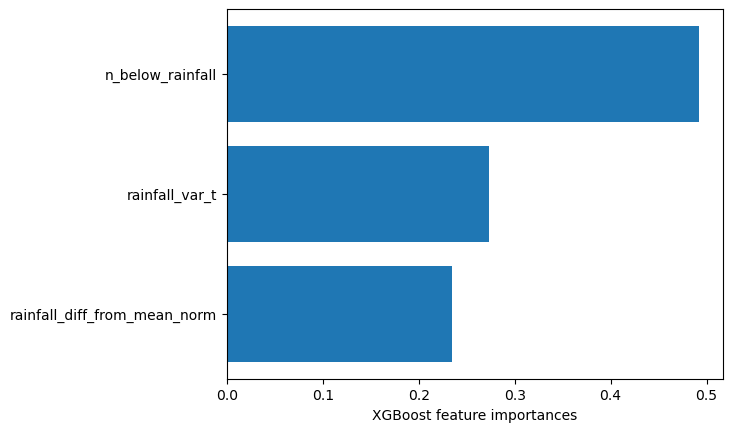

In [162]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBoostRegressorForSklearn())
])

param_grid = {
    'xgb__n_estimators': [10, 100, 500],
    'xgb__max_depth': [1, 3, 5, 10]
}

grid = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error')

feat = ['n_below_rainfall', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']

target = 'gdp_g'

X = subset[feat]
y = subset[target]

grid.fit(X, y)

print(grid.best_params_, grid_cv.best_score_)

best_model = grid.best_estimator_.named_steps['xgb']
sorted_idx = best_model.estimator.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model.estimator.feature_importances_[sorted_idx])
plt.xlabel('XGBoost feature importances')
plt.plot()